# 1D linear MHD with a non-uniform background magnetic field

This notebook simulates MHD waves in a homogeneous plasma in the background field

\begin{align}
B_{0x}(x)=B_{0x}(0)(1+\xi x^2) \\
B_{0y}(x,y)=-xy\xi B_{0x}(0) \\
B_{0z}(x,z)=-xz\xi B_{0x}(0),
\end{align}

where the y- and z-component are choosen in order to ensure $\nabla\cdot\textbf{B}_0=0$.
The linearized ideal MHD equations then lead to a system for the perturbed quantities (which only vary in the x-direction for simplicity) $\textbf{U}=(u_{1x},u_{1y},u_{1z},B_{1x},B_{1y},B_{1z},\rho_1,p_1)$ of the form:

\begin{align}
\partial_t \textbf{U}(t,x)+A(x,y,z)\partial_x\textbf{U}(t,x)+C(x,y,z)\textbf{U}(t,x)=0,
\end{align}

with some initial condition $\textbf{U}(0,x)$ and appropriate boundary conditions.
The matrices are

\begin{align}
A(x,y,z)=
\begin{pmatrix}
0 &0 &0 &0 &B_{0y}/\rho_0 &B_{0z}/\rho_0 &0 &1/(2\rho_0) \\
0 &0 &0 &0 &-B_{0x}/\rho_0 &0 &0 &0 \\
0 &0 &0 &0 &0 &-B_{0x}/\rho_0 &0 &0 \\
0 &0 &0 &0 &0 &0 &0 &0 \\
B_{0y} &-B_{0x} &0 &0 &0 &0 &0 &0 \\
B_{0z} &0 &-B_{0x} &0 &0 &0 &0 &0 \\
\rho_0 &0 &0 &0 &0 &0 &0 &0 \\
\gamma p_0 &0 &0 &0 &0 &0 &0 &0 
\end{pmatrix}
\end{align}

and
\begin{align}
C(x,y,z)=
\begin{pmatrix}
0 &0 &0 &0 &\partial_x B_{0y}/\rho_0 &\partial_x B_{0z}/\rho_0 &0 &0 \\
0 &0 &0 &-\partial_x B_{0y}/\rho_0 &0 &0 &0 &0 \\
0 &0 &0 &-\partial_x B_{0z}/\rho_0 &0 &0 &0 &0 \\
-\partial_y B_{0y}-\partial_z B_{0z} &0 &0 &0 &0 &0 &0 &0 \\
\partial_x B_{0y} &-\partial_x B_{0x}-\partial_z B_{0z} &0 &0 &0 &0 &0 &0 \\
\partial_x B_{0z} &0 &-\partial_x B_{0x}-\partial_y B_{0y} &0 &0 &0 &0 &0 \\
0 &0 &0 &0 &0 &0 &0 &0 \\
0 &0 &0 &0 &0 &0 &0 &0 
\end{pmatrix}
\end{align}

The used numerical method is a second order Lax-Wendroff Finite Differences scheme which is second order in time and space. Periodic, Dirichlet and Neumann boundary conditions are implemented.

Number of time steps: 712
Time steps finished: 0
Time steps finished: 100
Time steps finished: 200
Time steps finished: 300
Time steps finished: 400
Time steps finished: 500
Time steps finished: 600
Time steps finished: 700
Time integration finished!
Start to prepare animation
Number of frames: 89
Frames finished: 0
Frames finished: 50



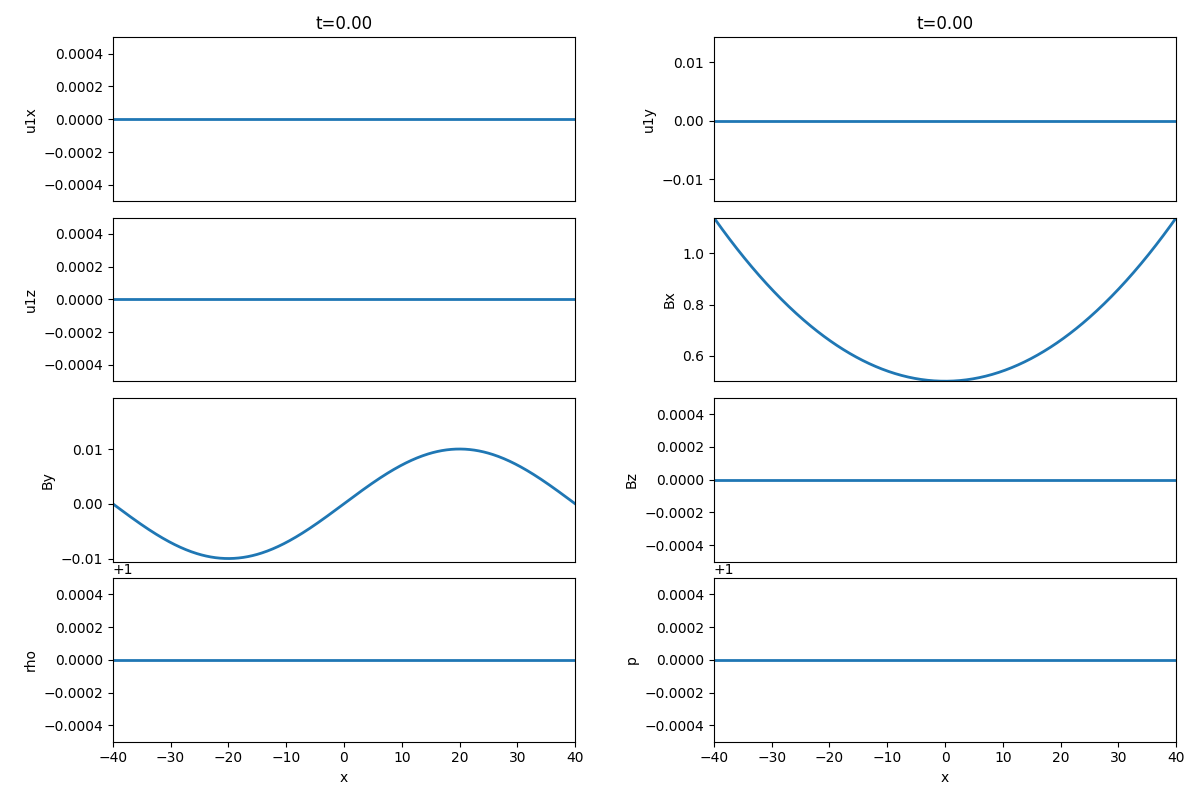
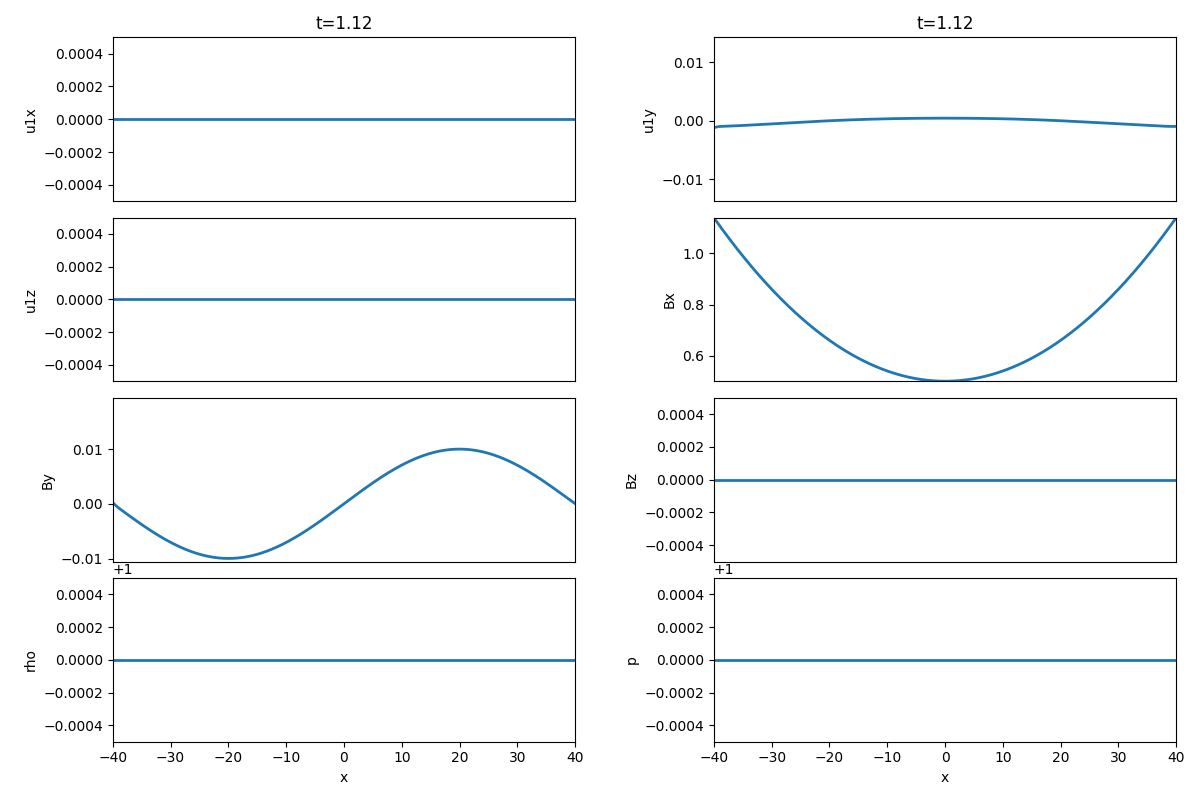
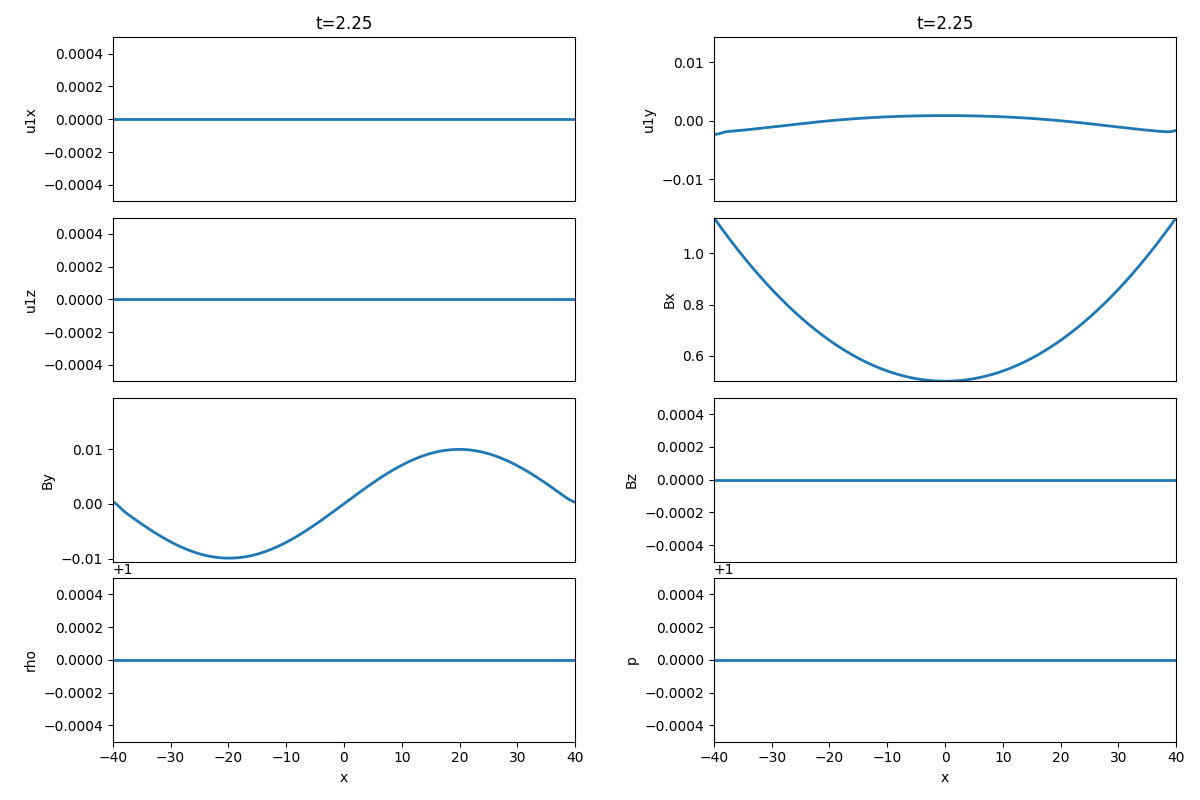
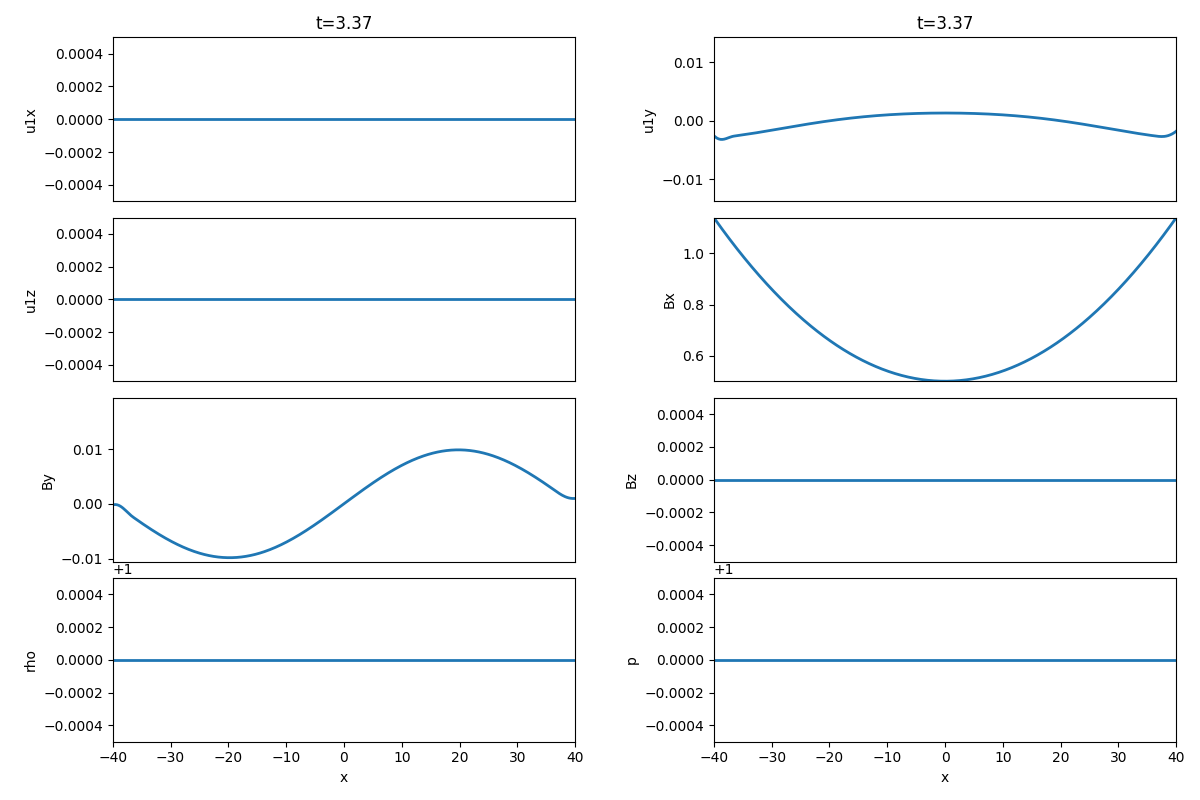
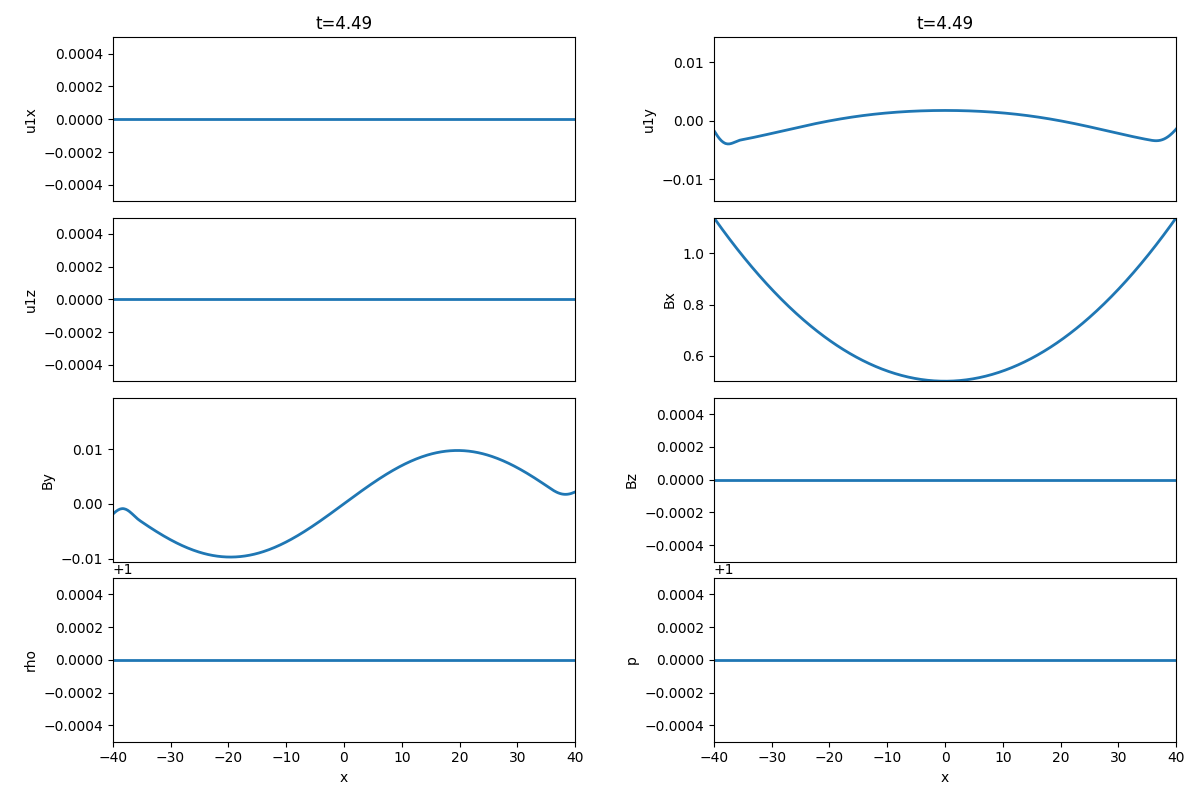
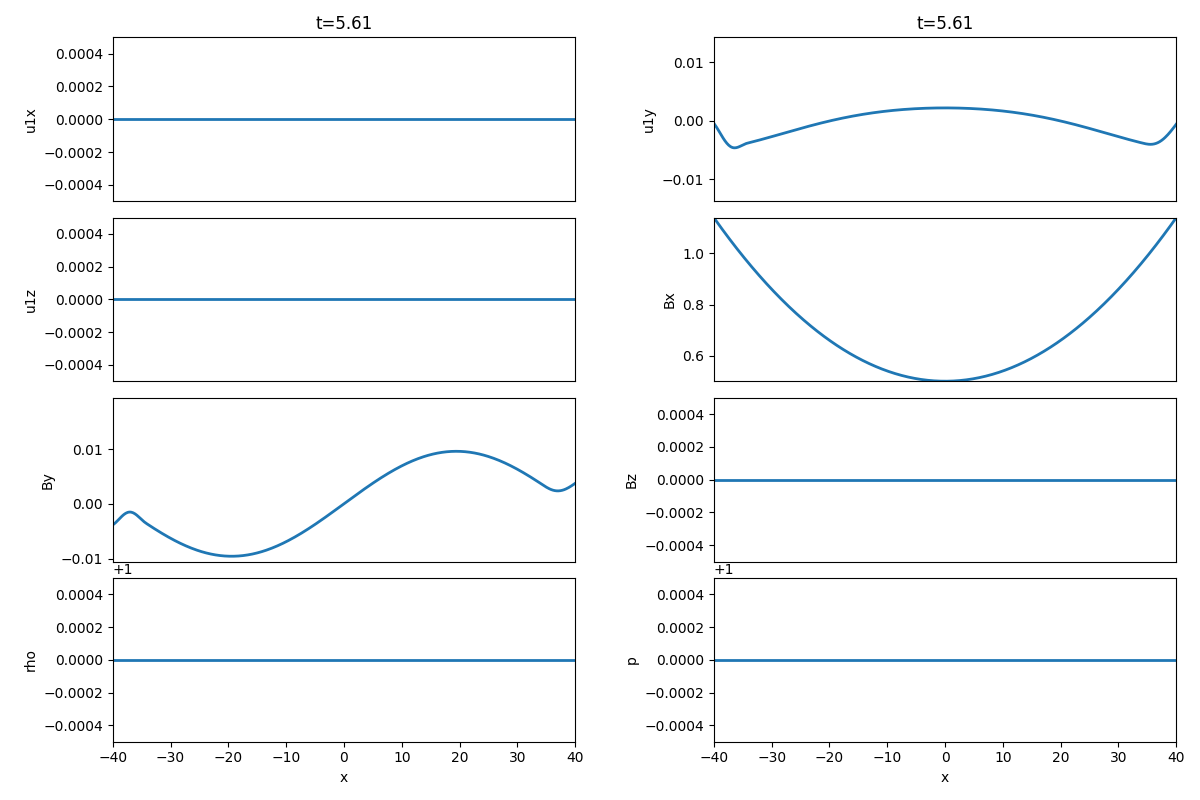
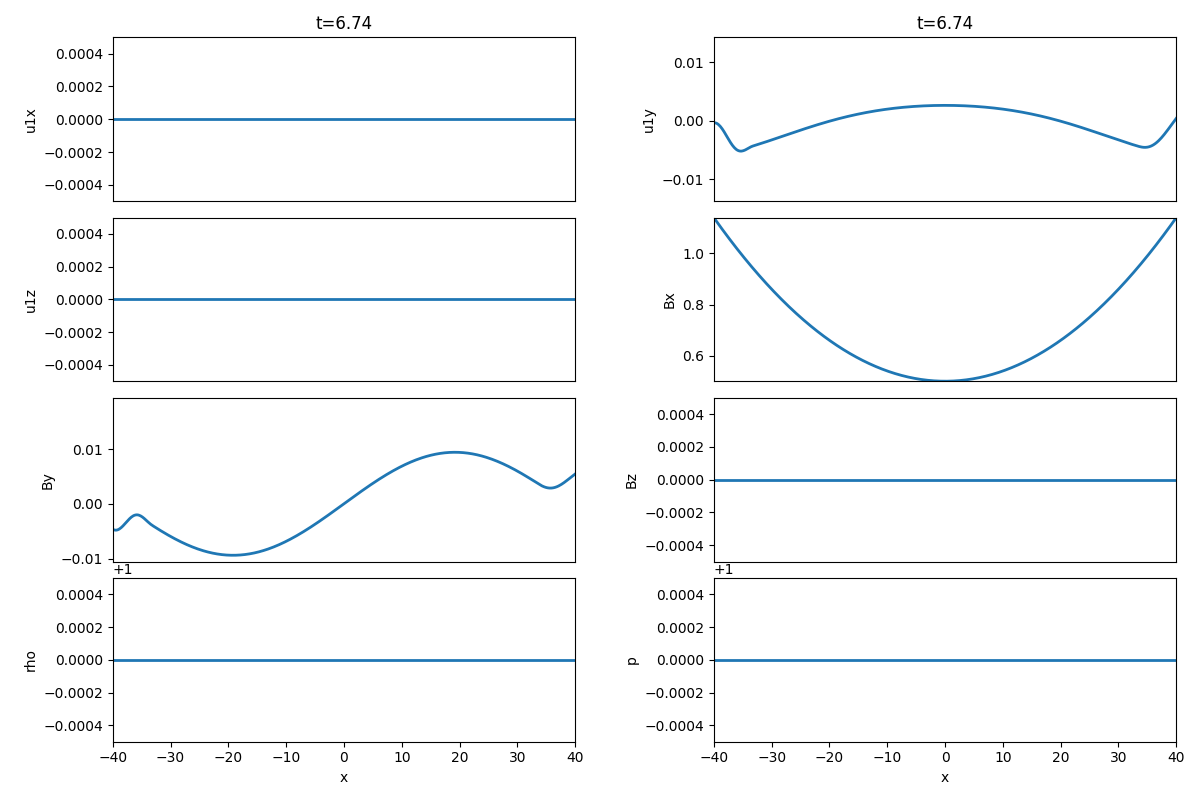
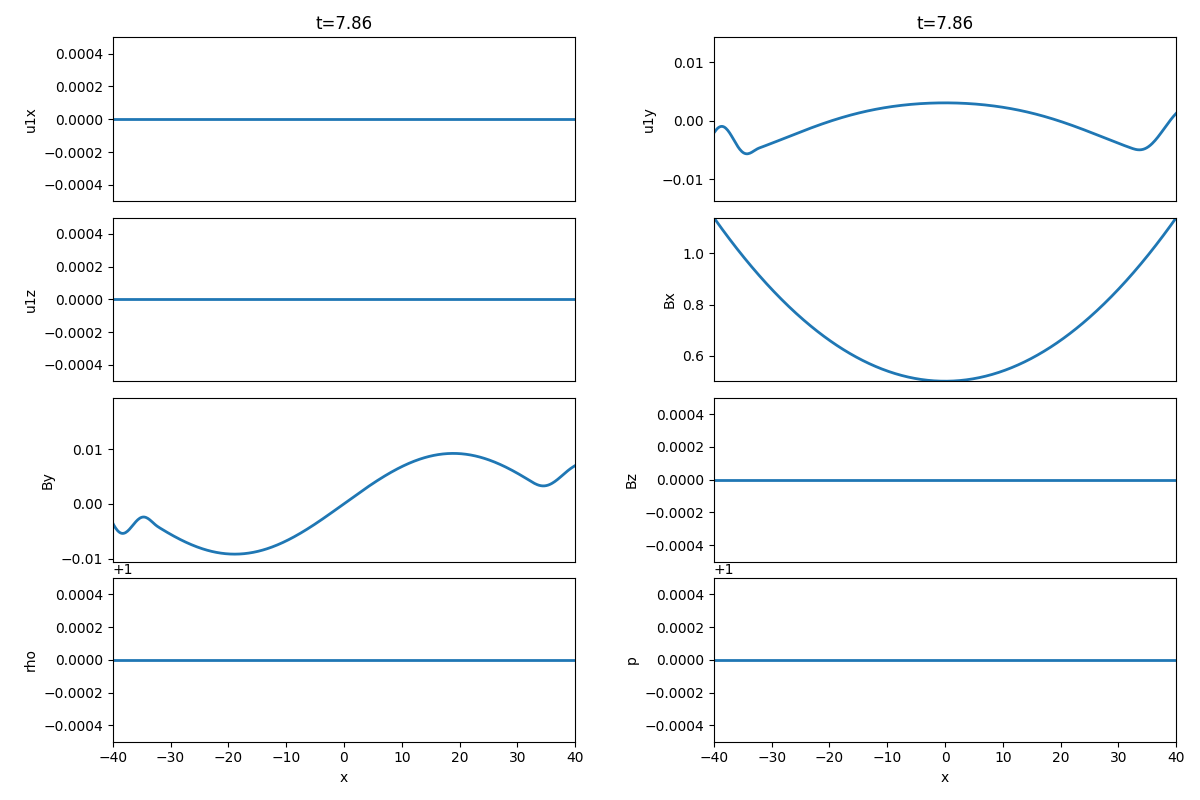
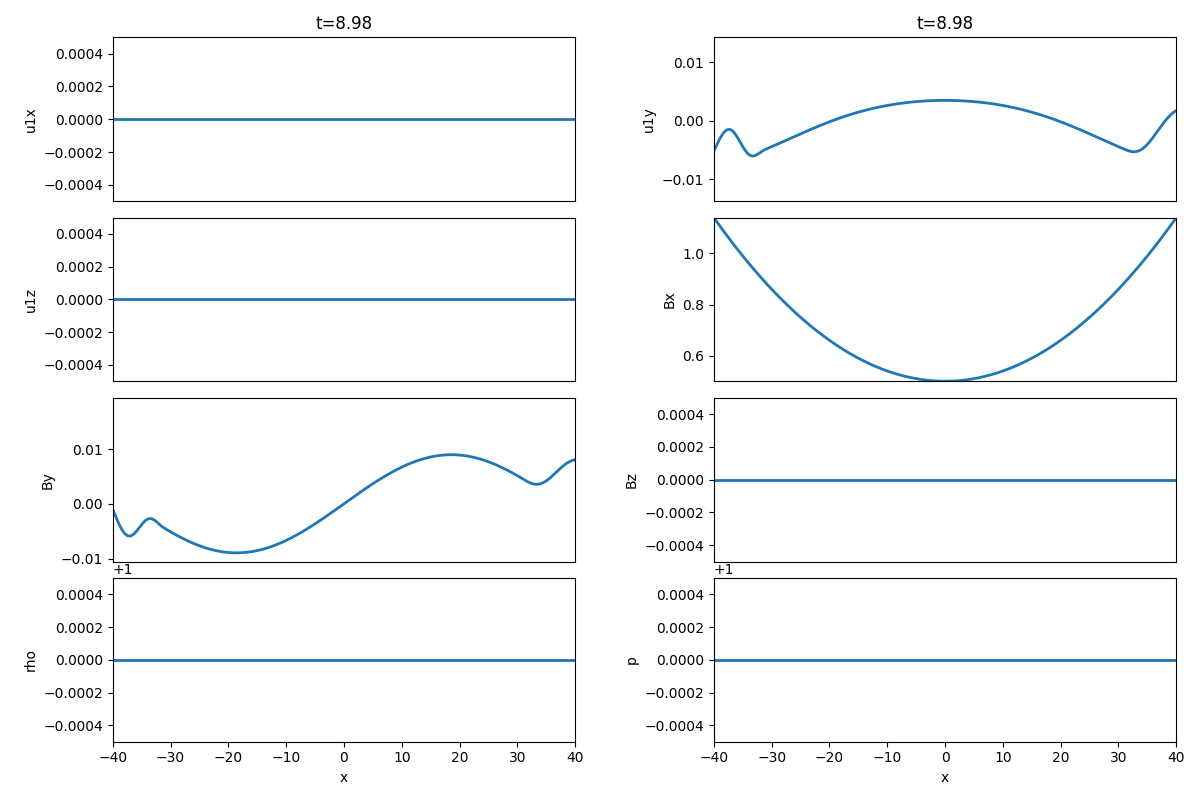
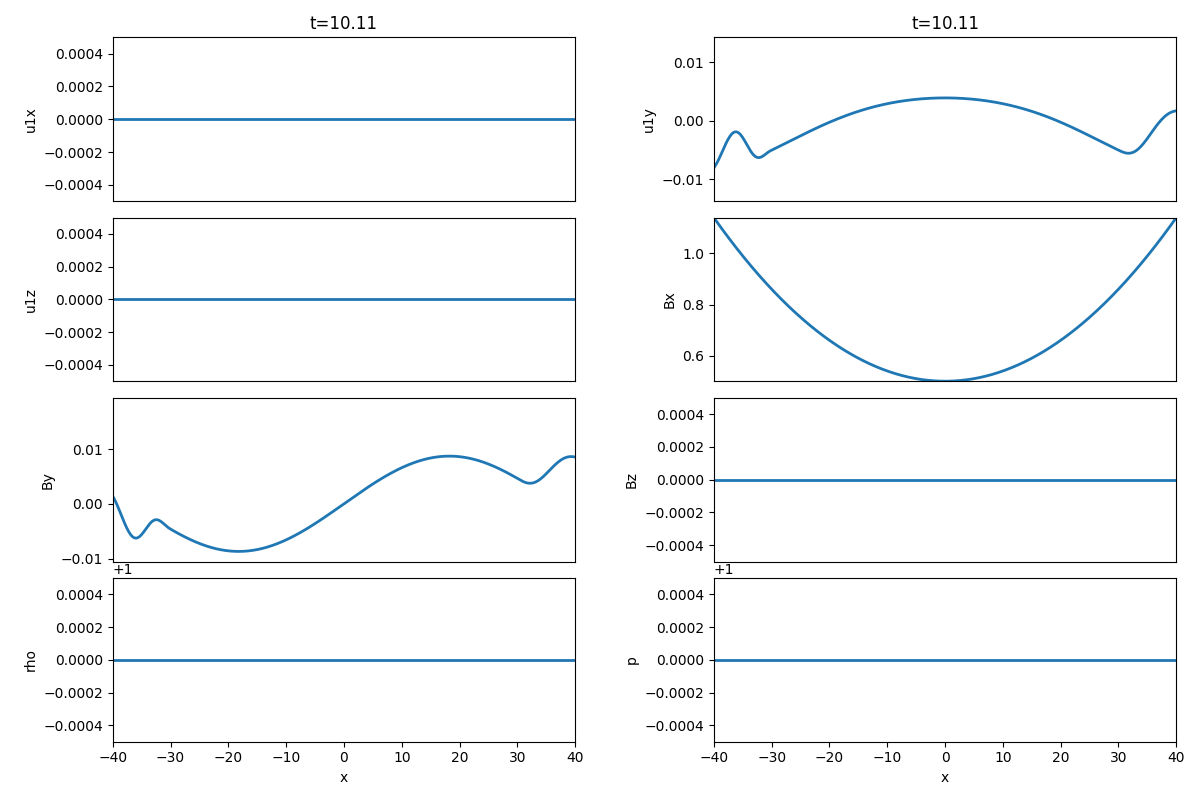
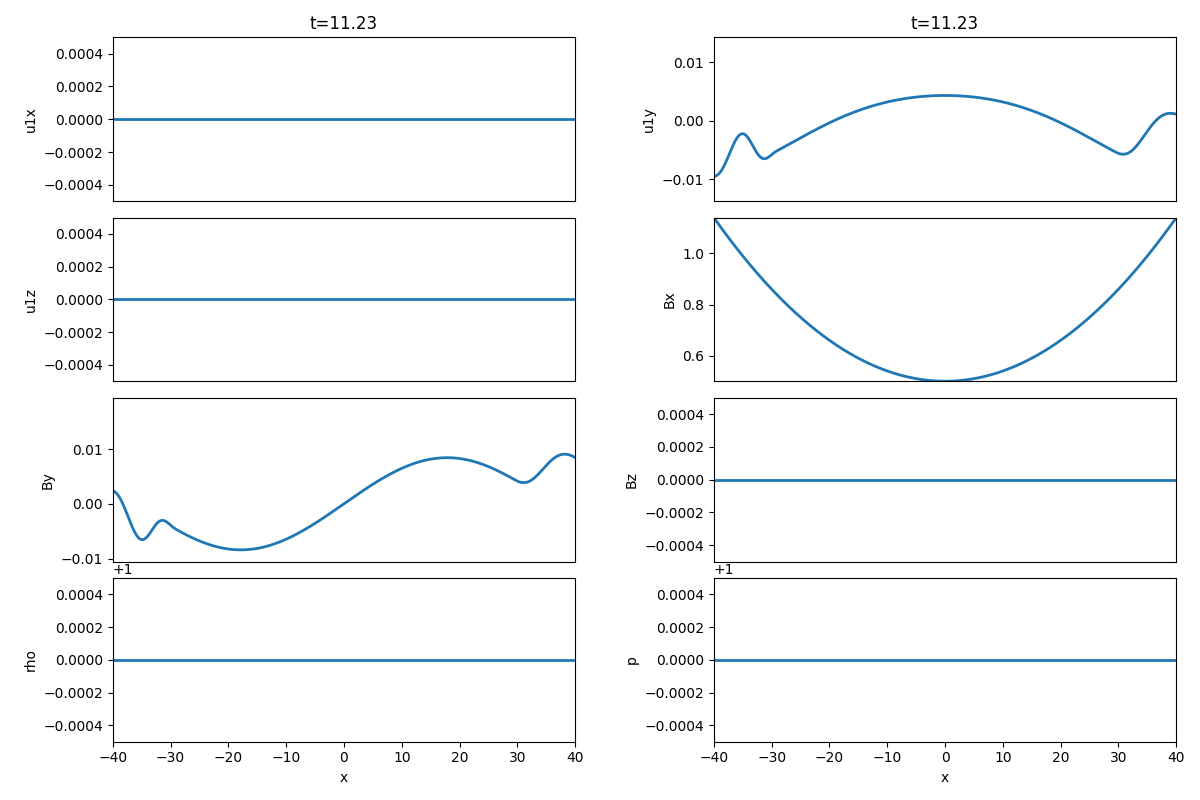
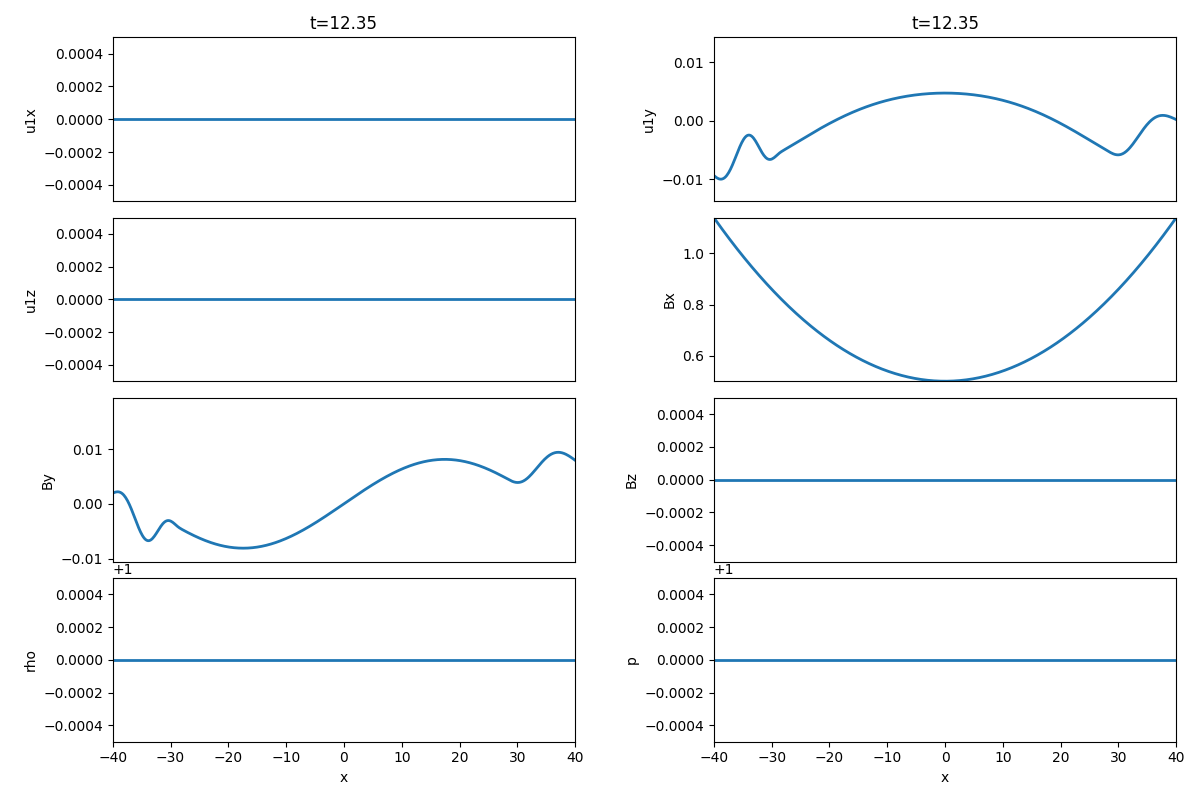
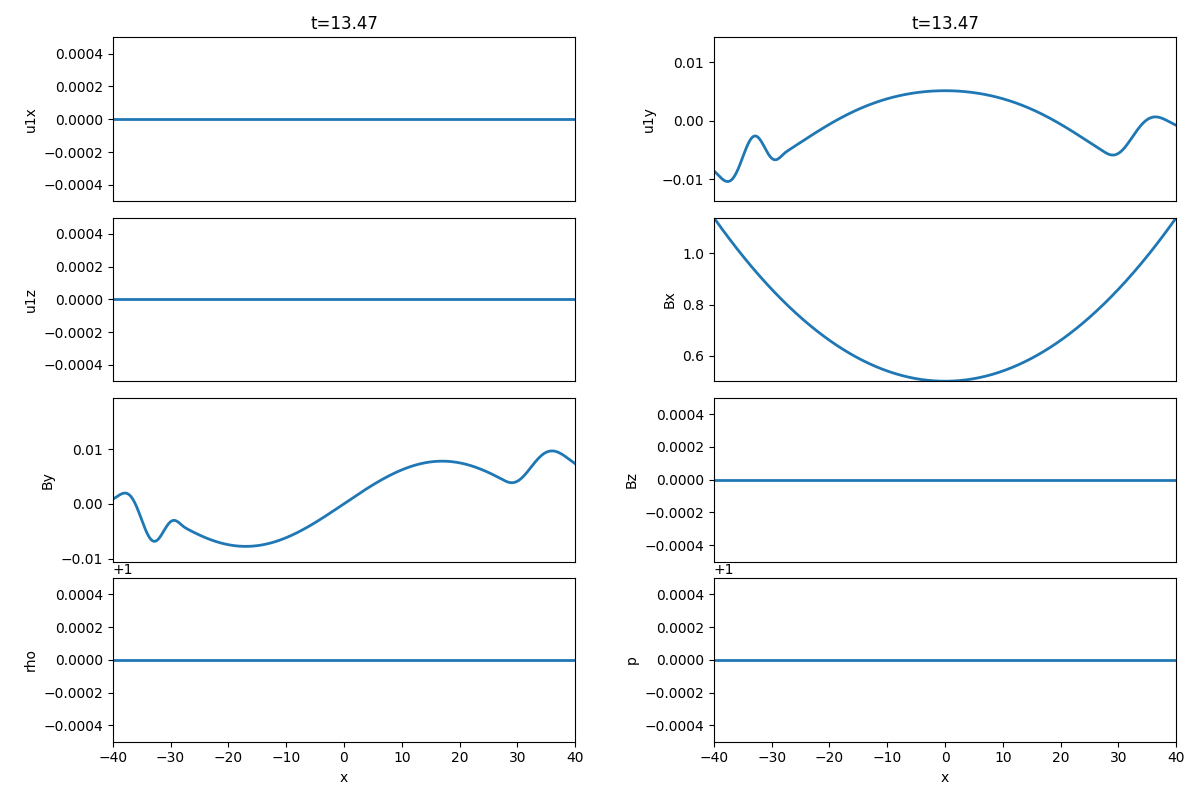
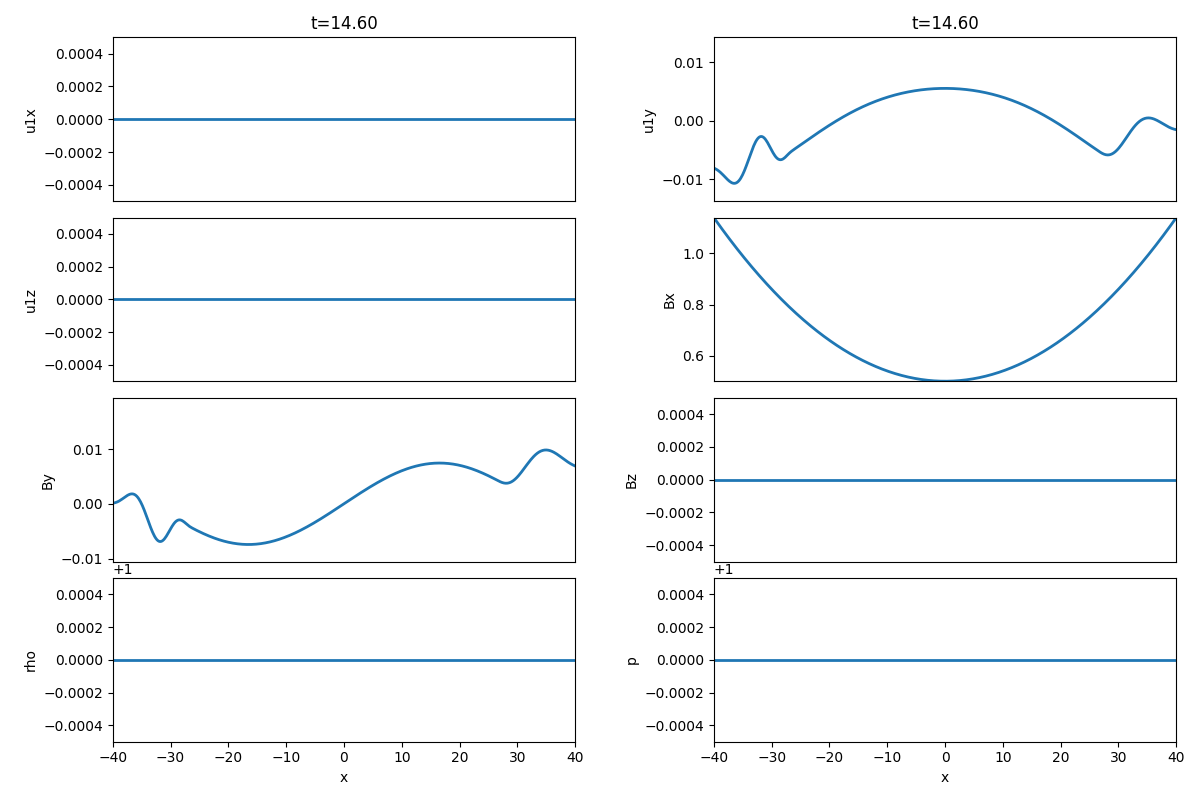
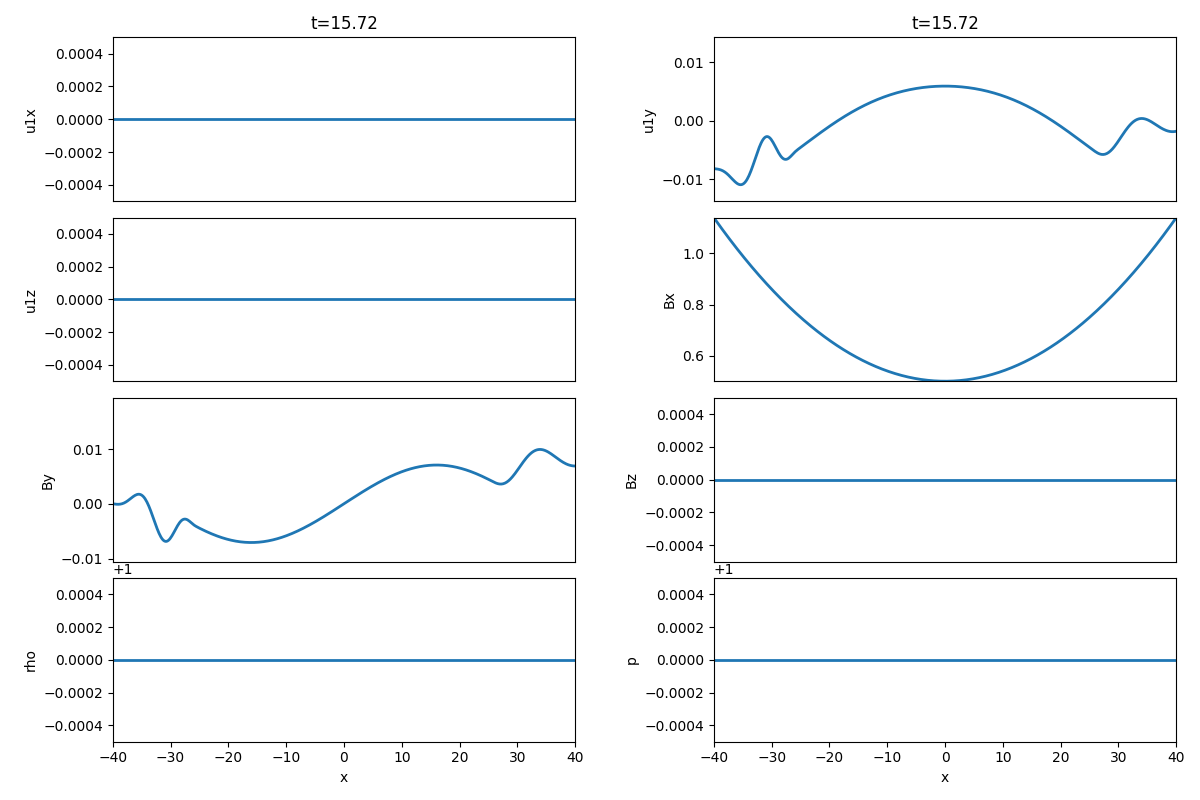
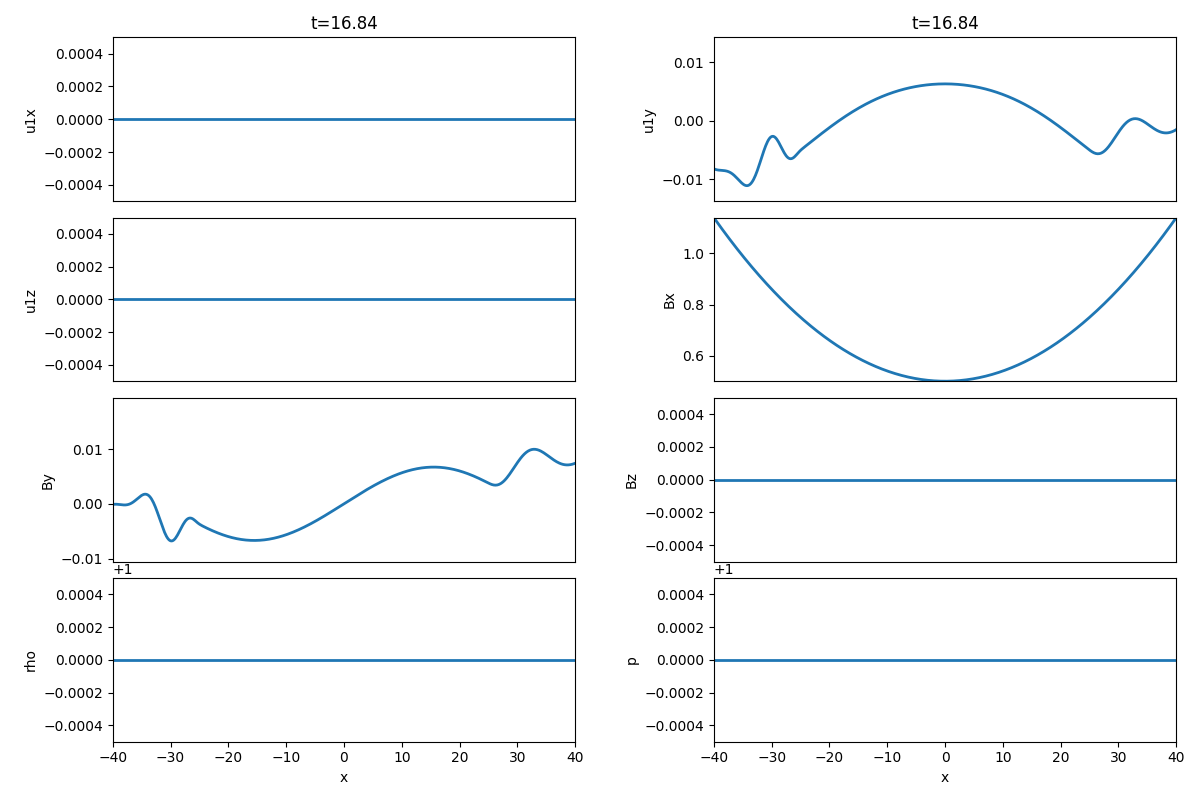
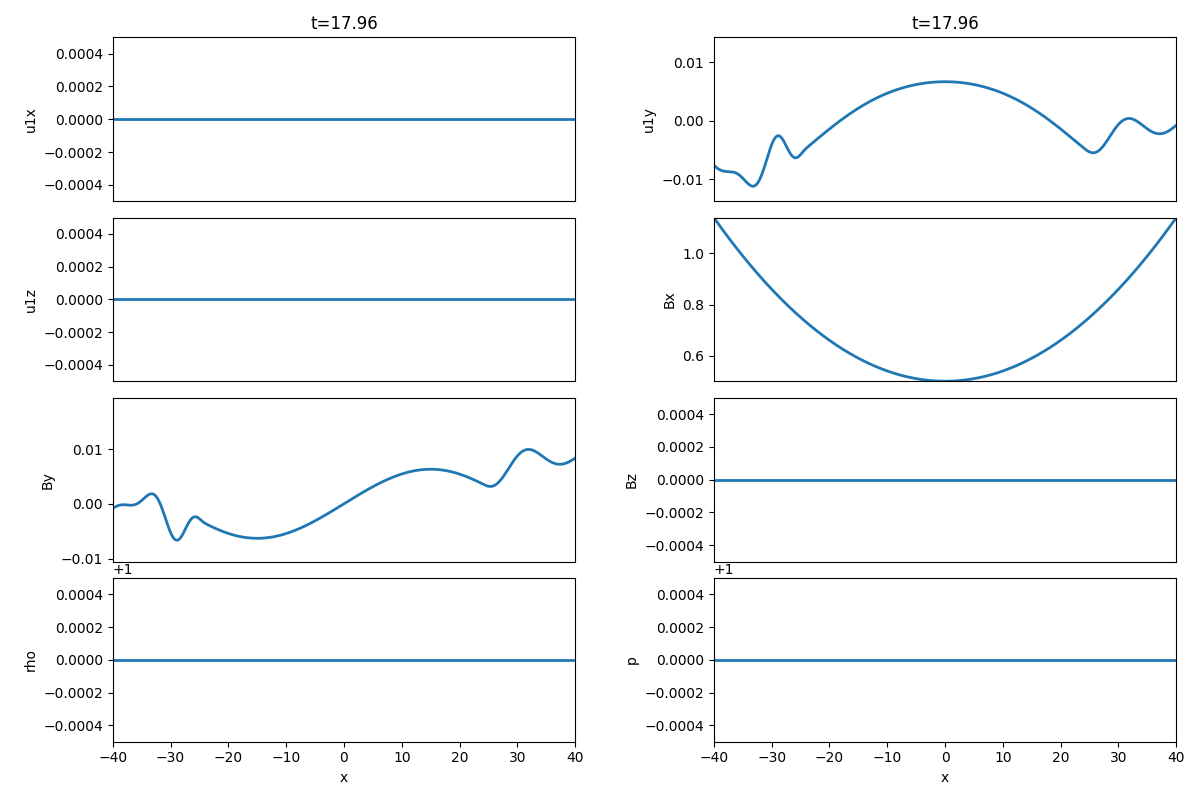
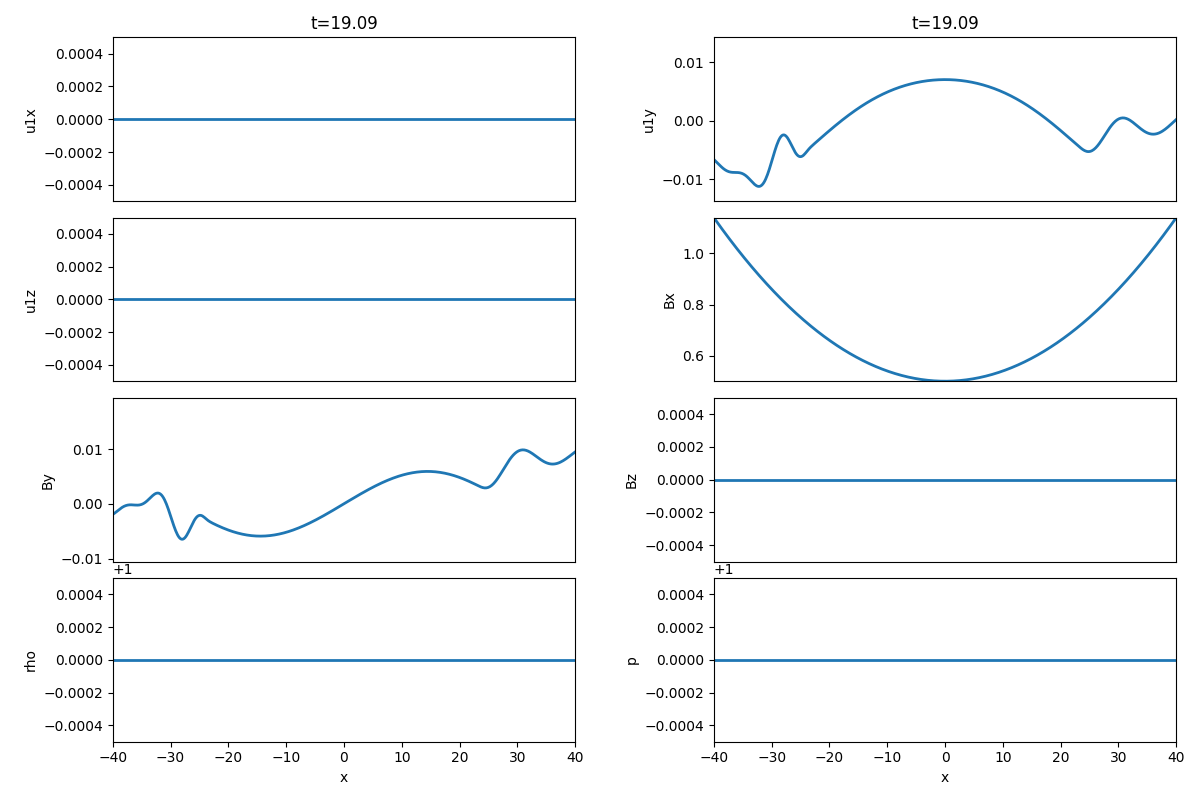
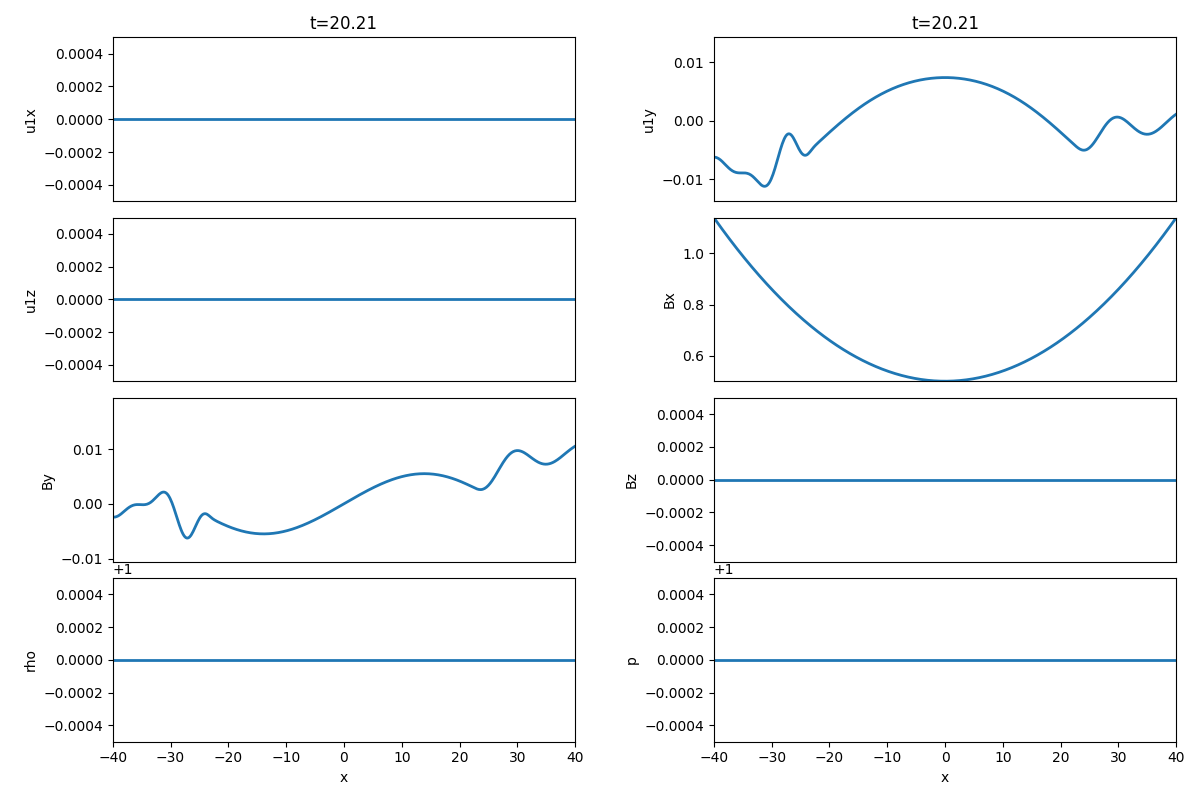
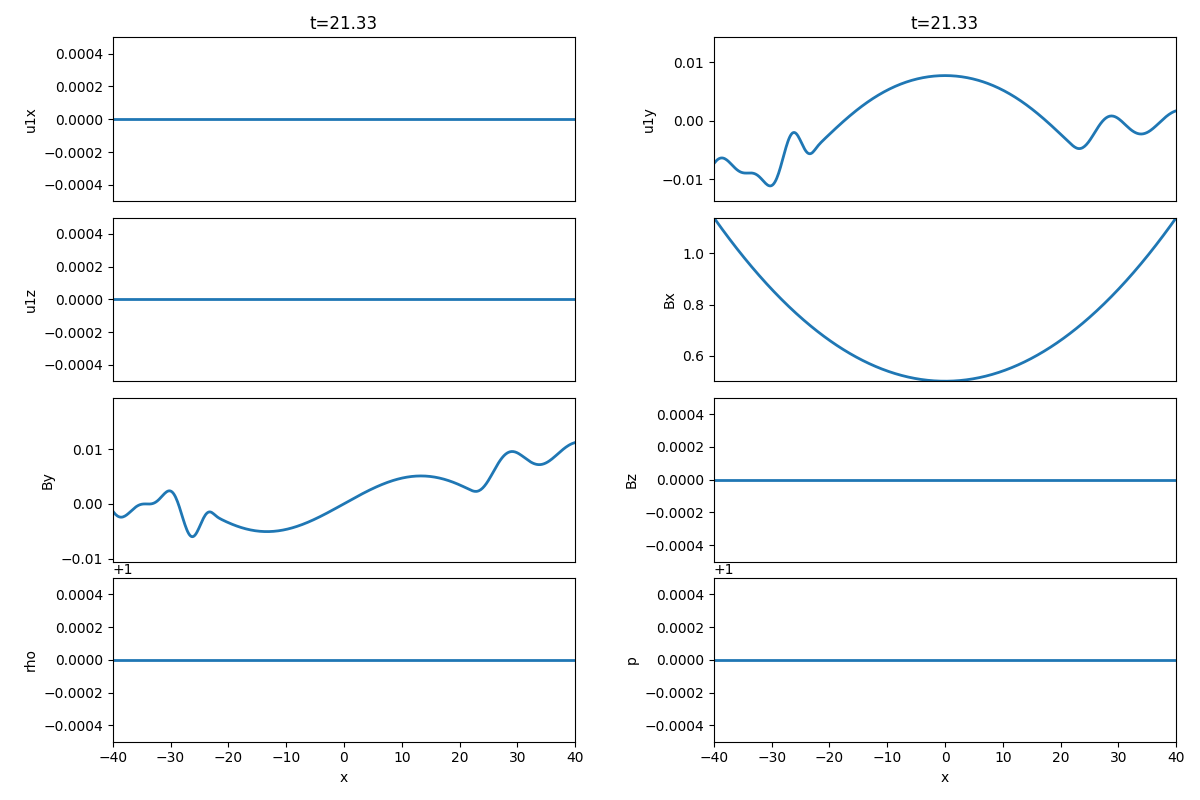
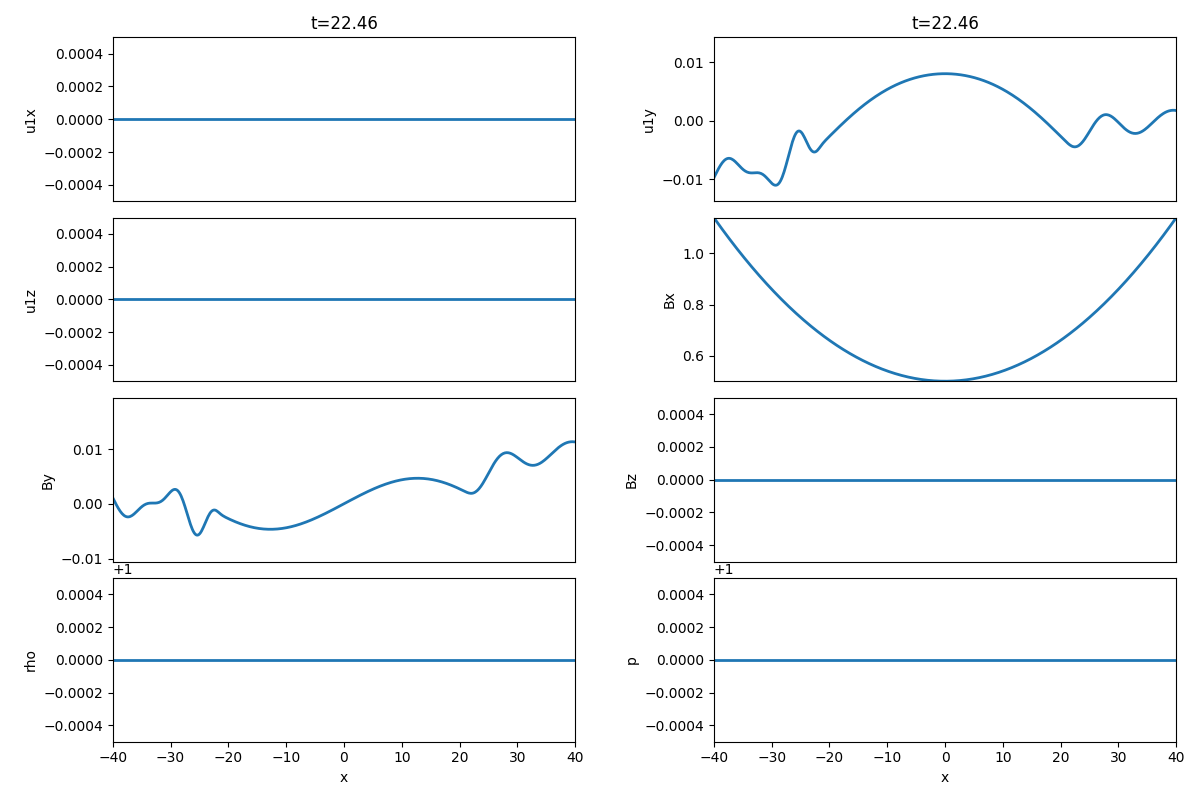
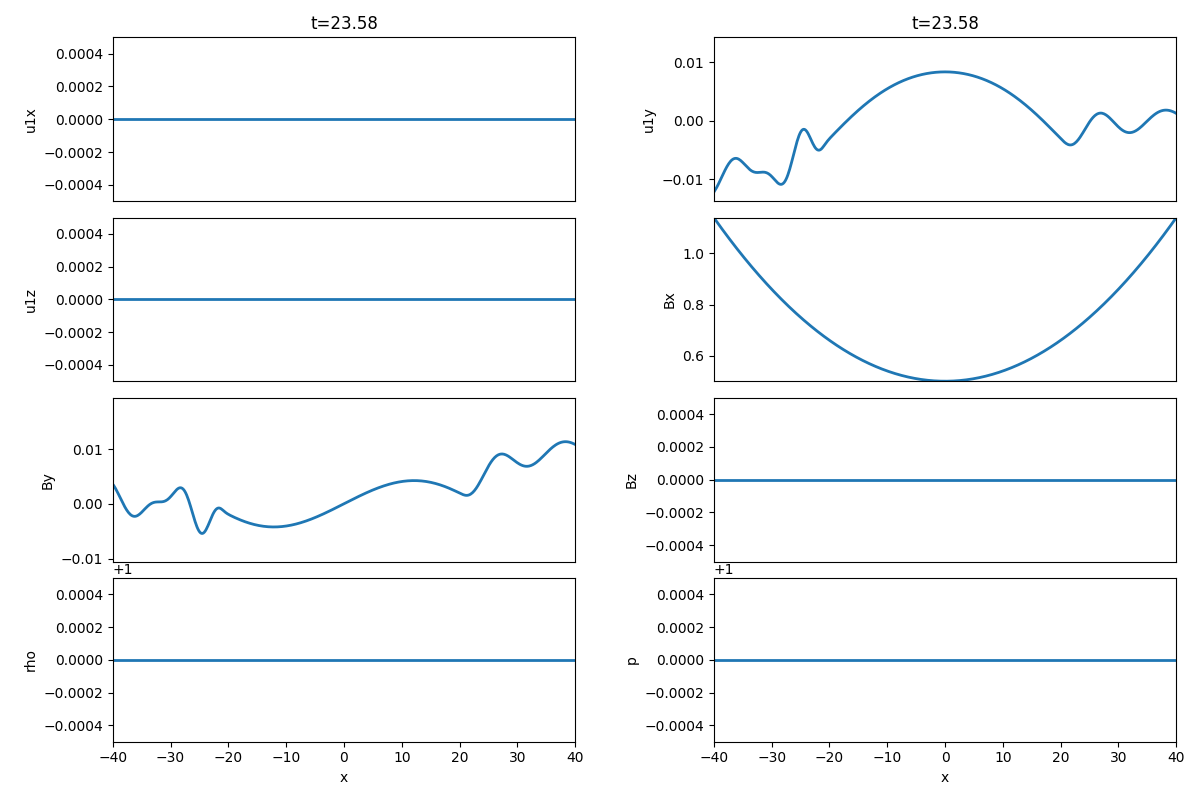
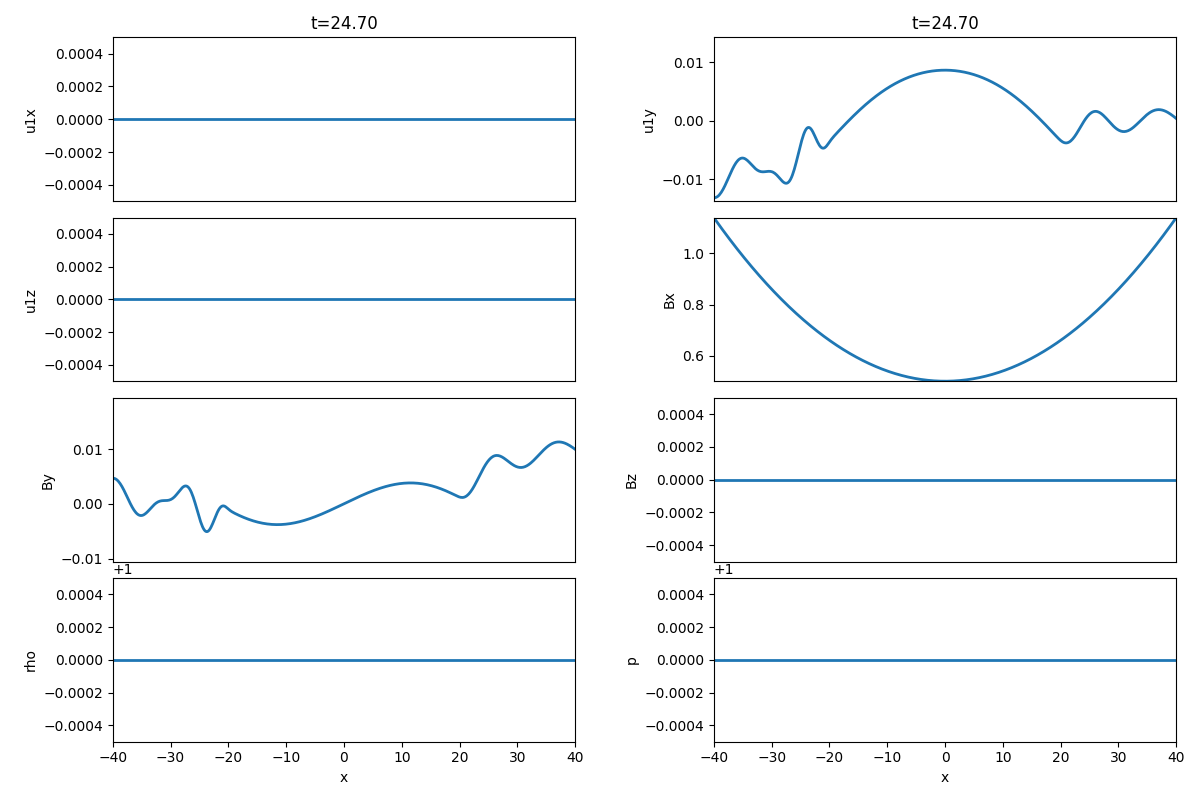
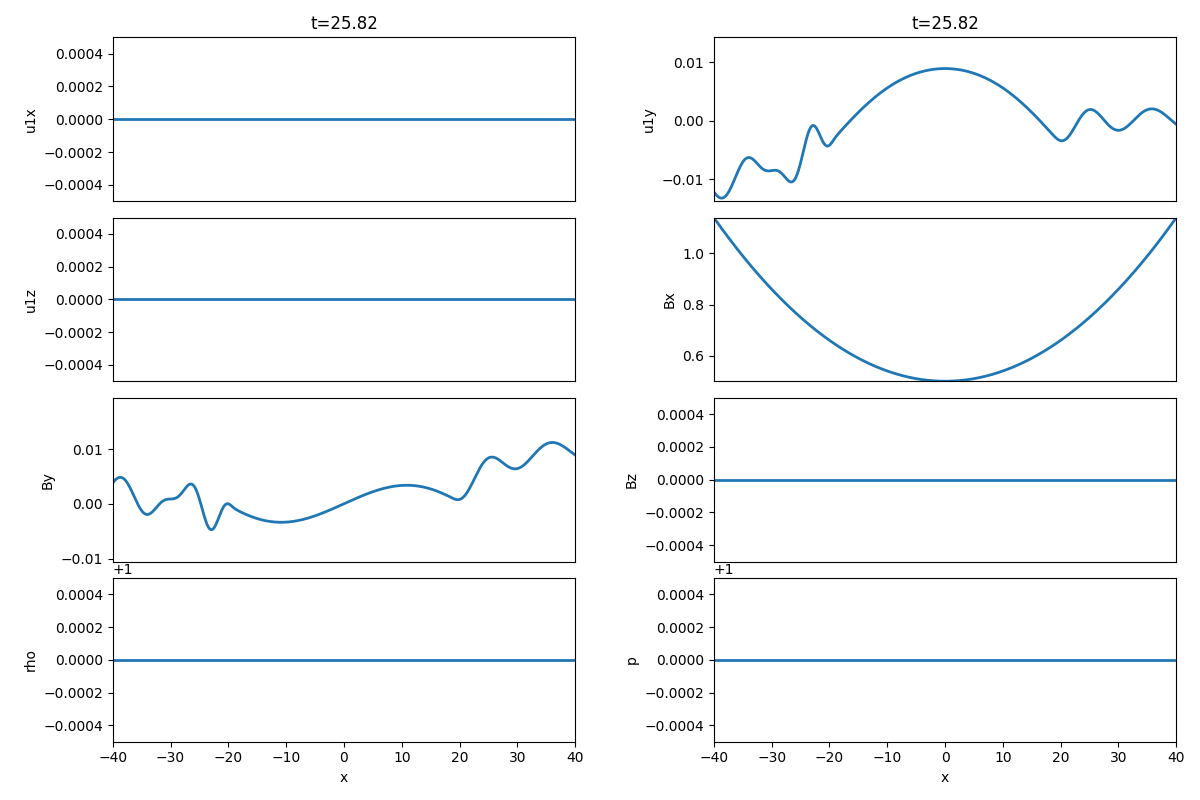
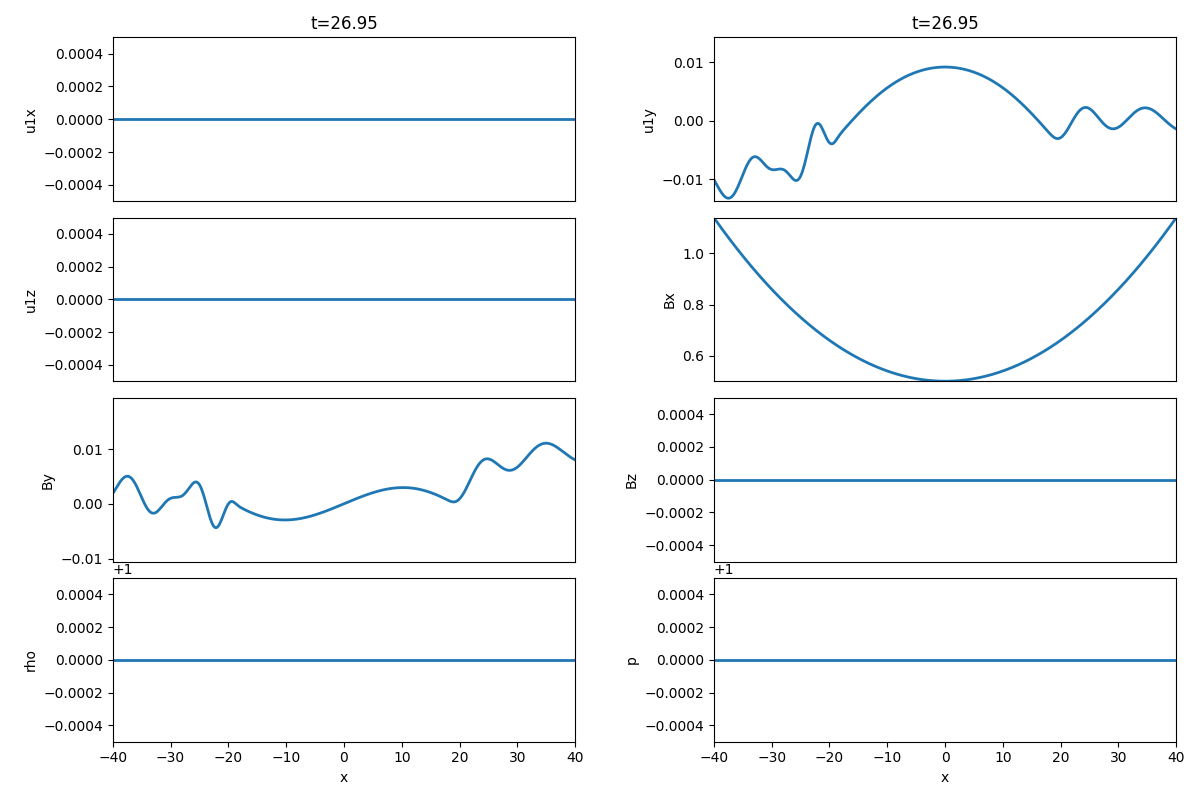
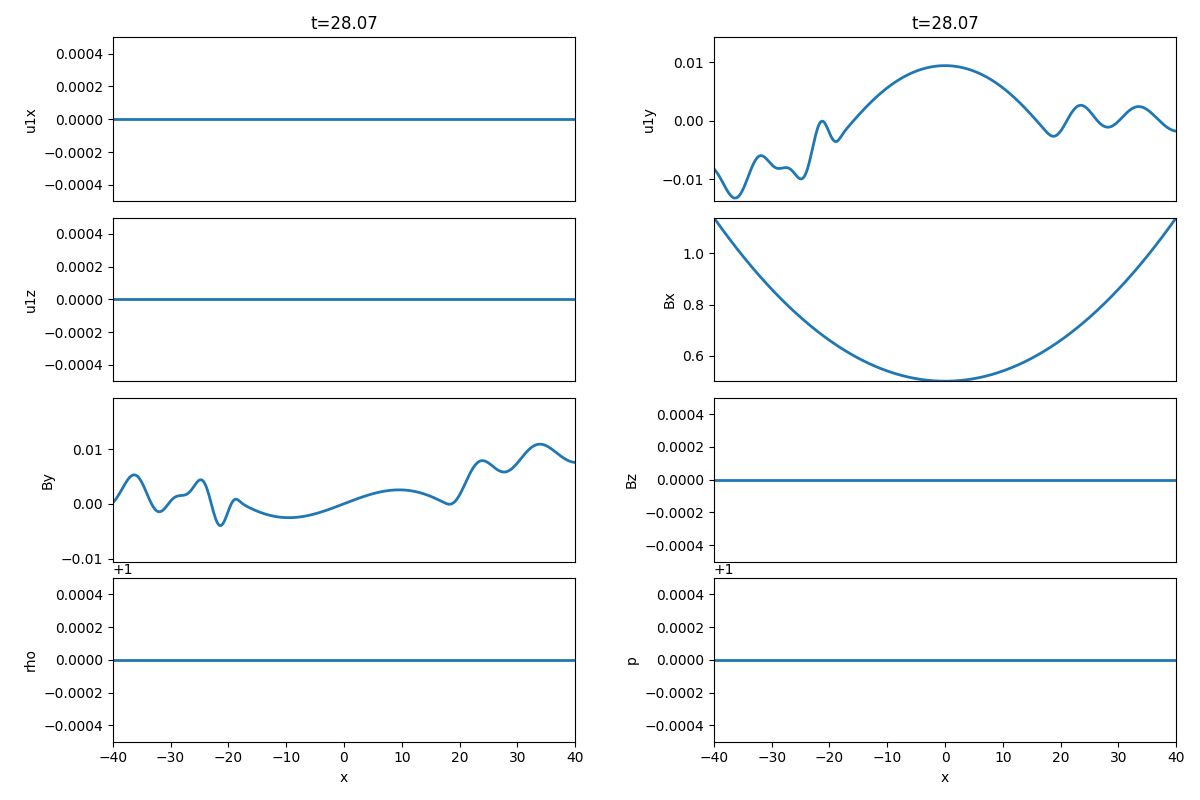
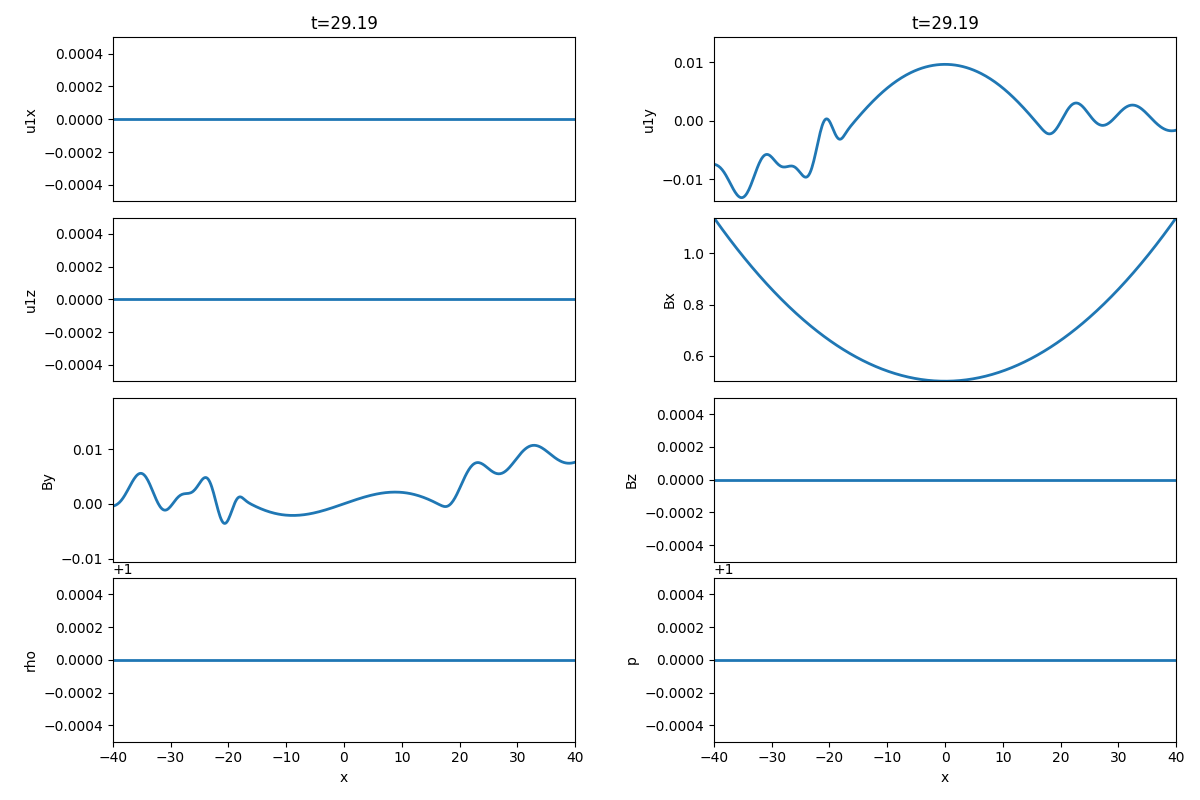
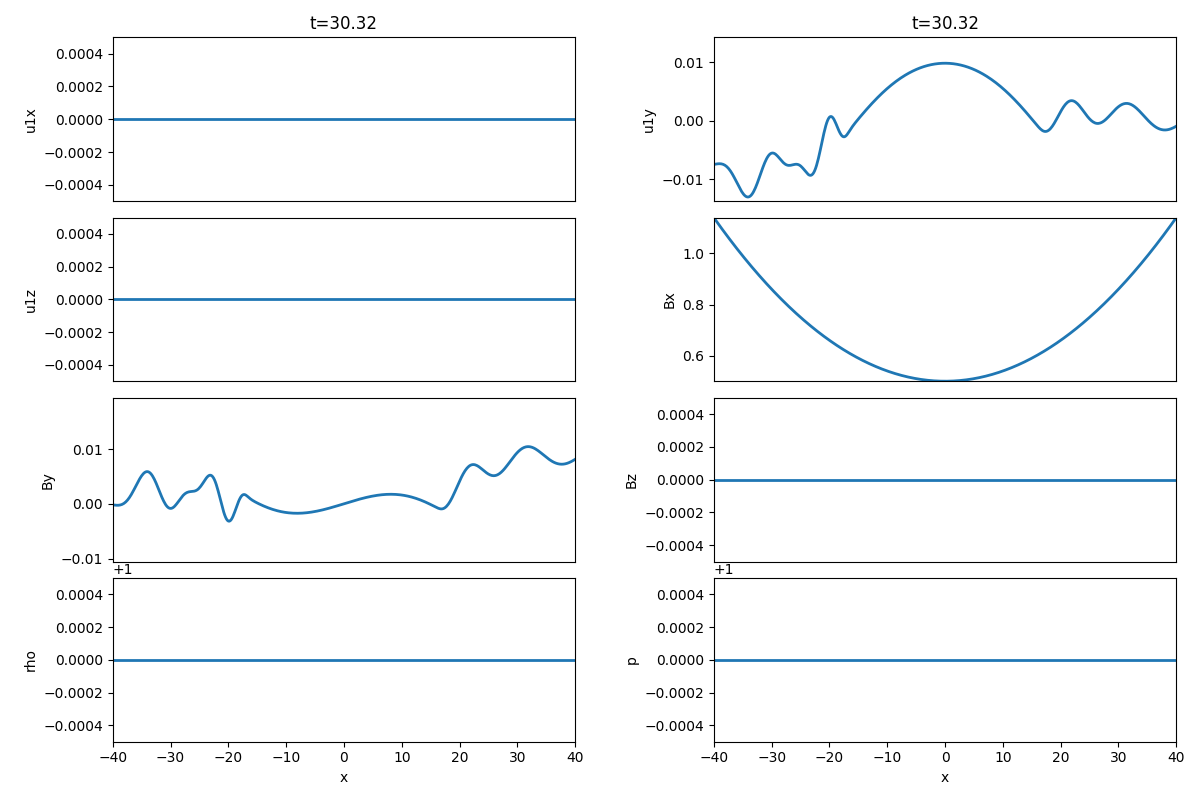
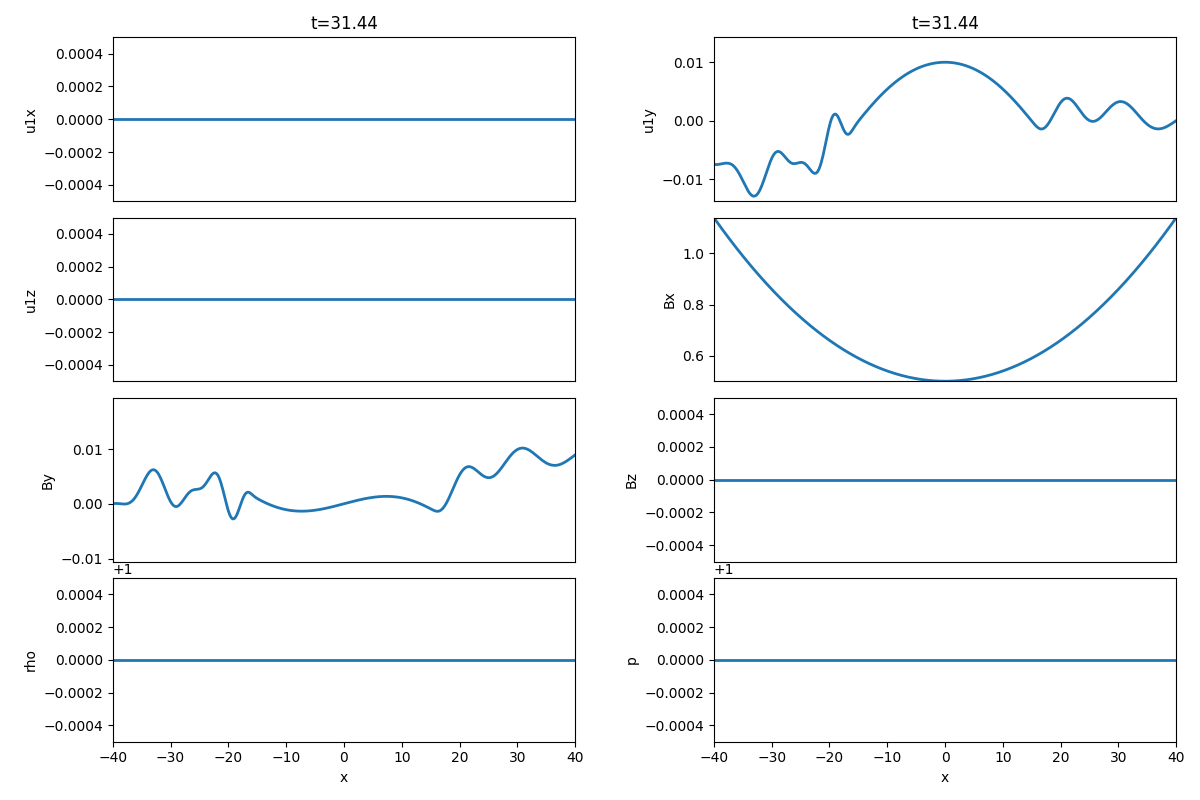
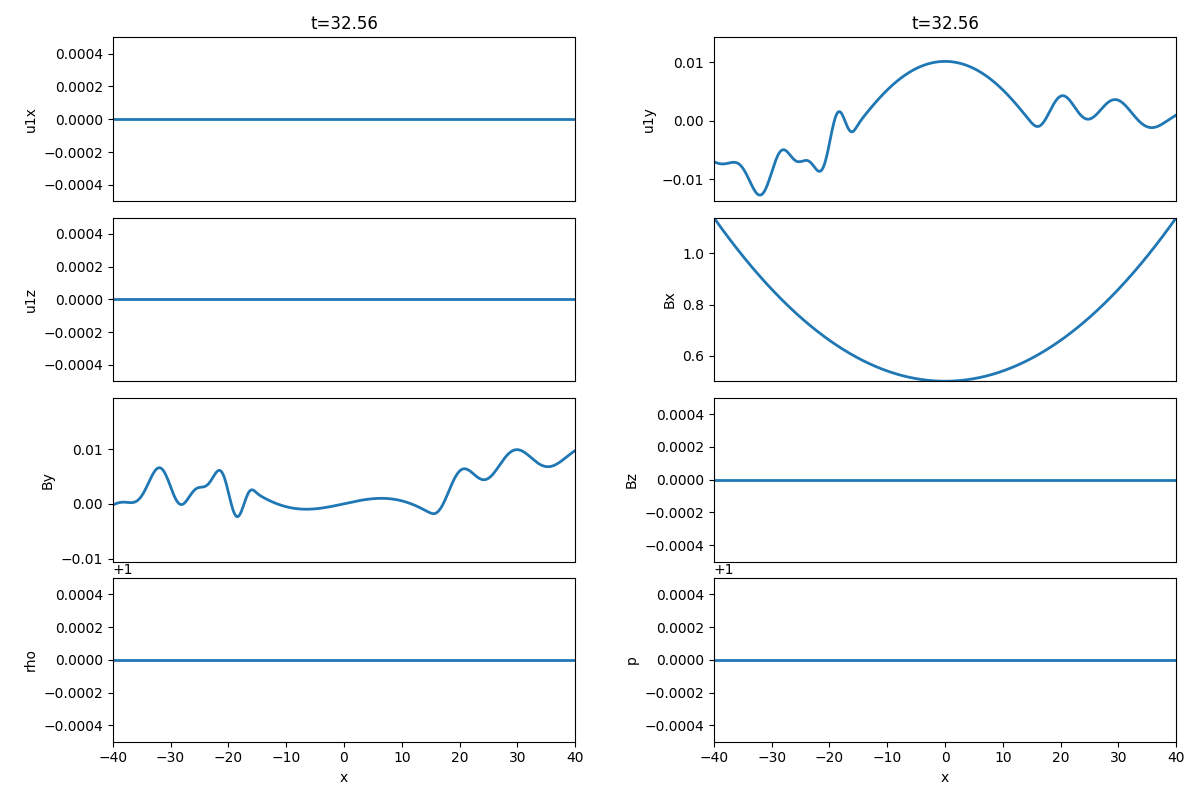
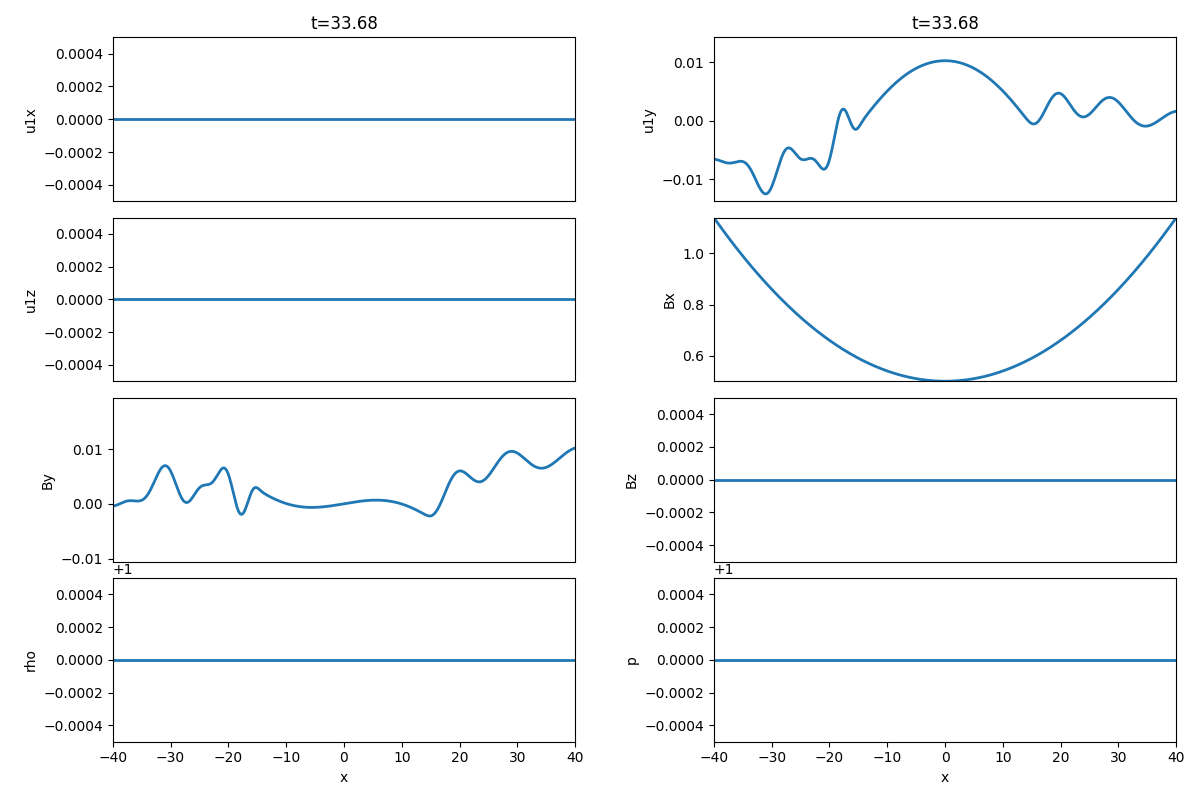
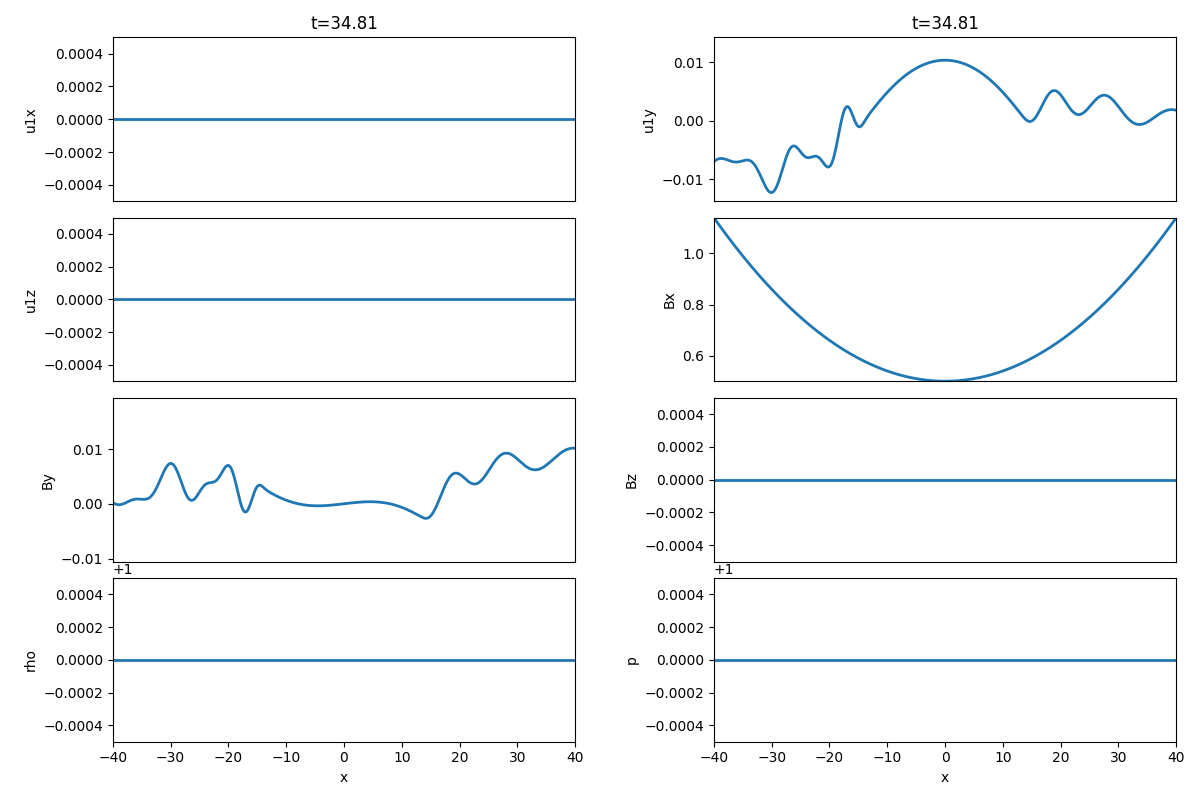
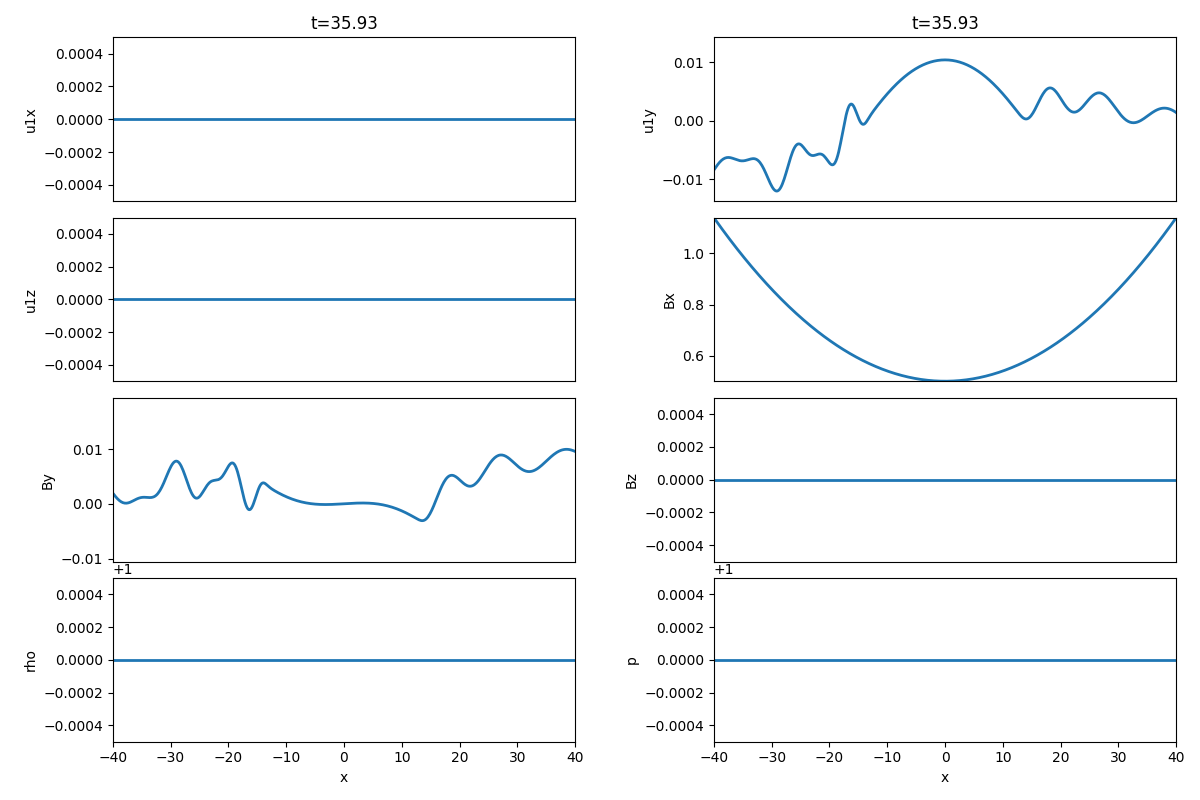
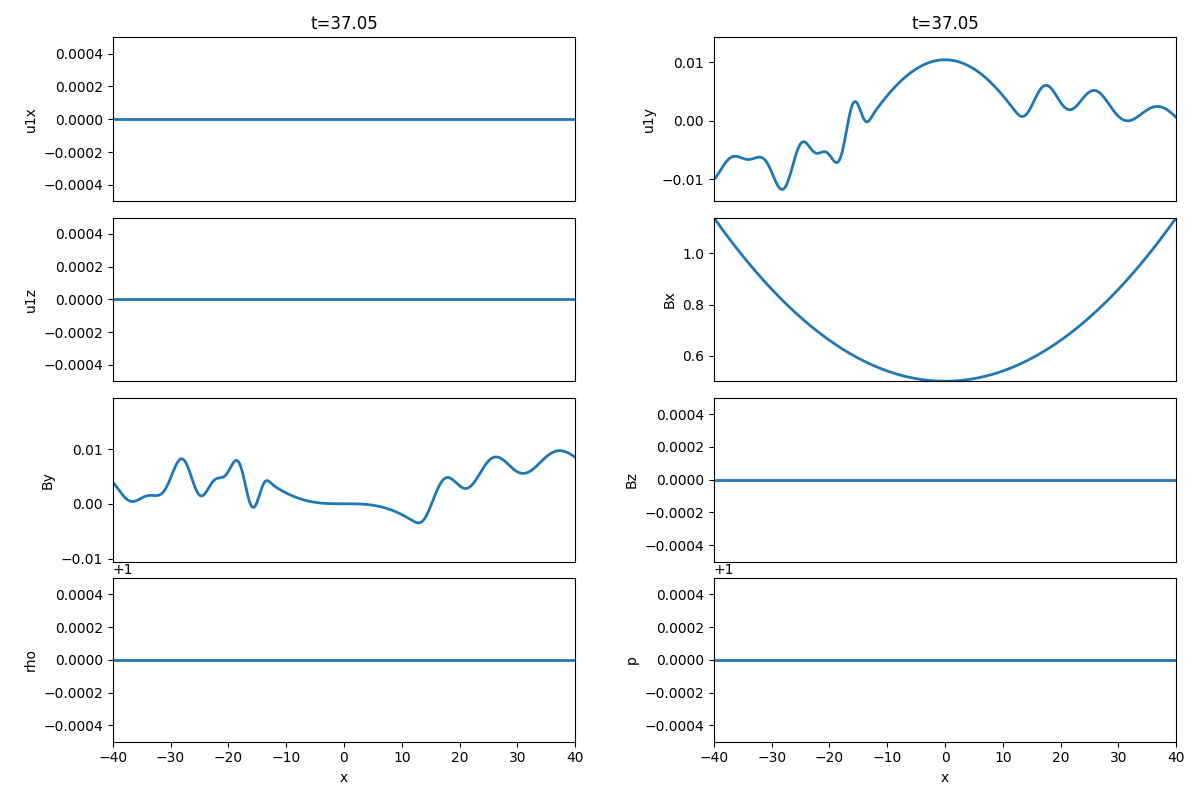
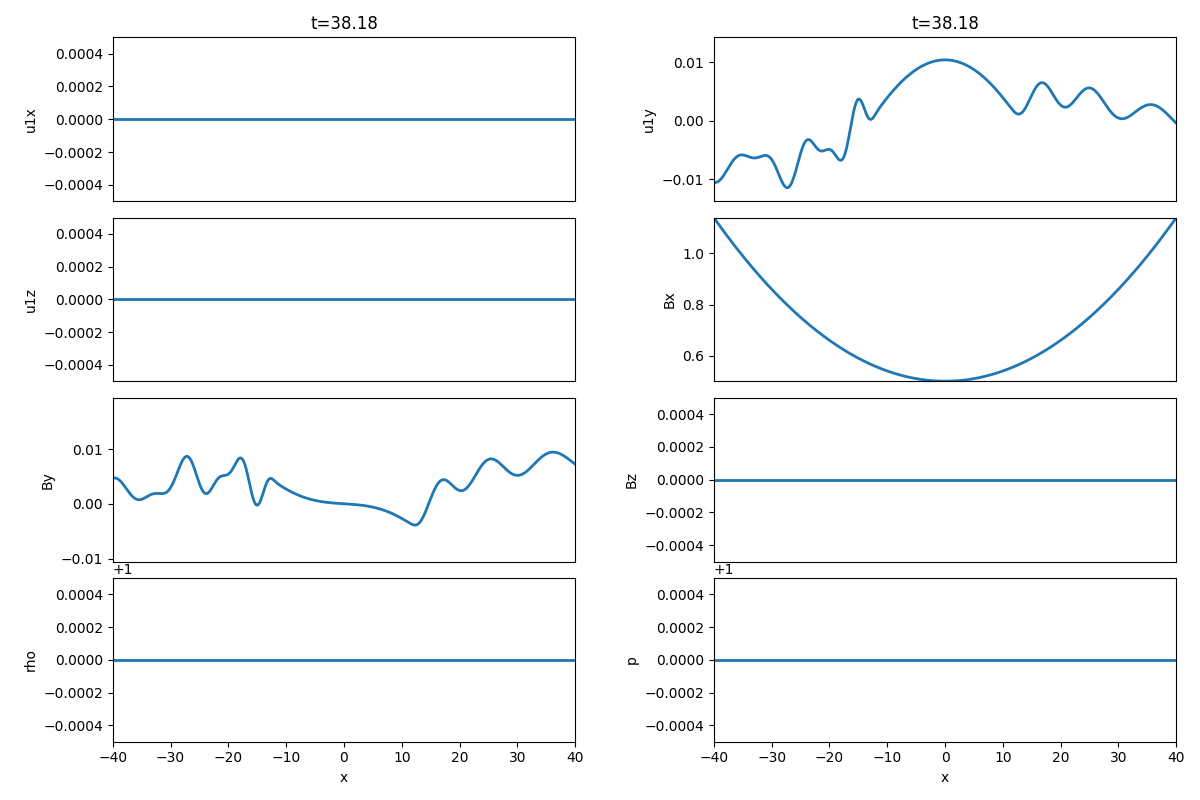
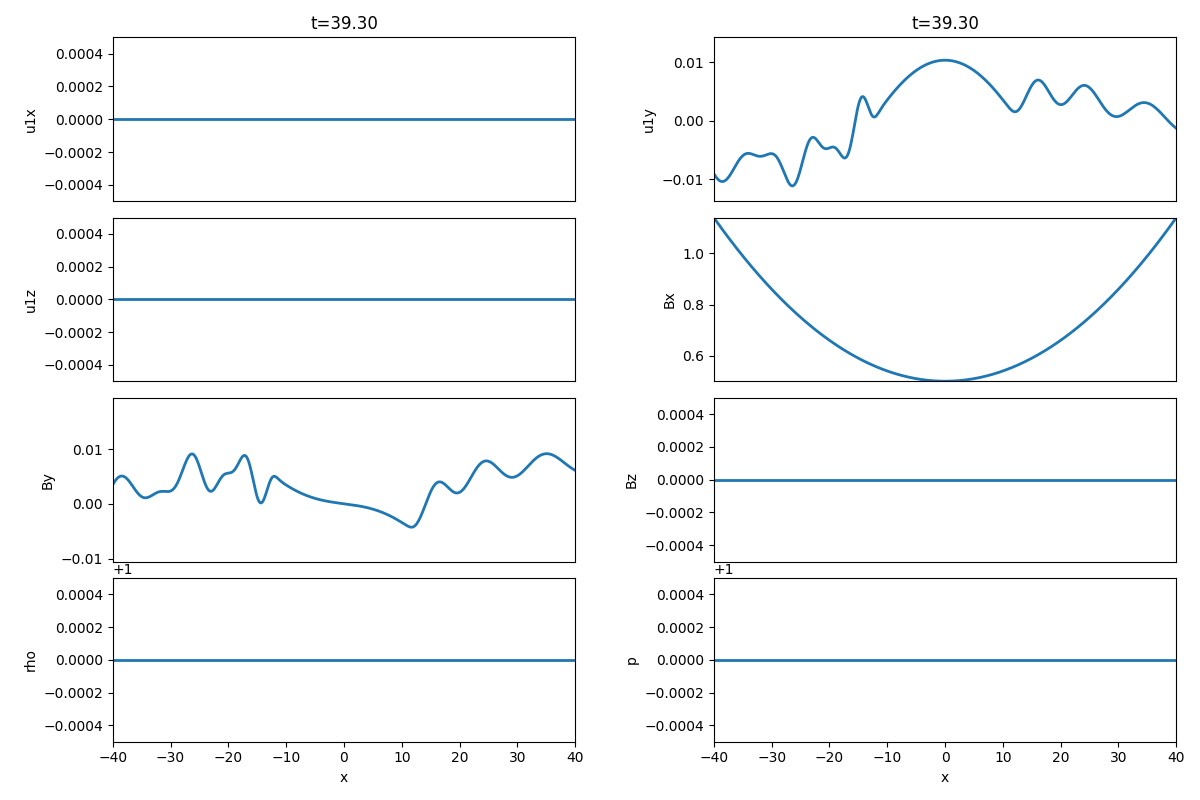
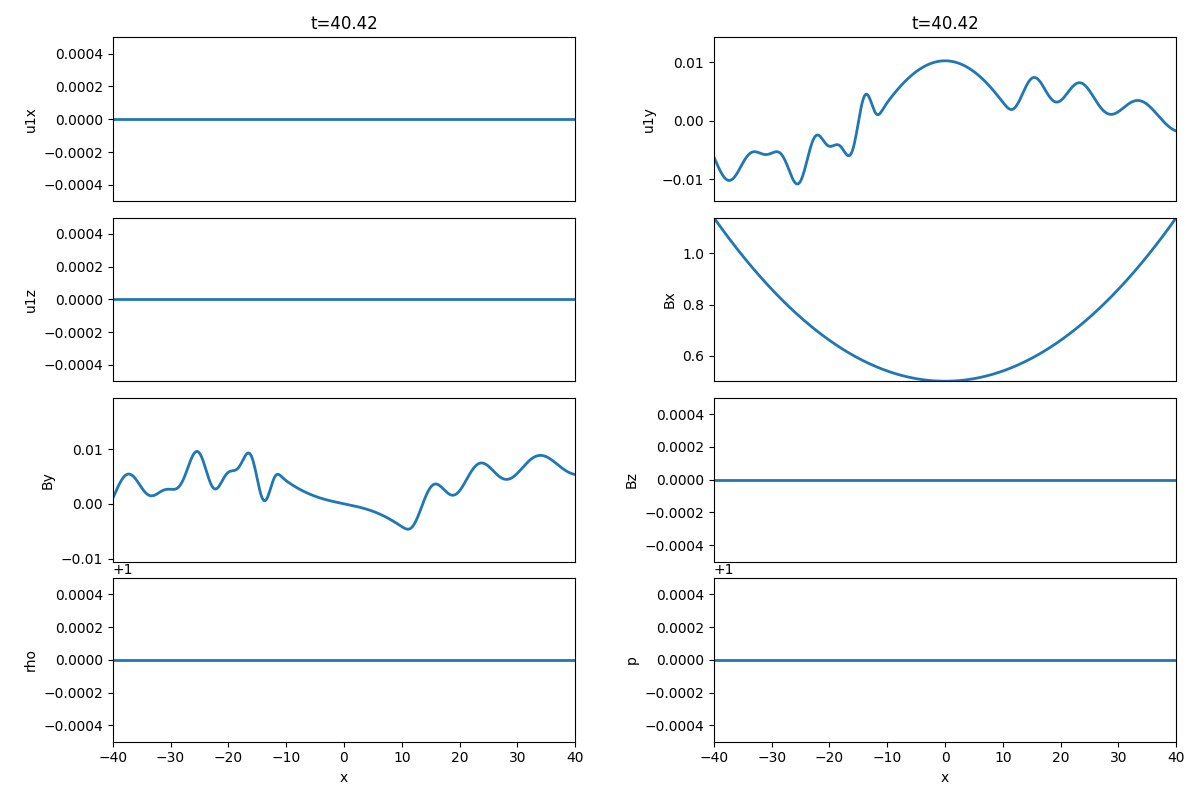
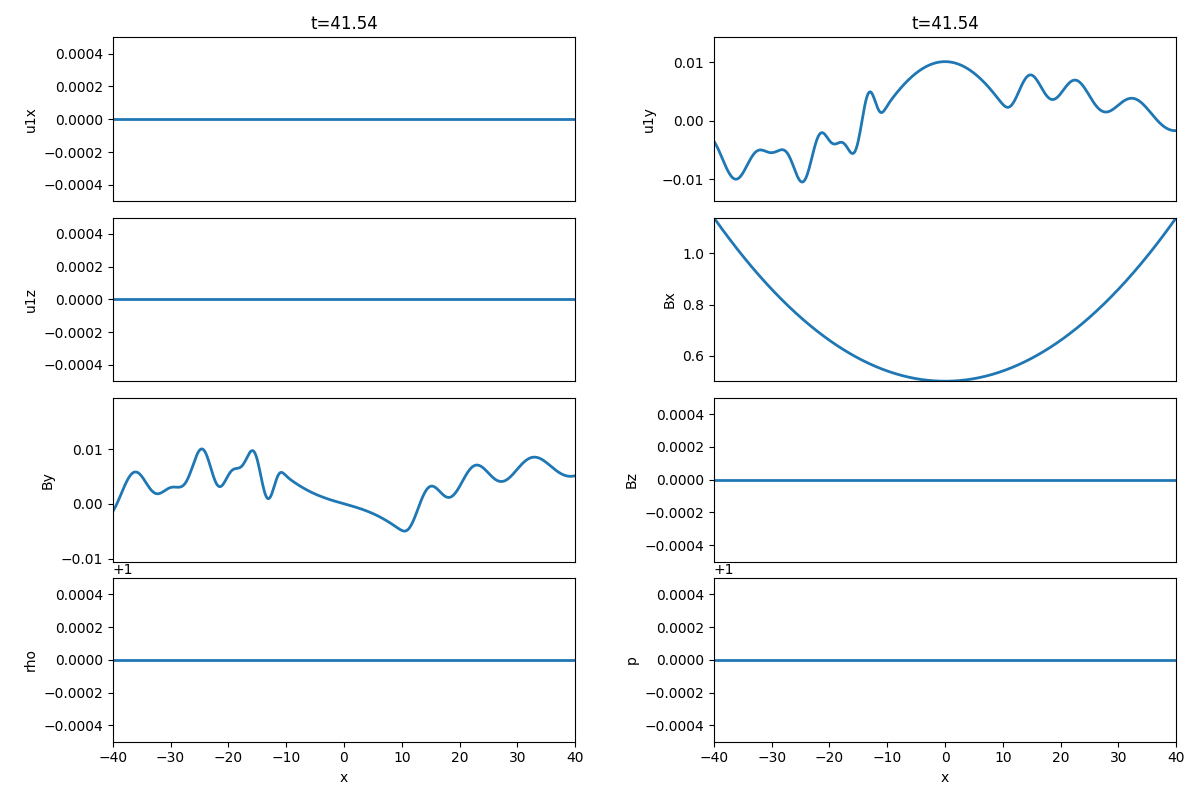
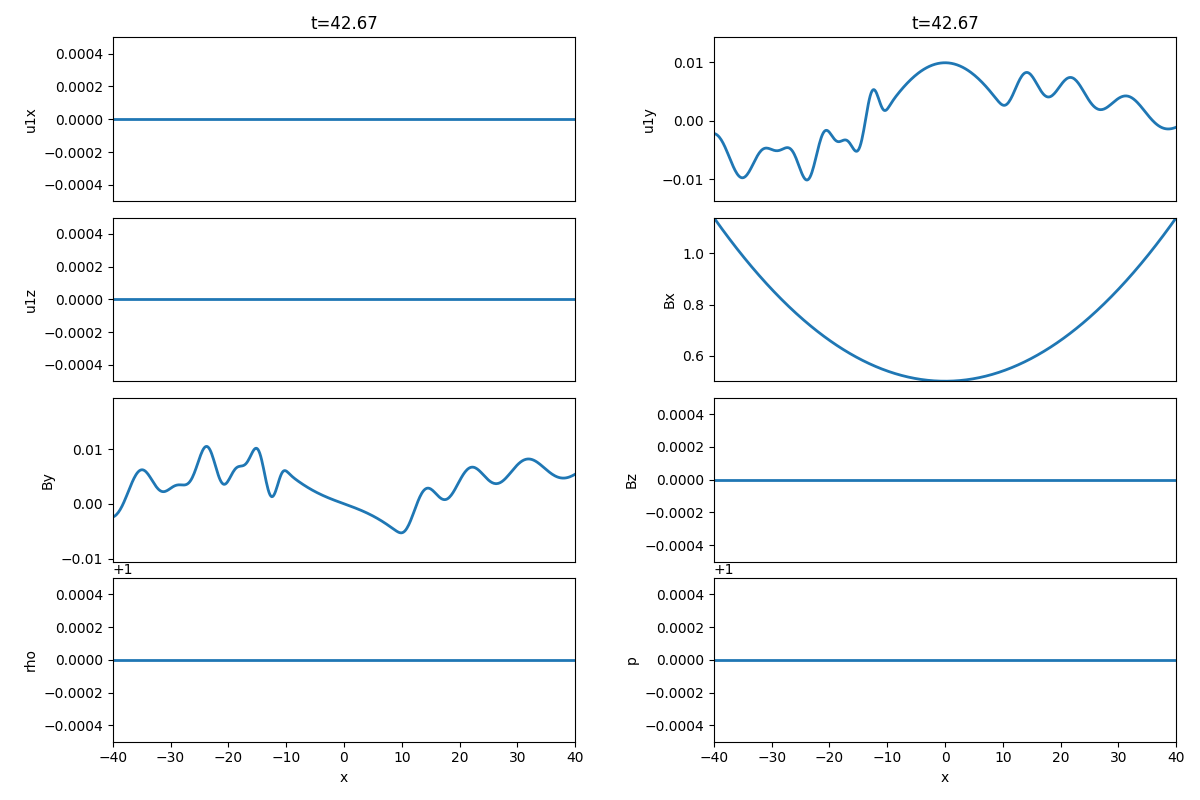
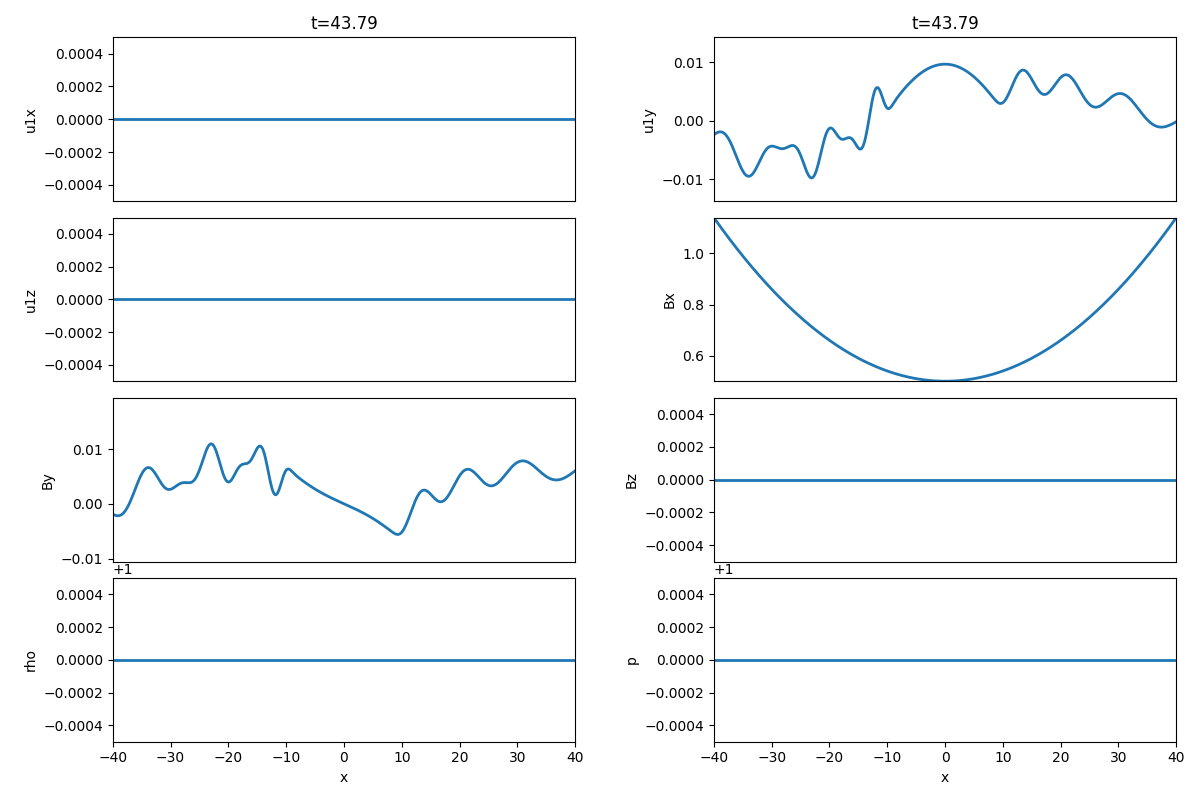
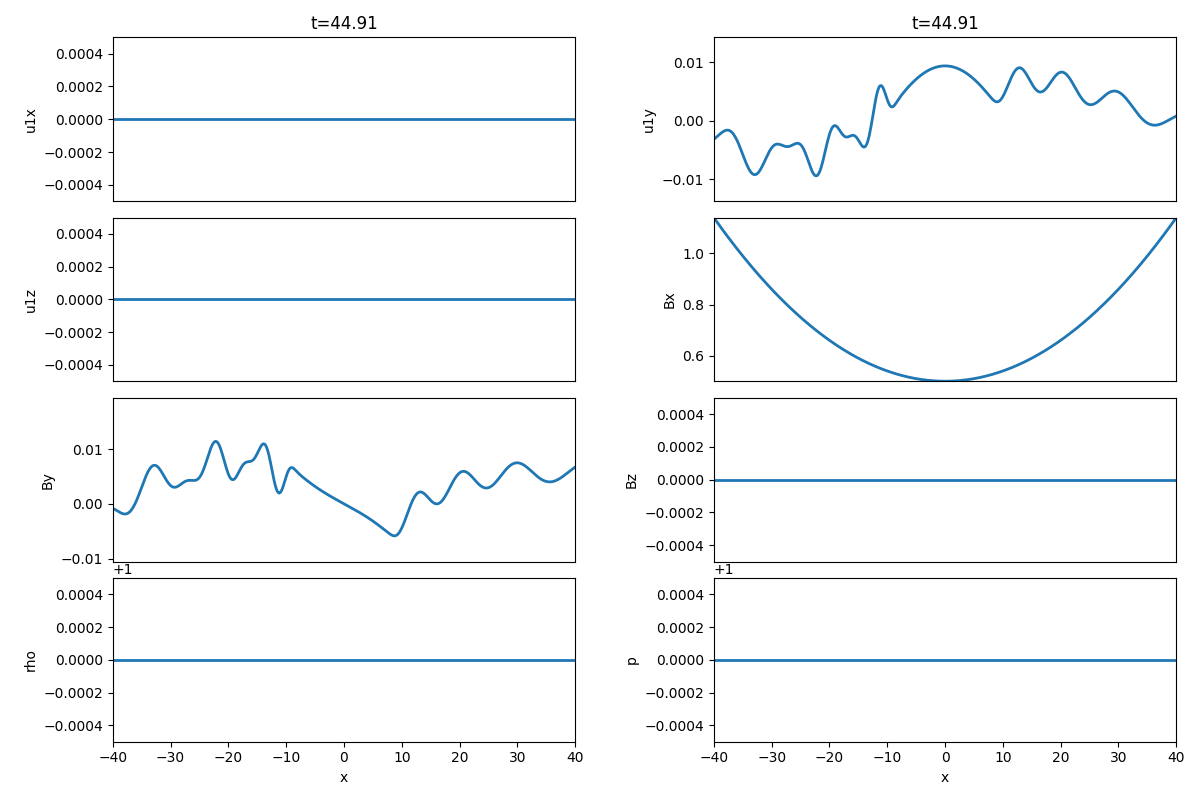
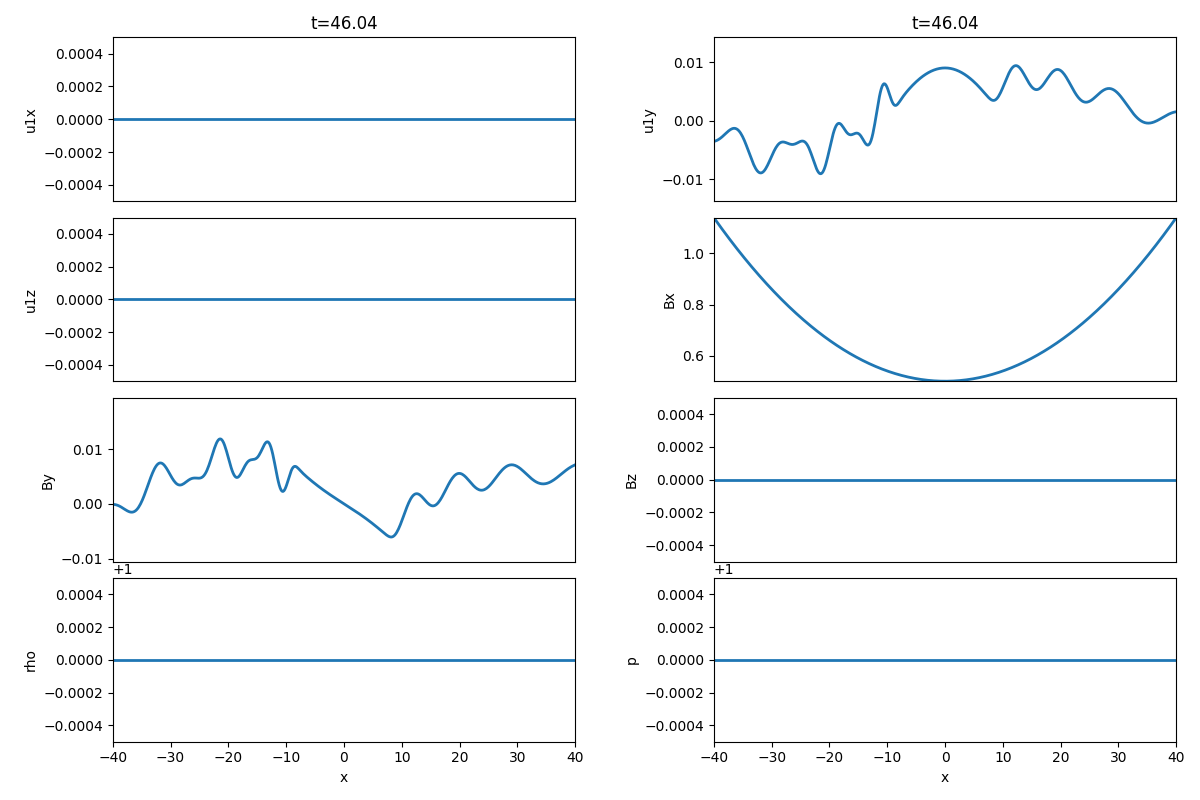
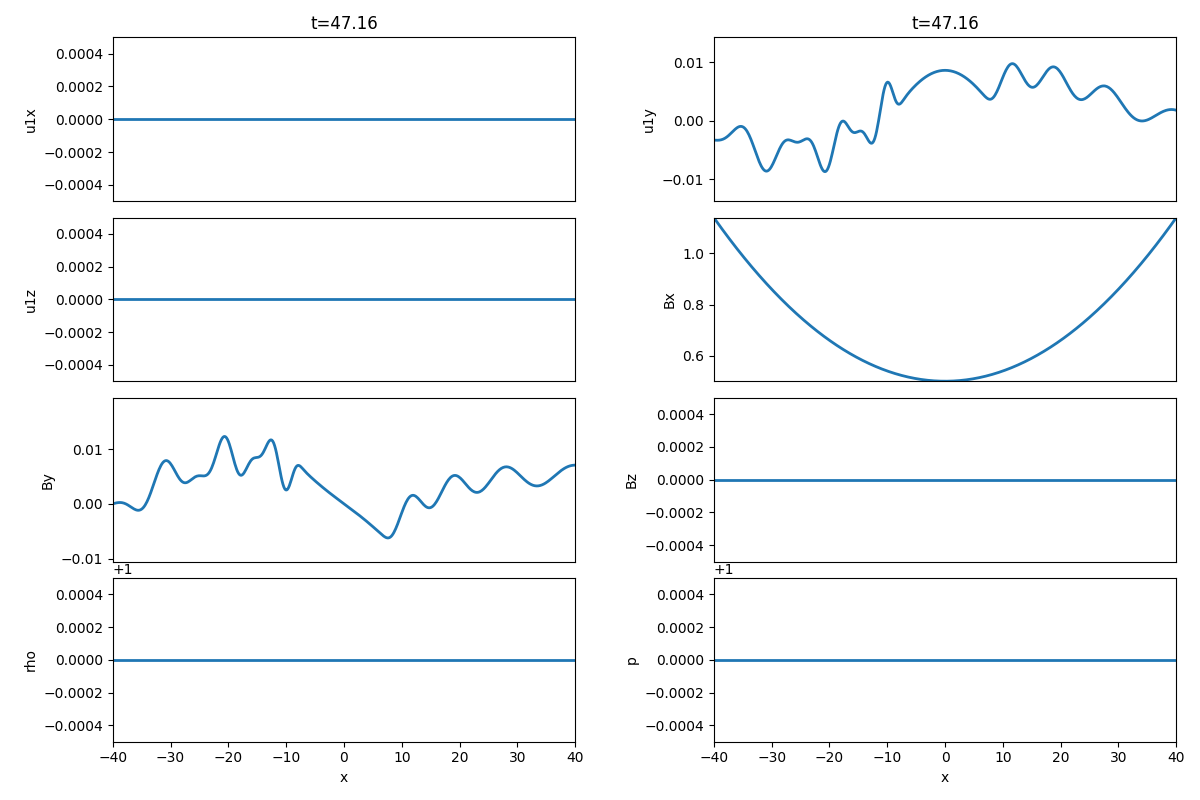
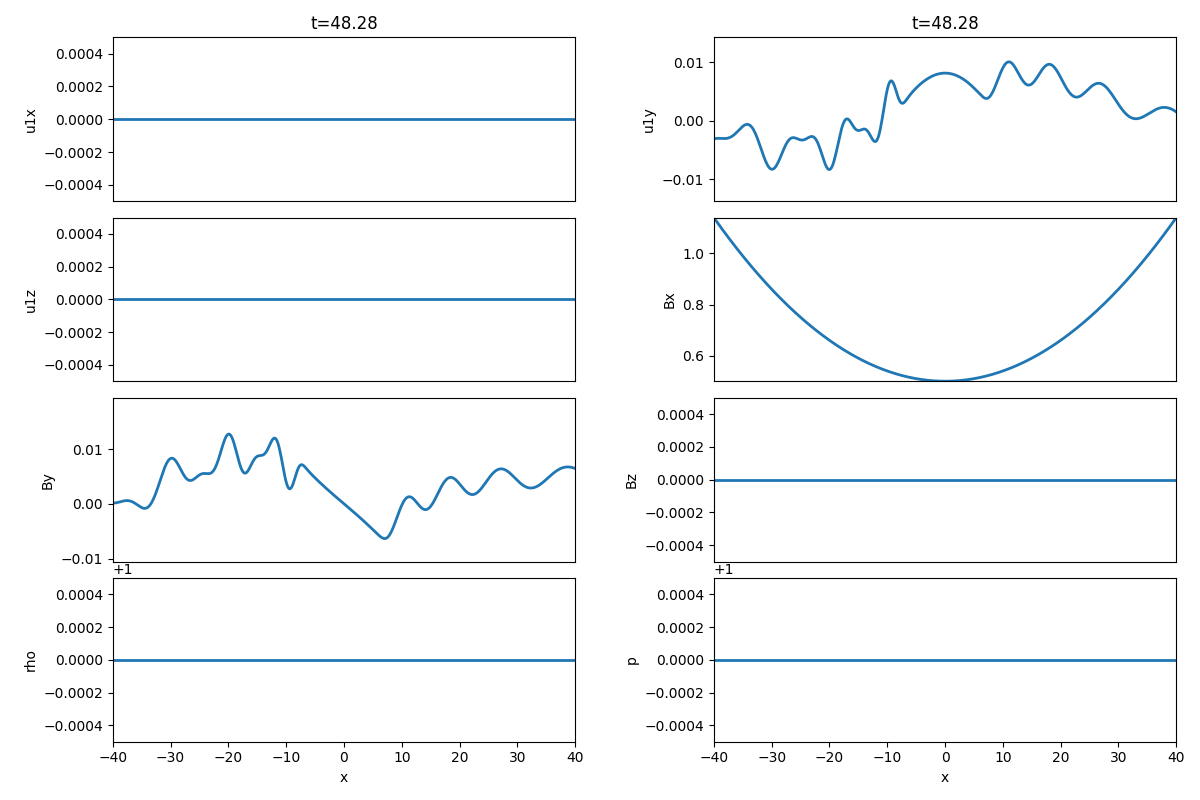
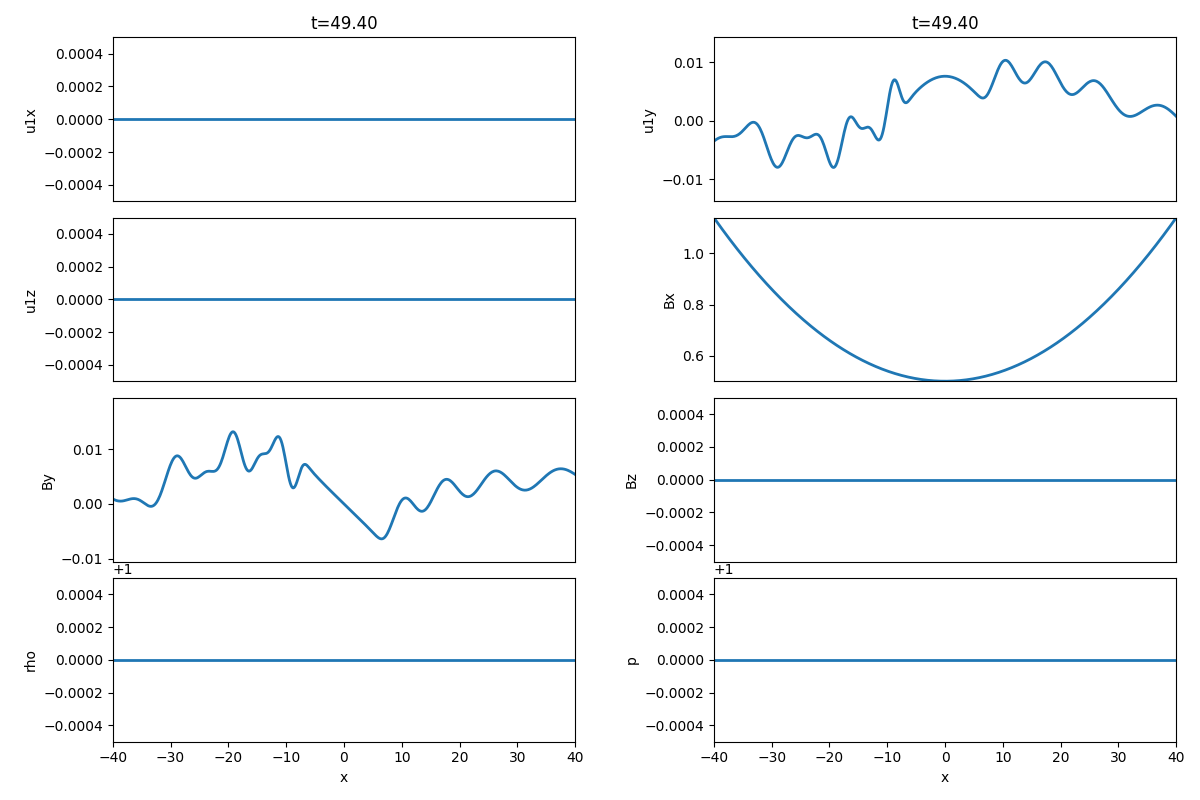
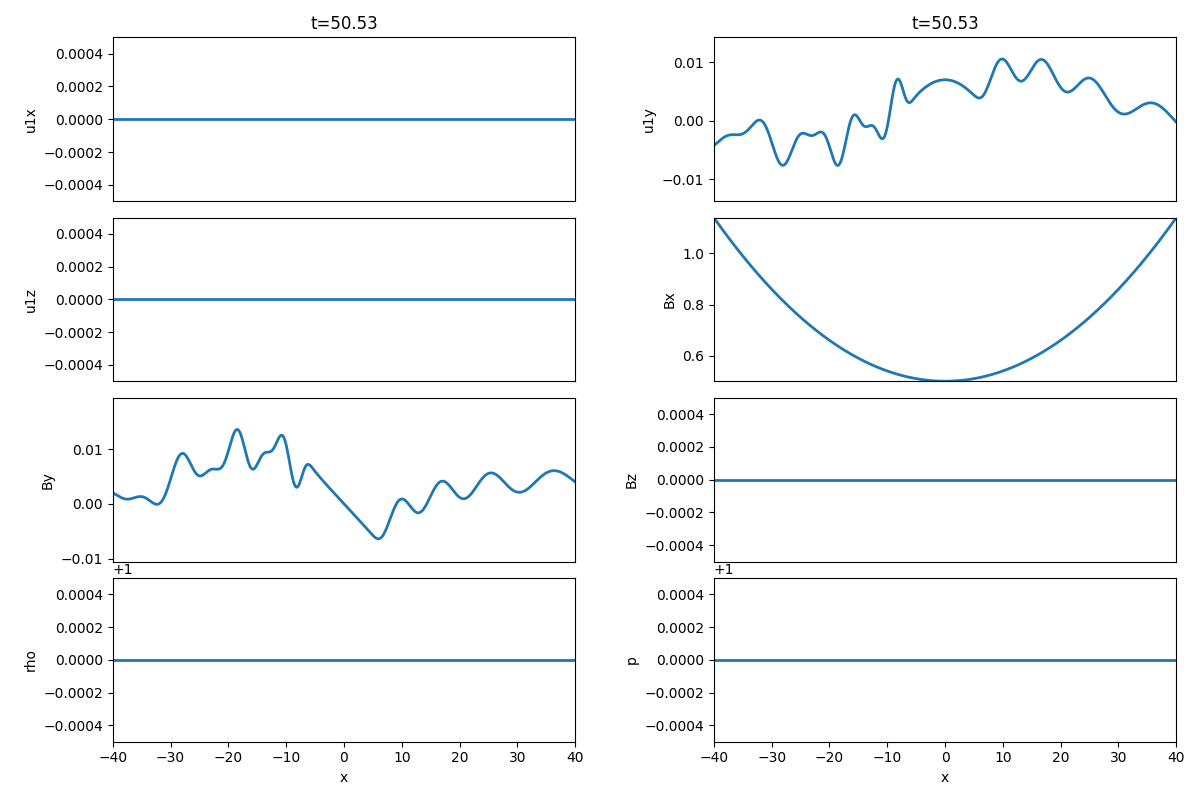
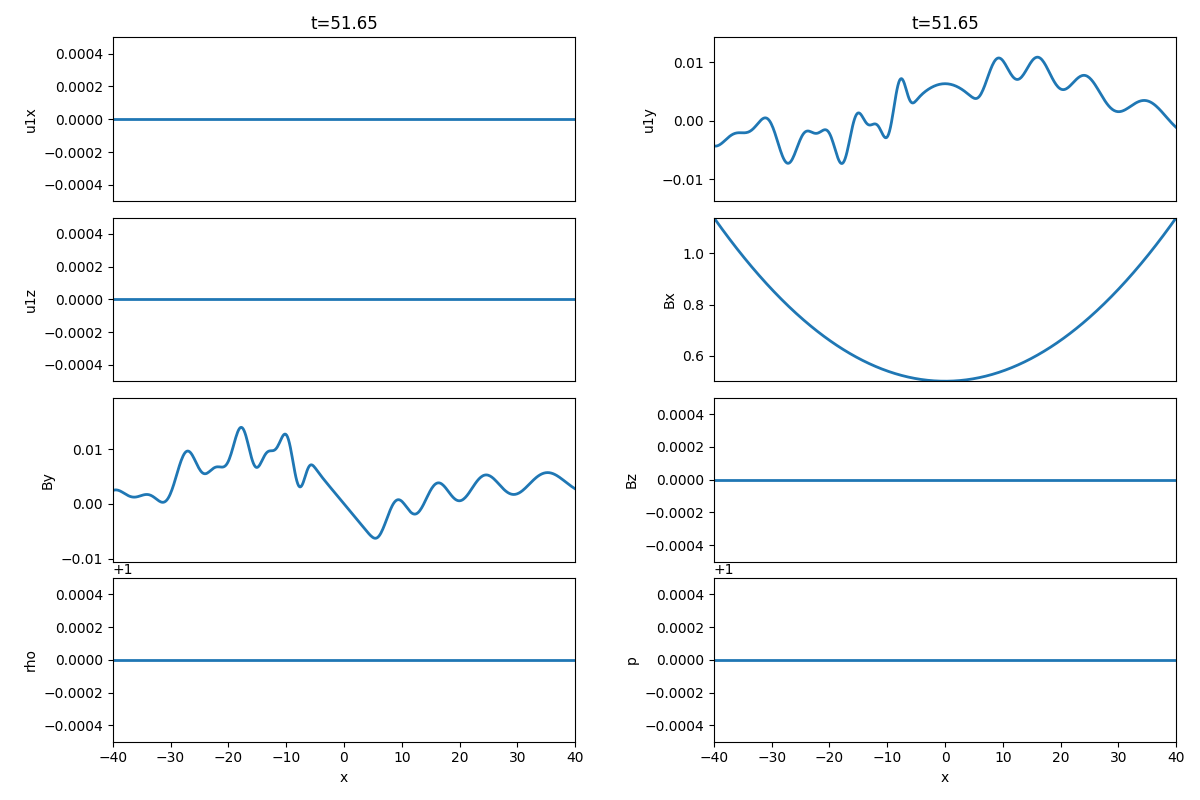
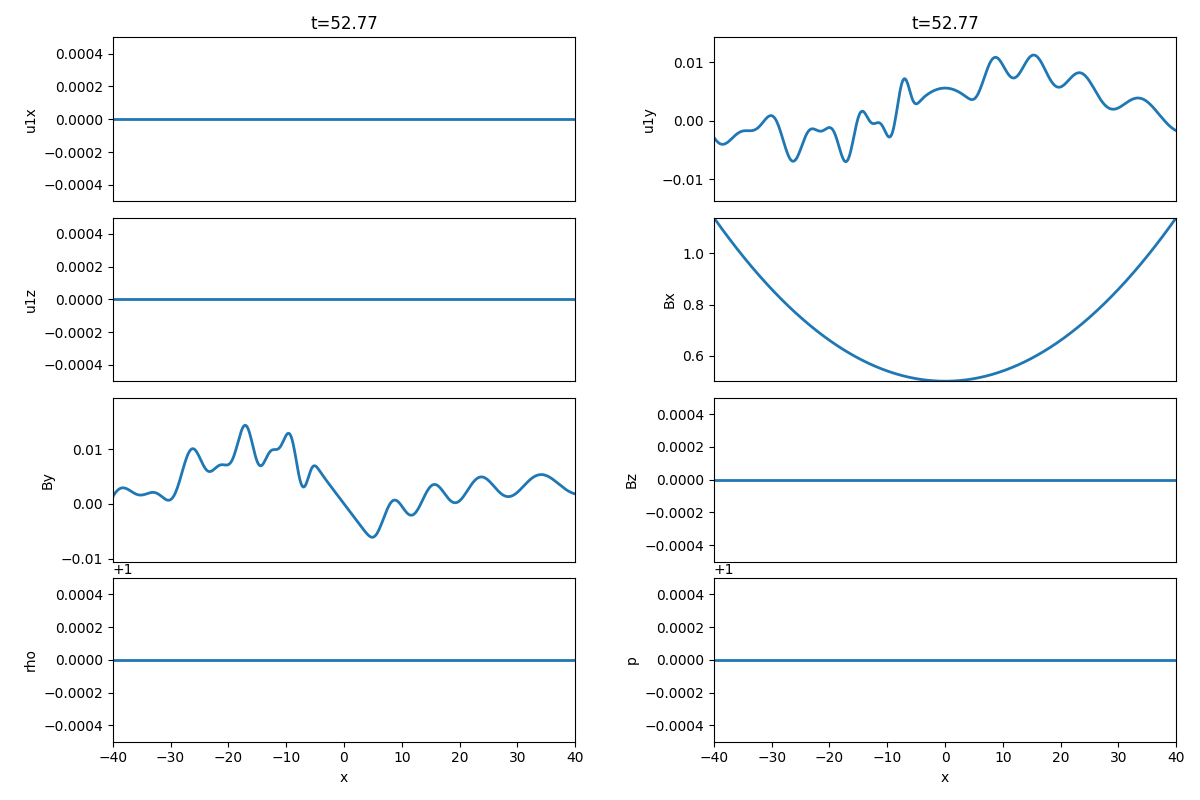
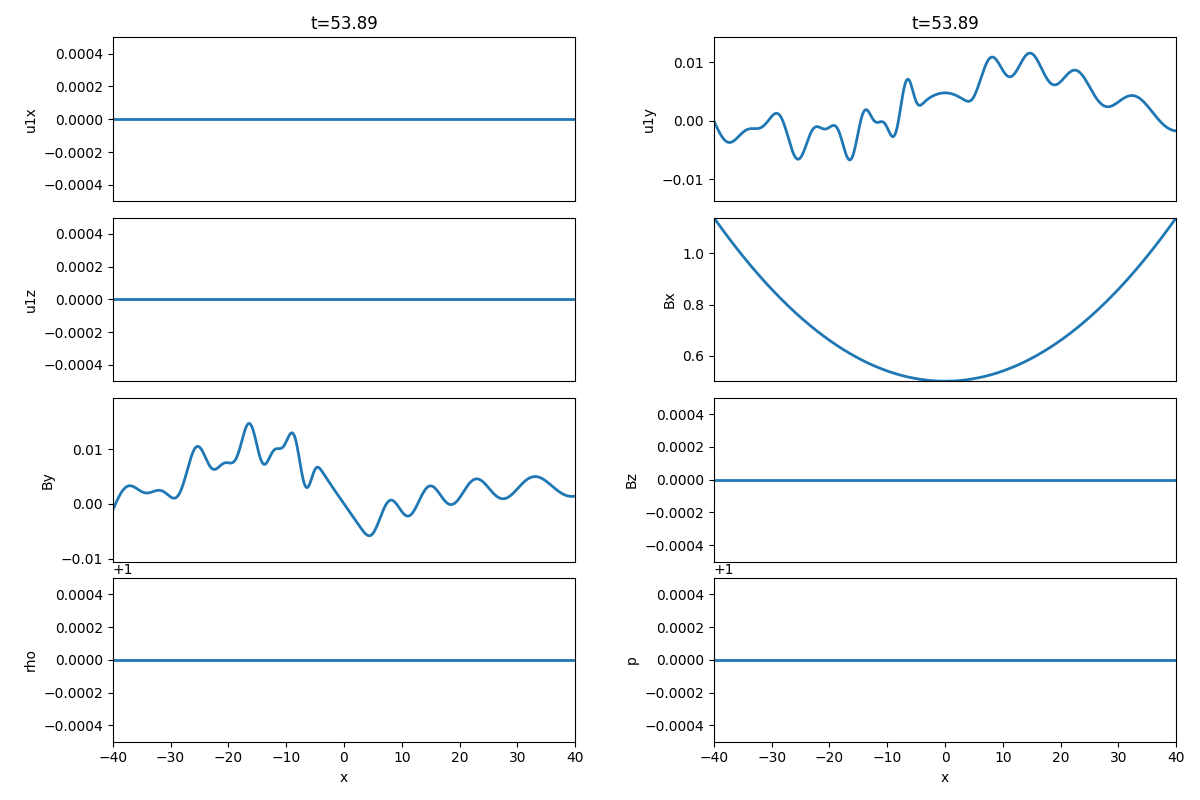
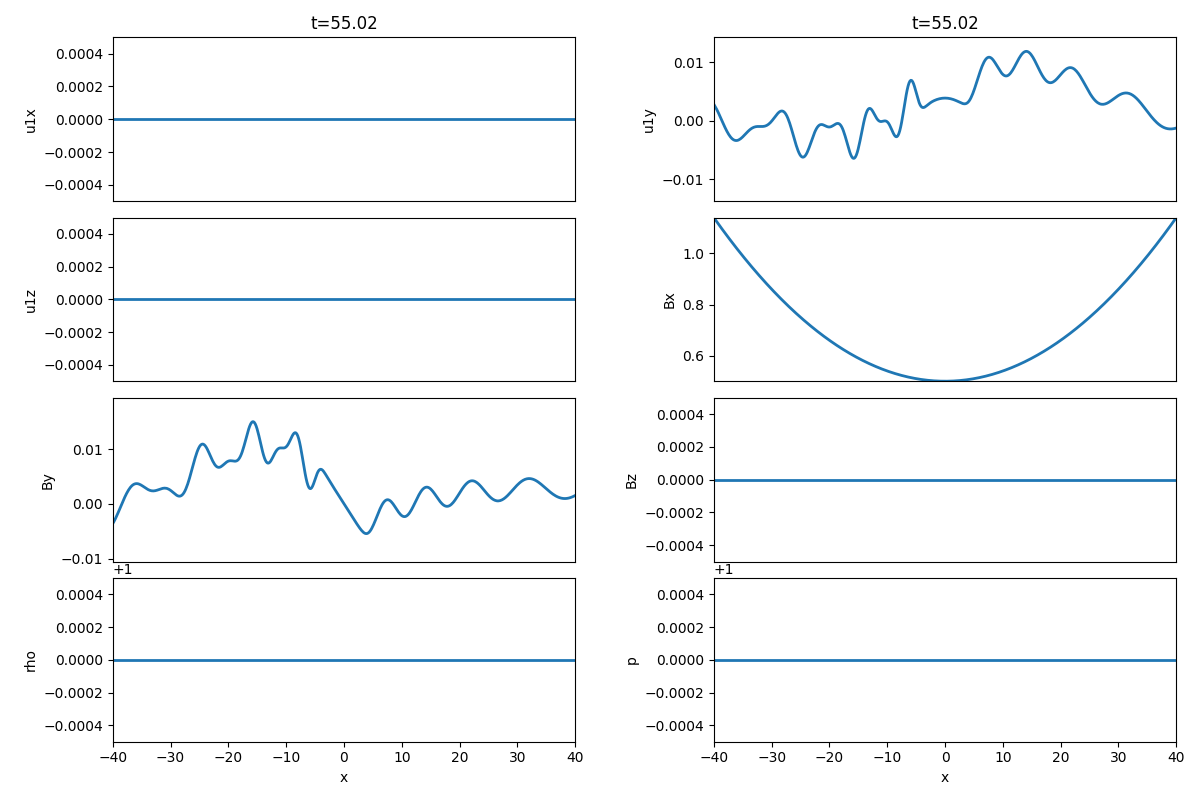
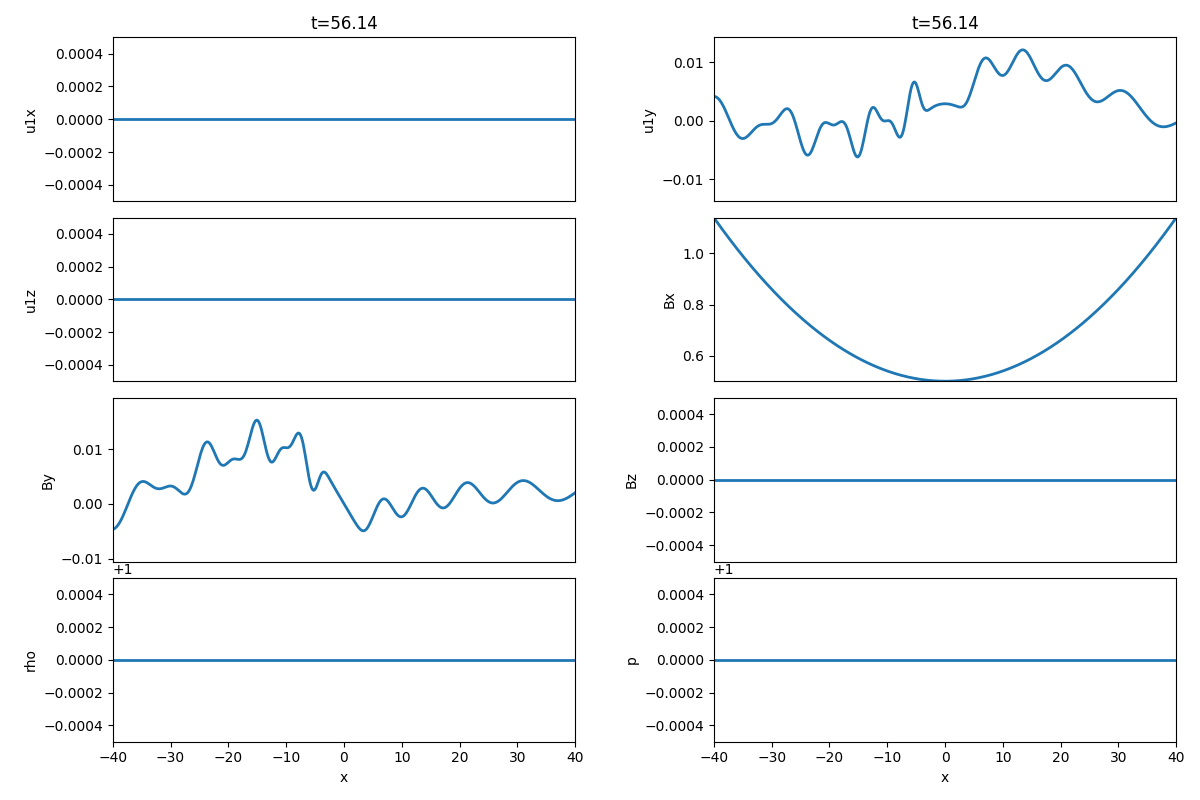
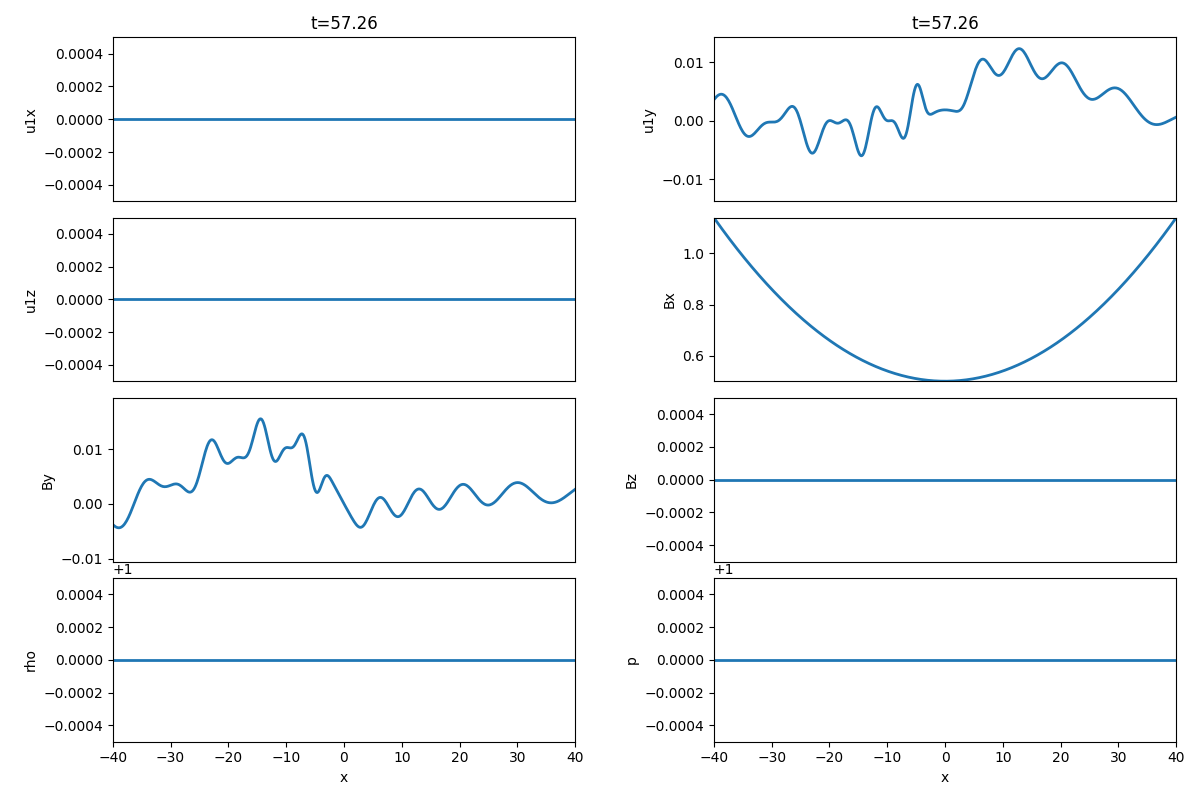
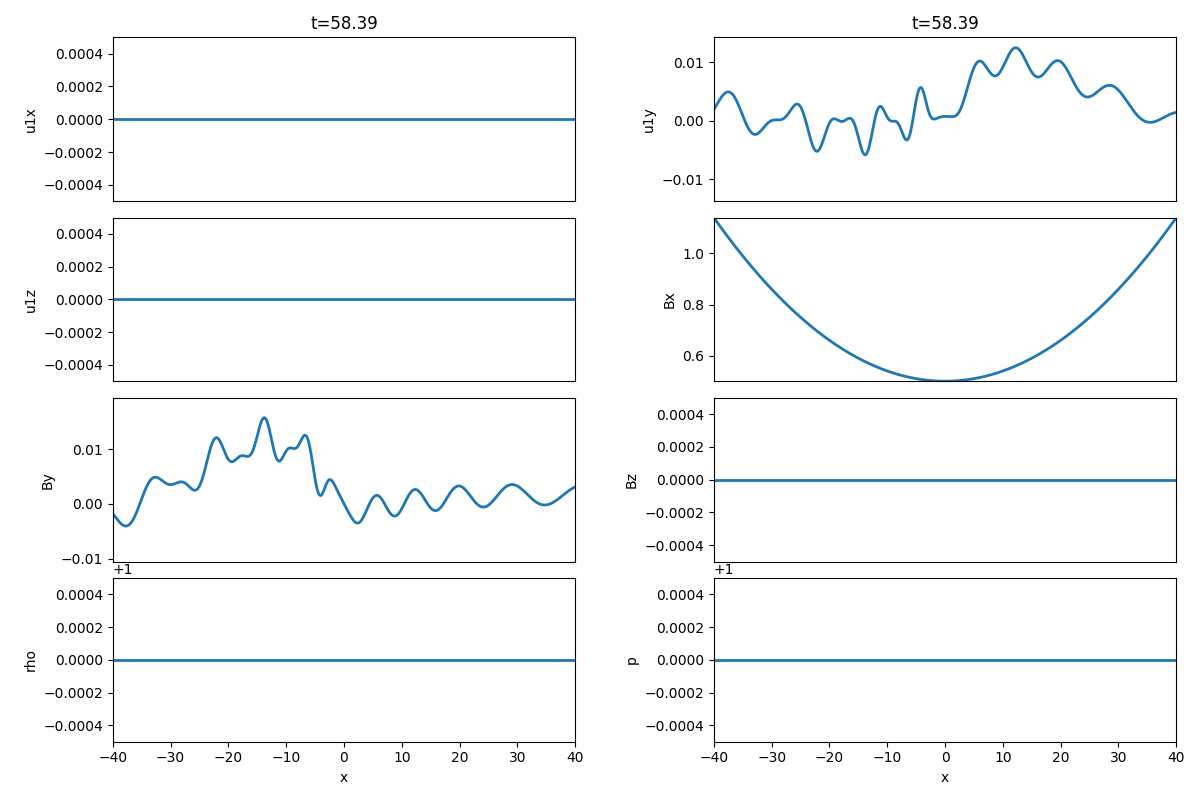
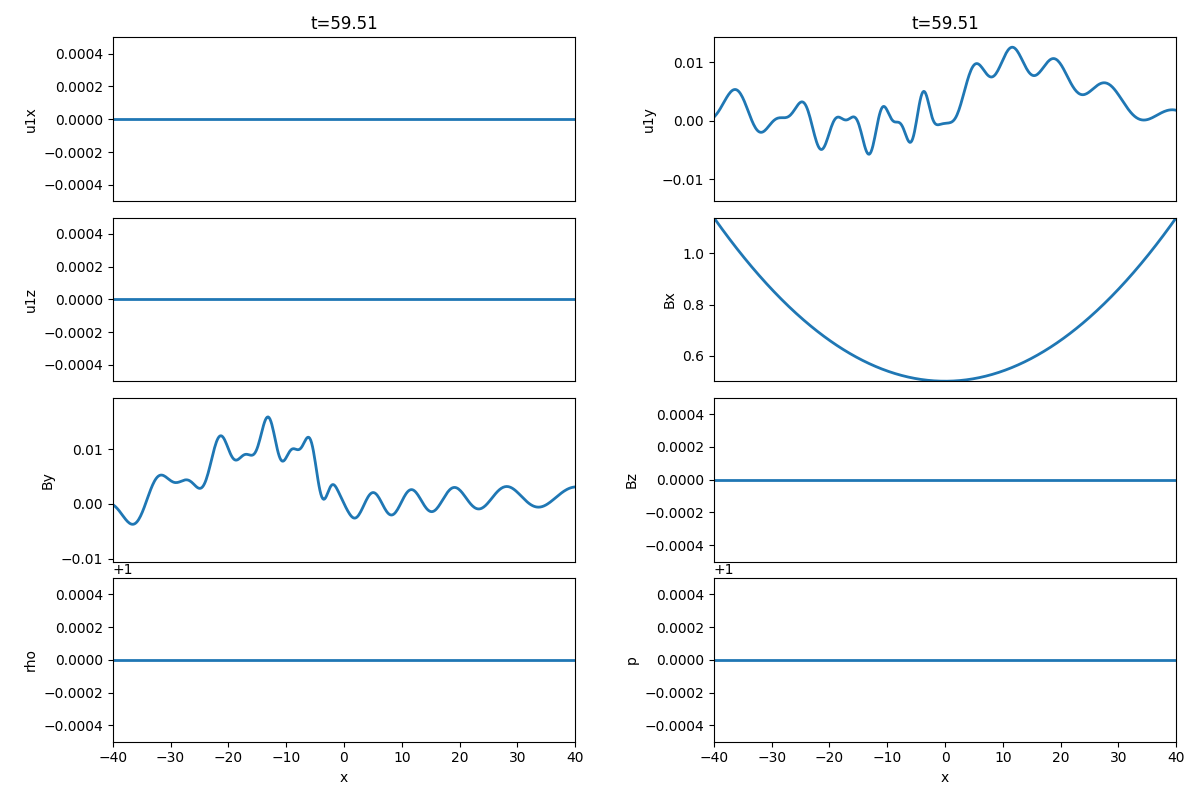
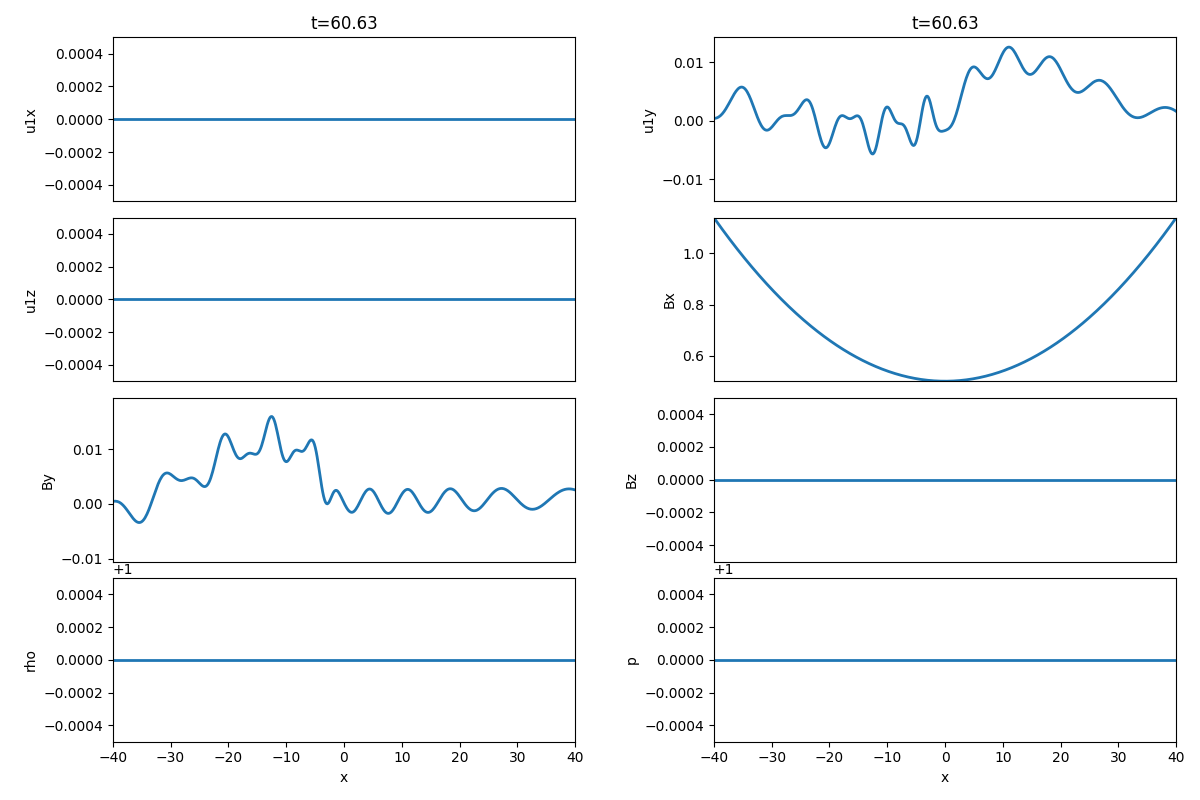
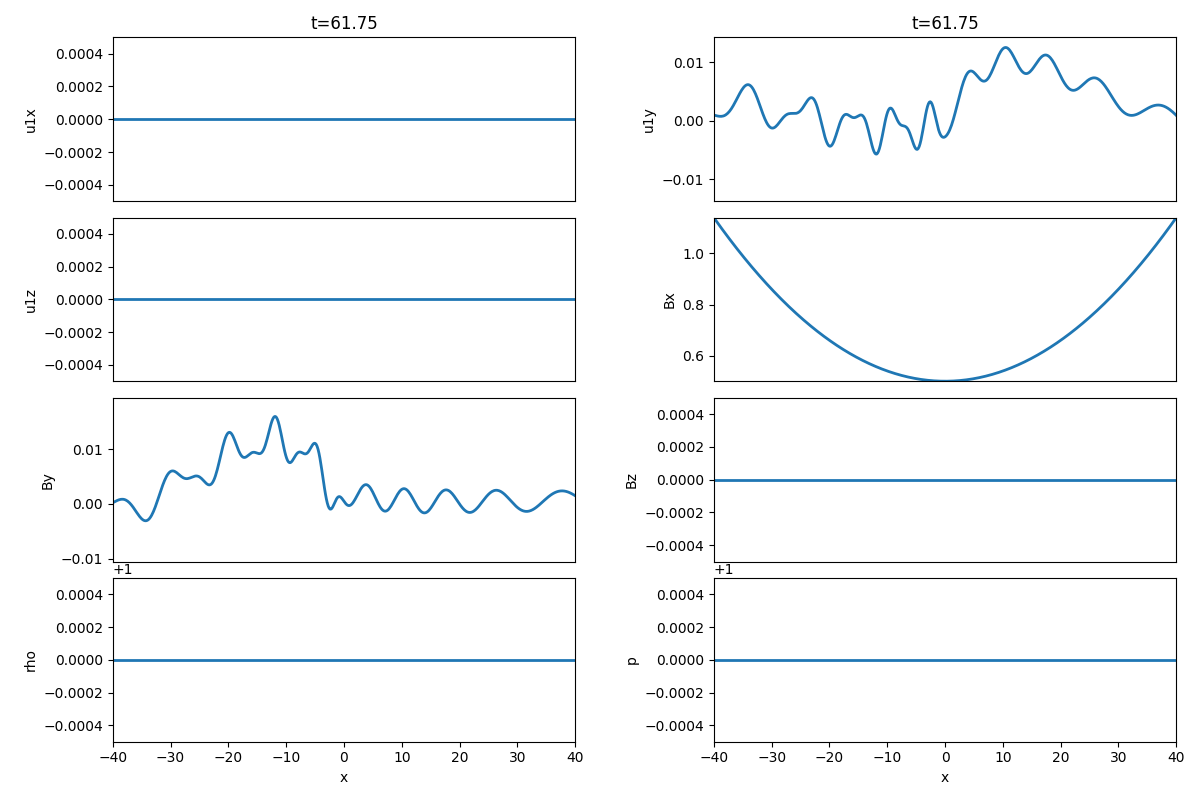
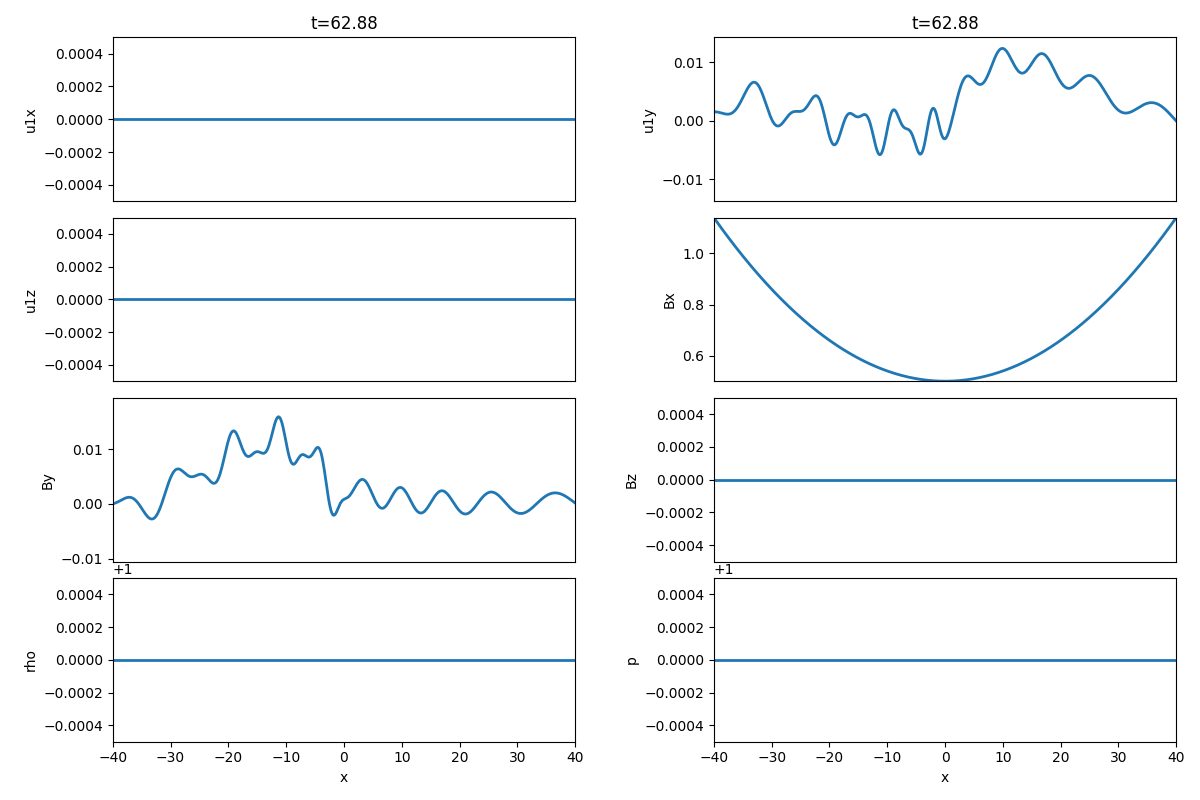
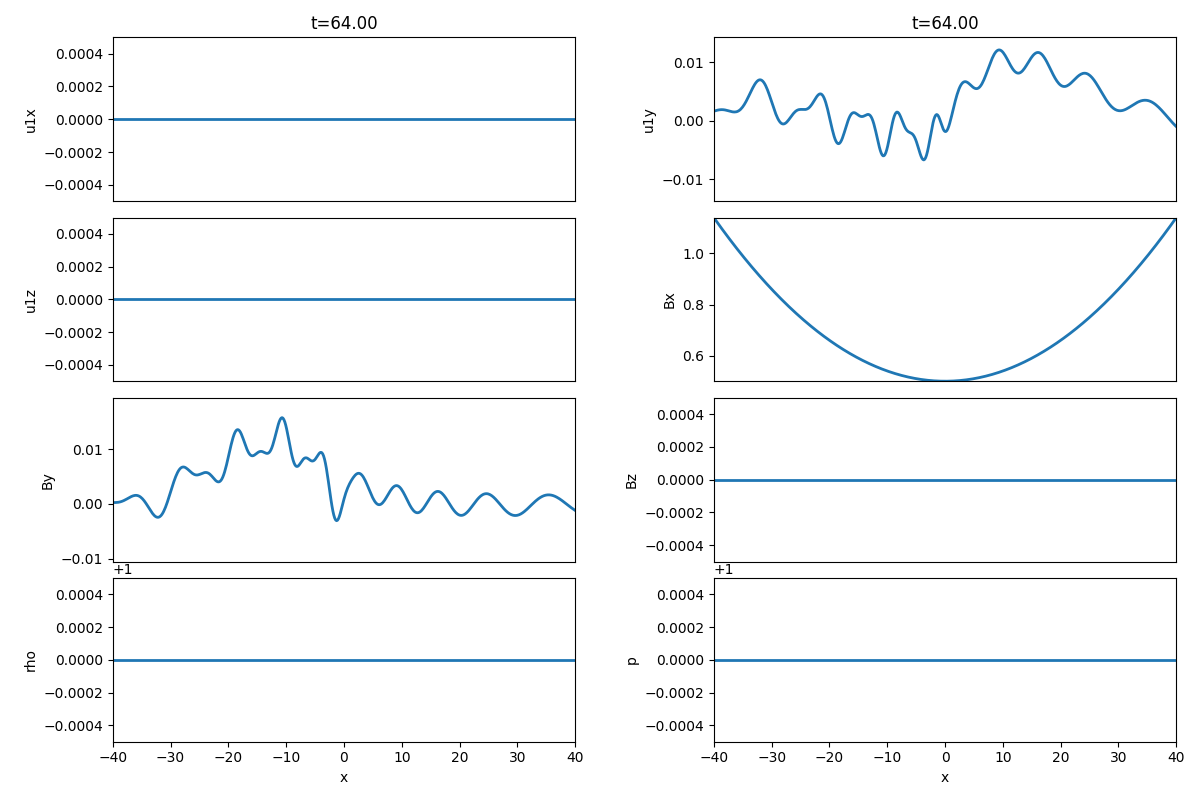
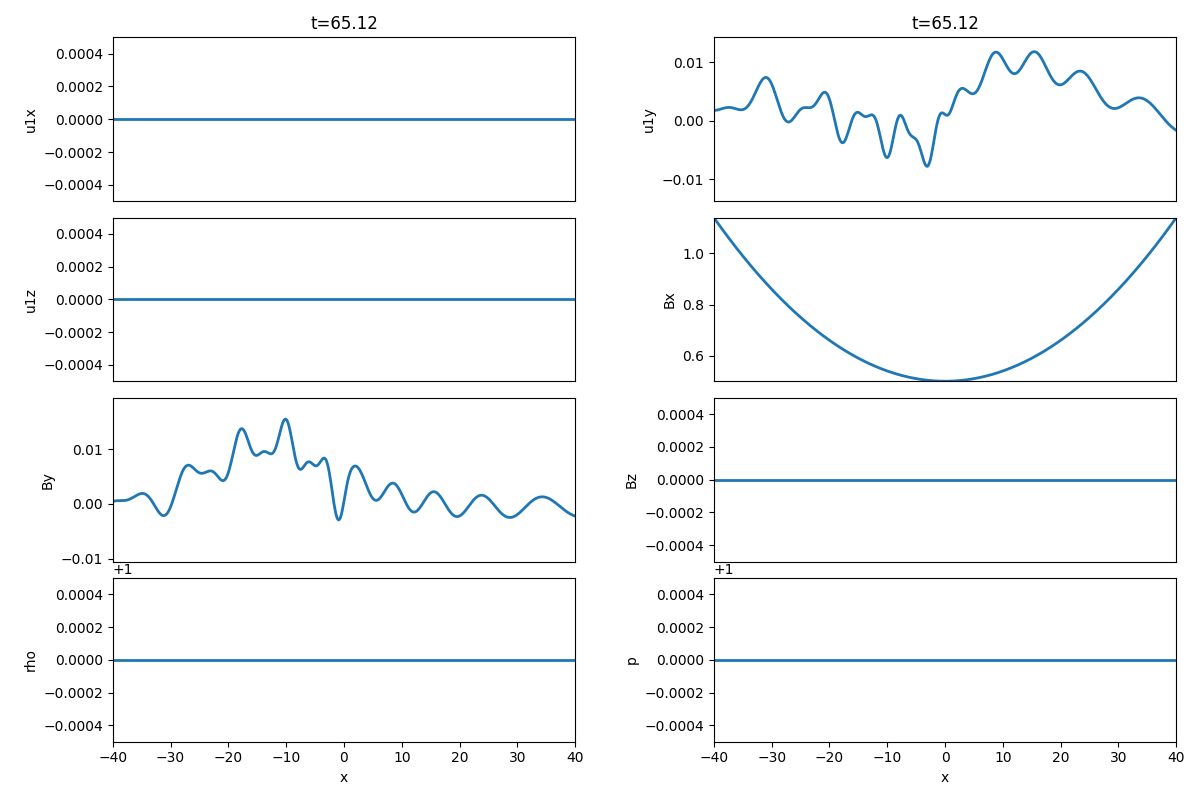
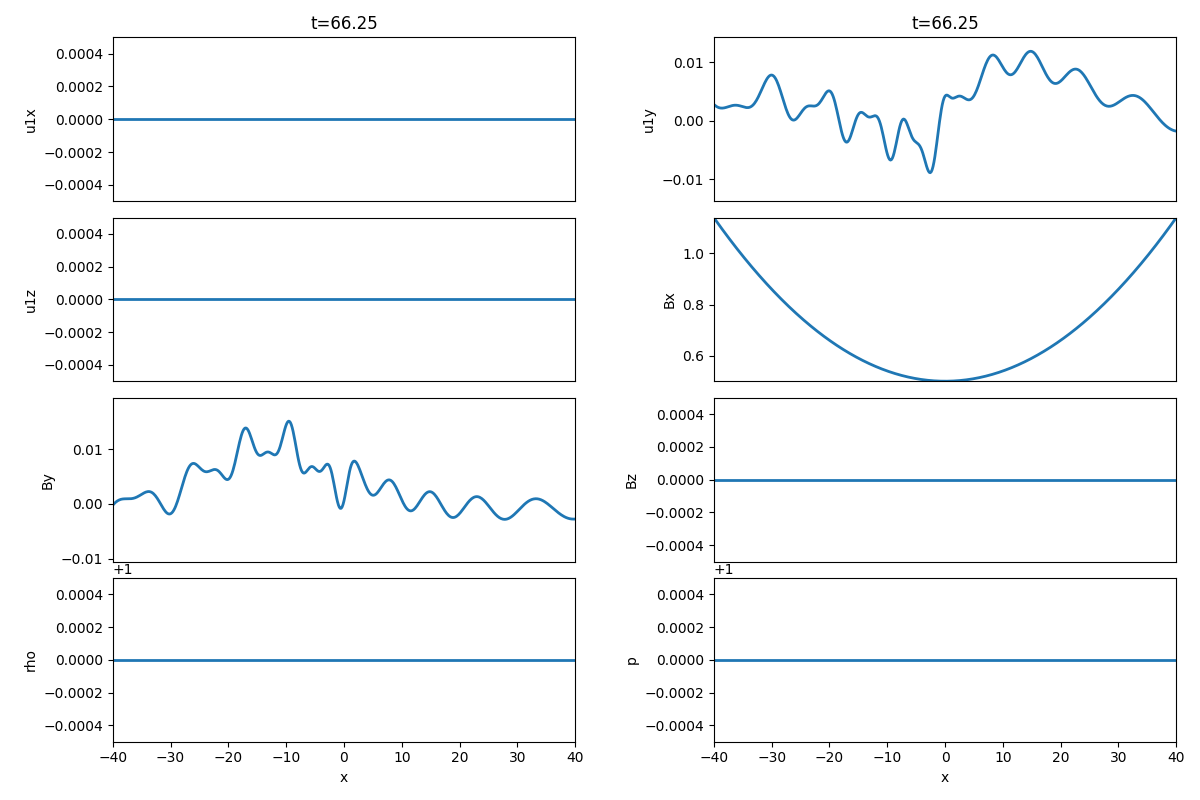
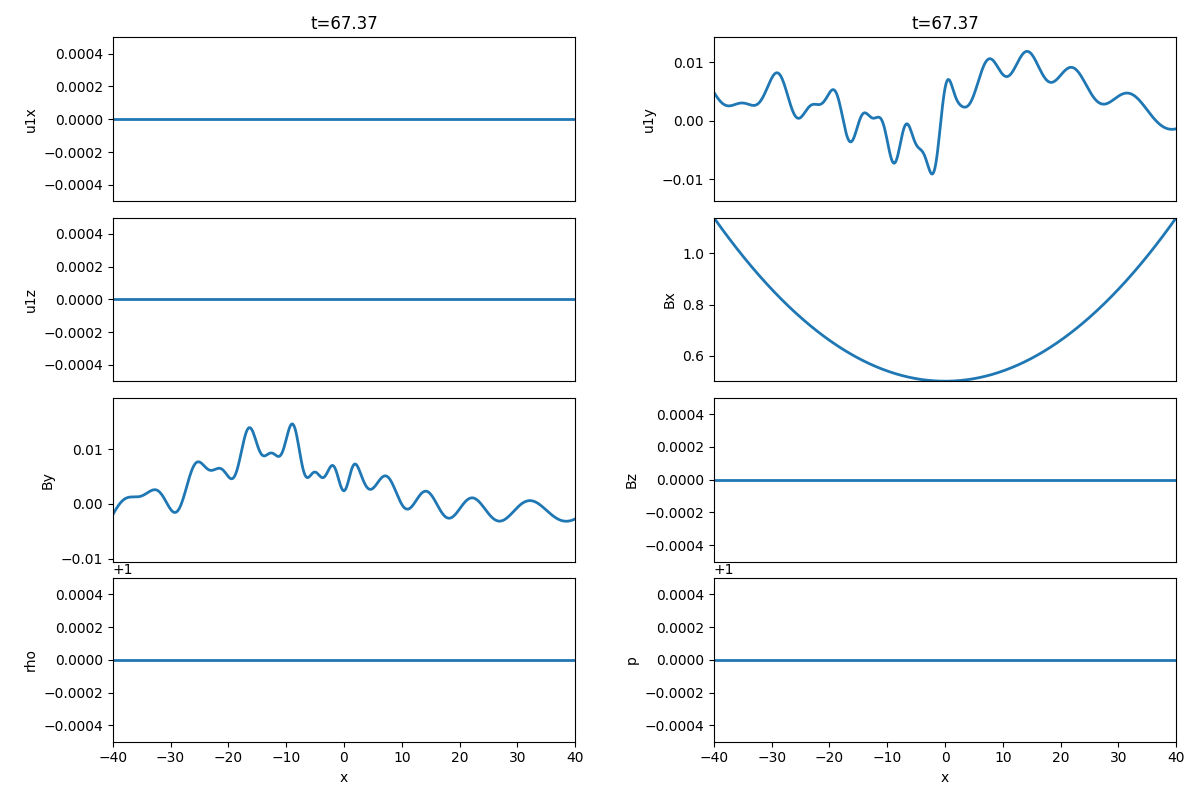
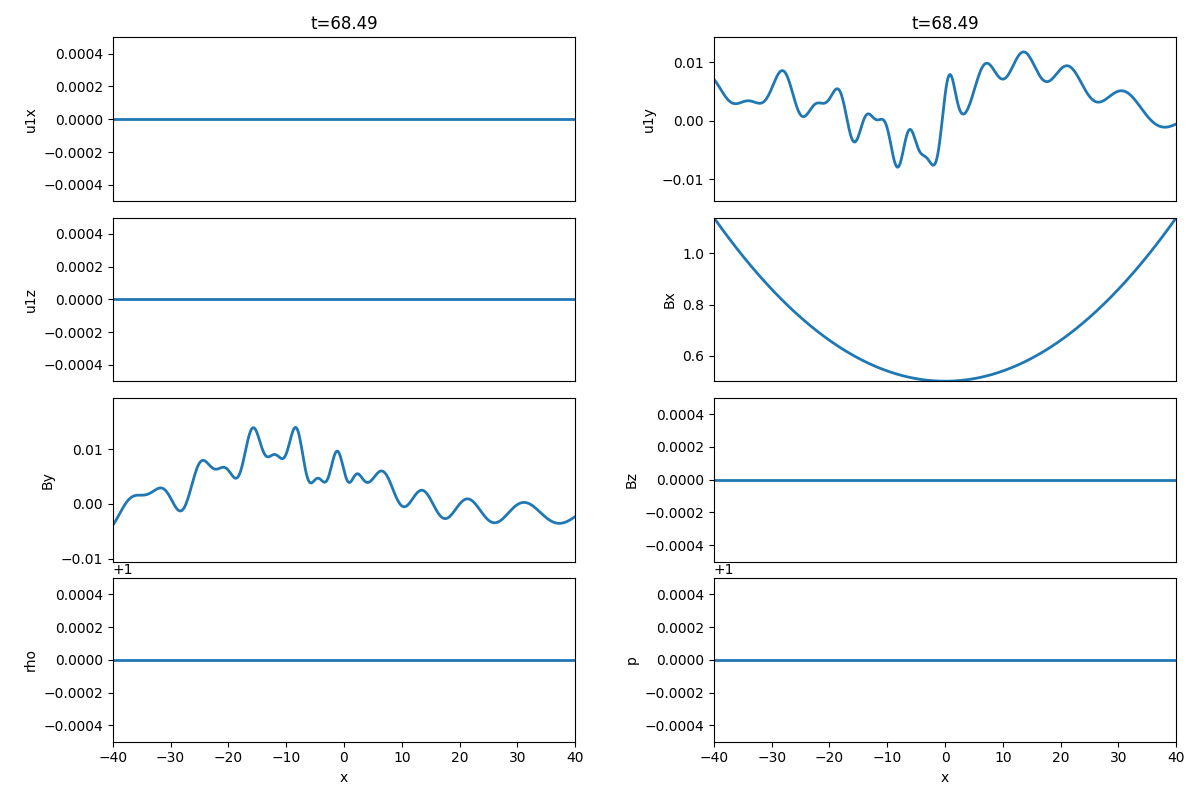
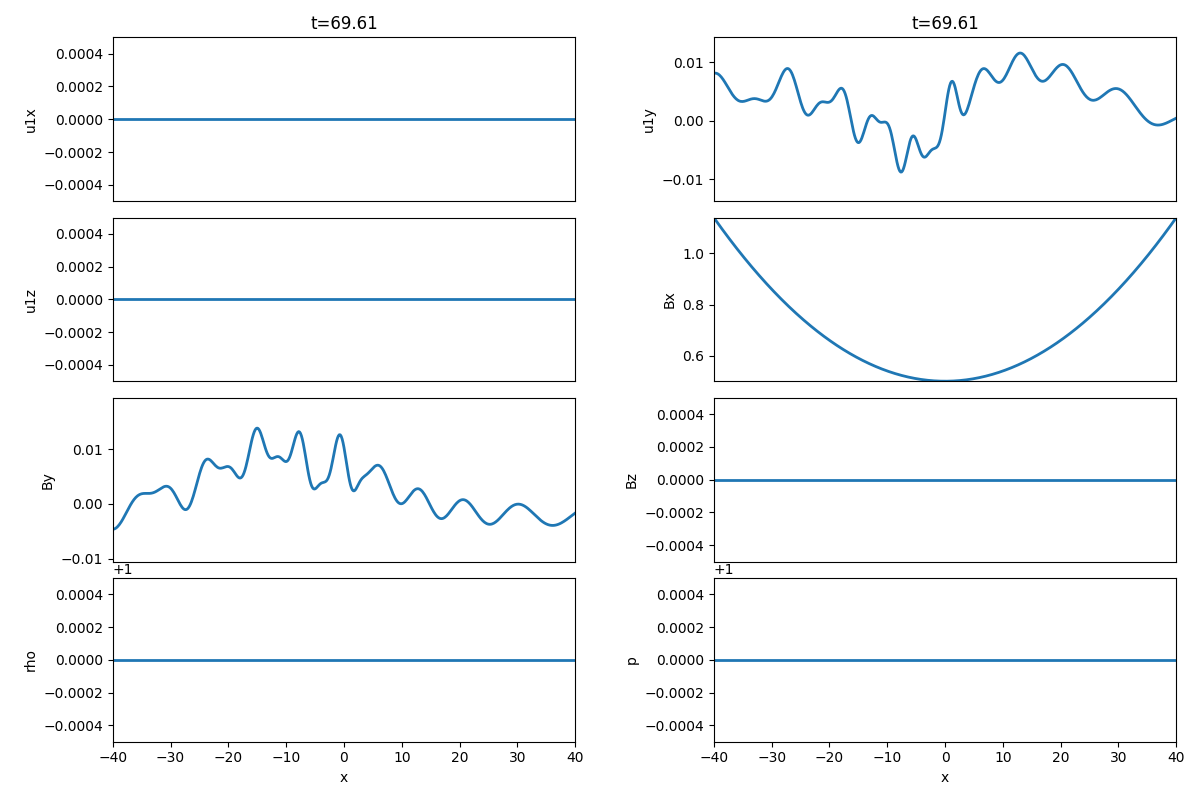
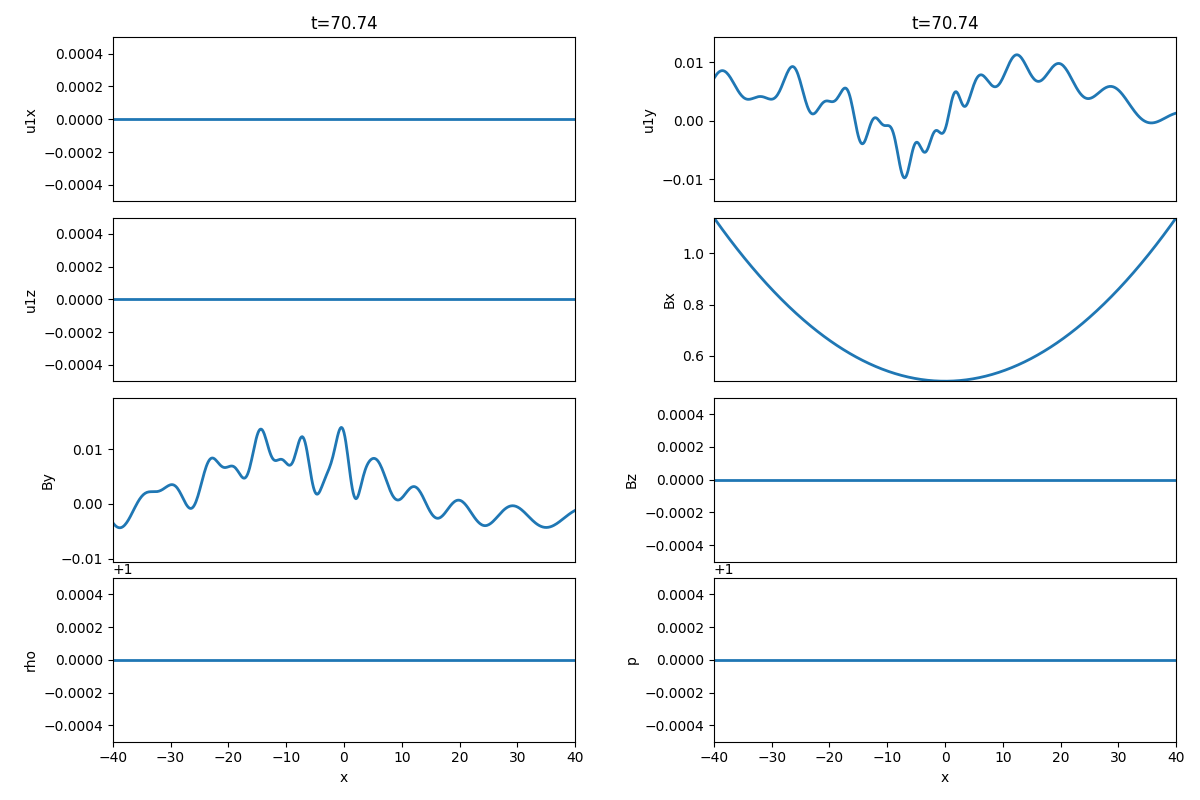
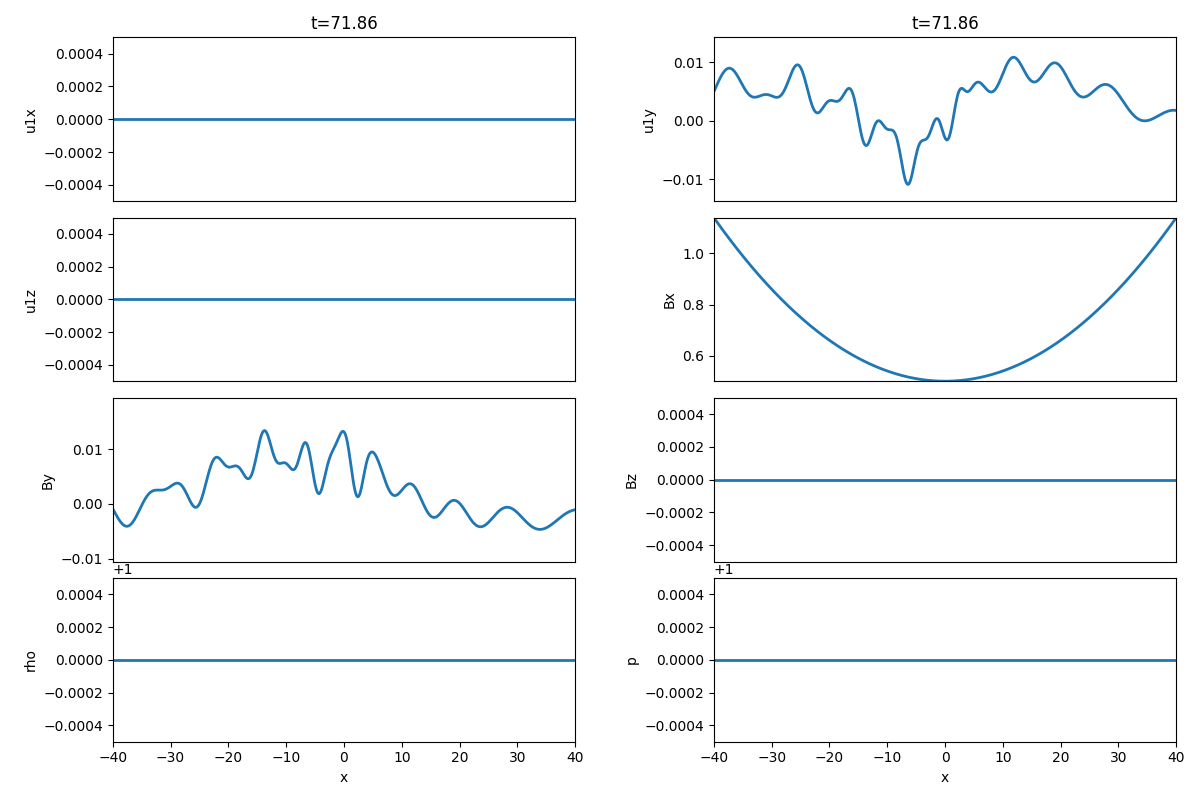
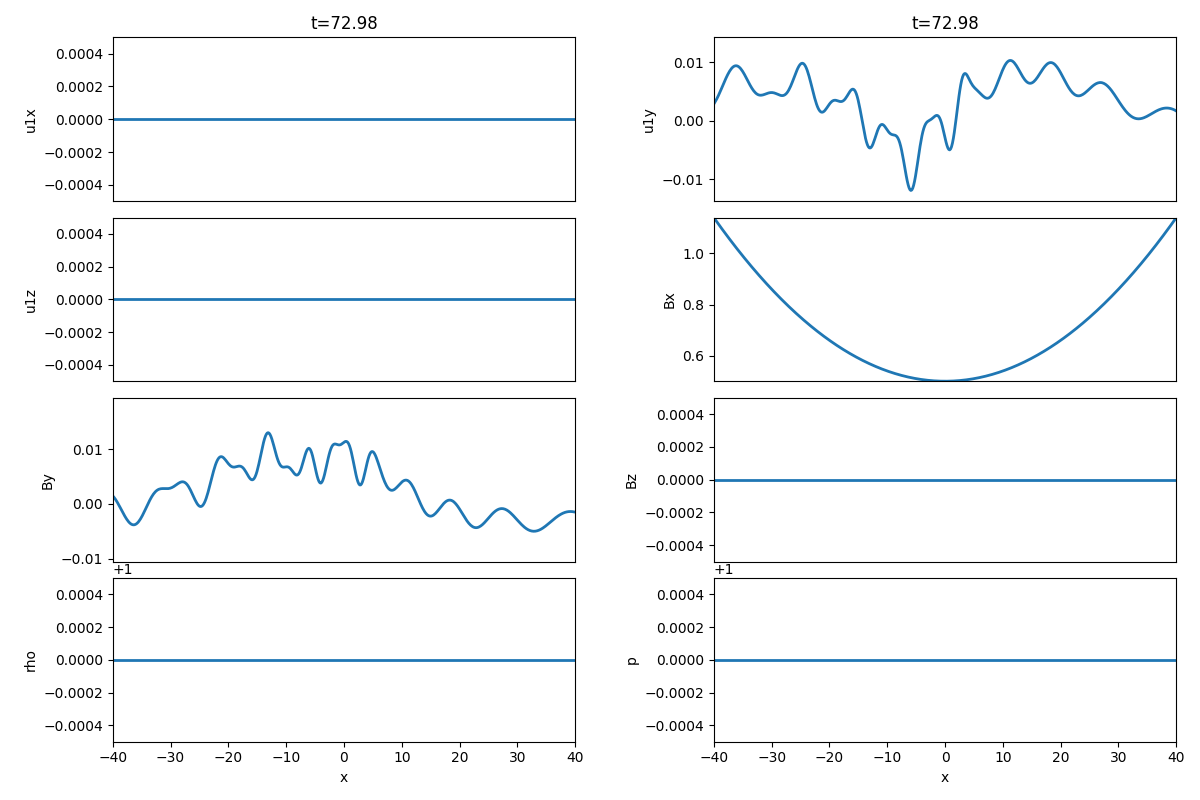
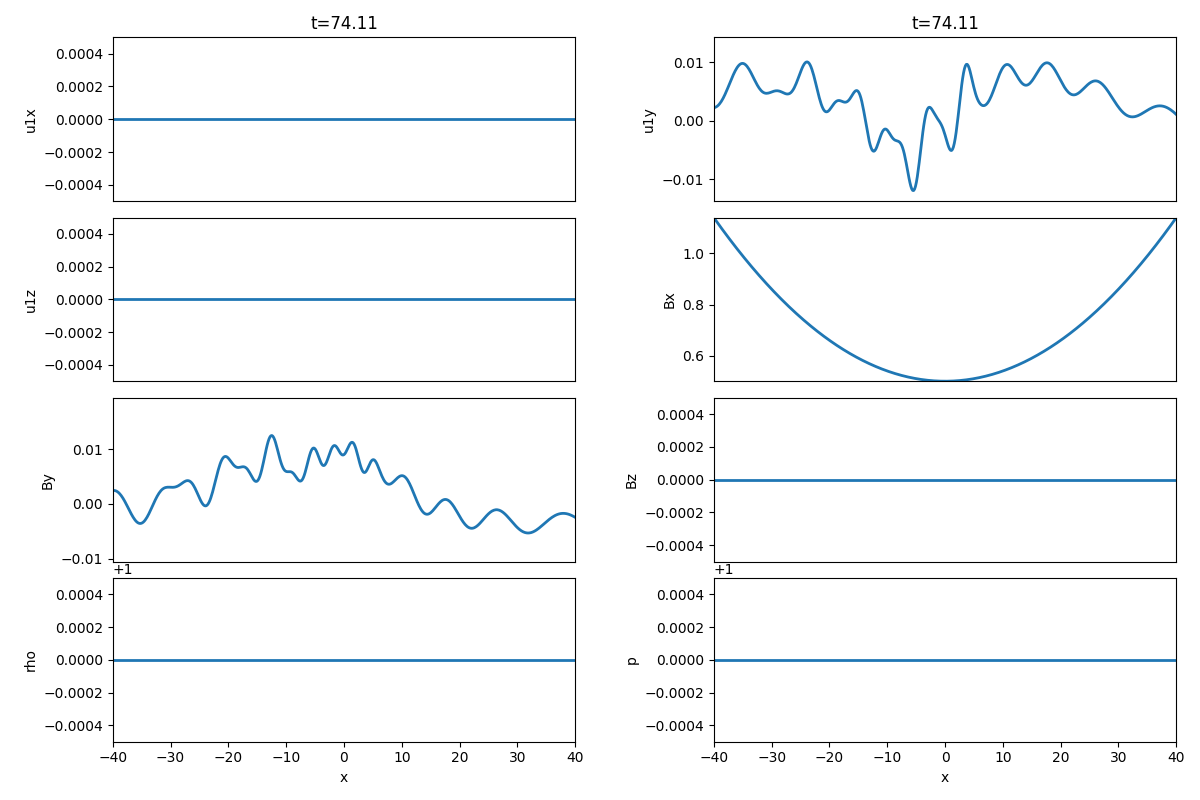
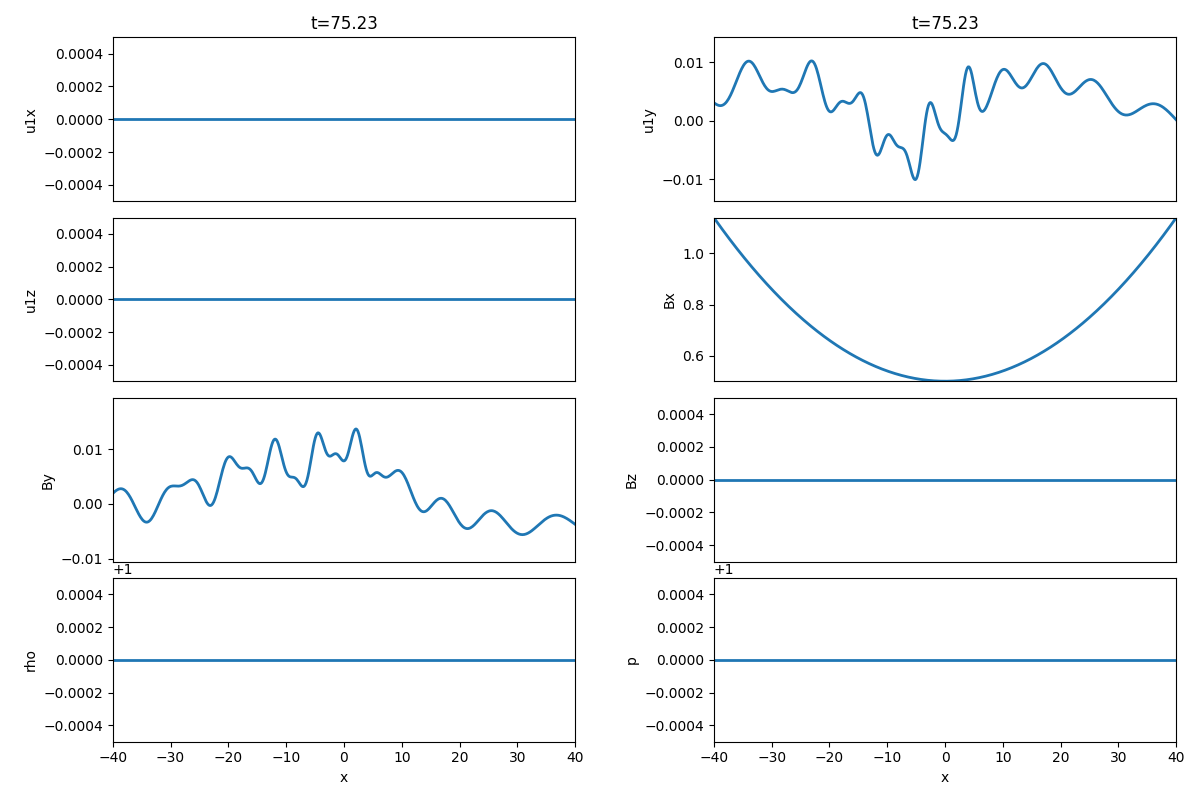
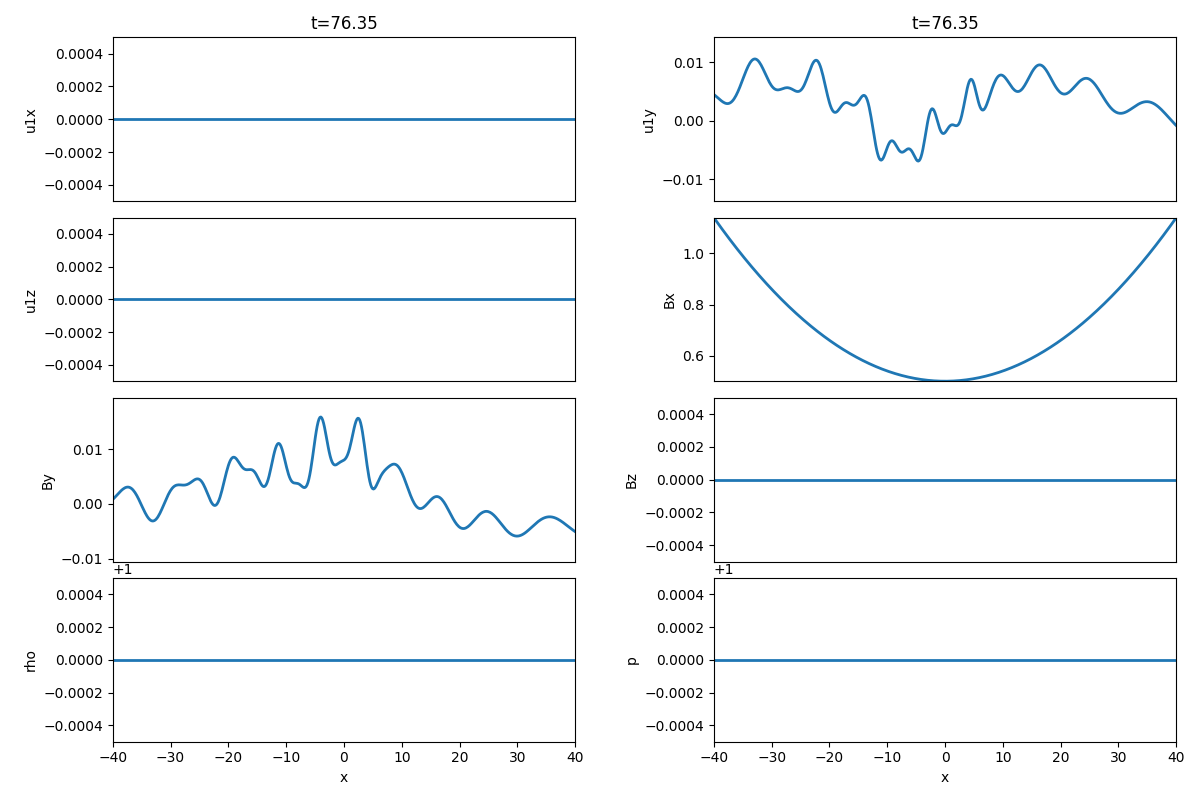
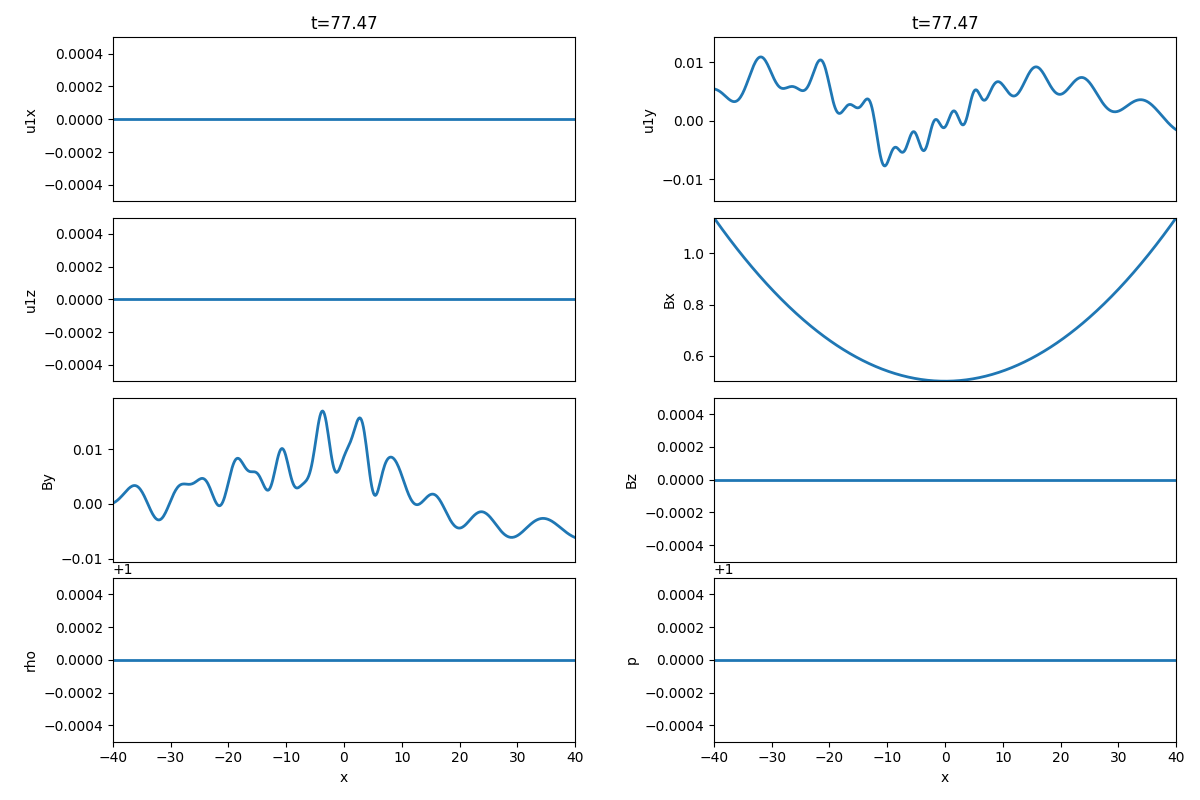
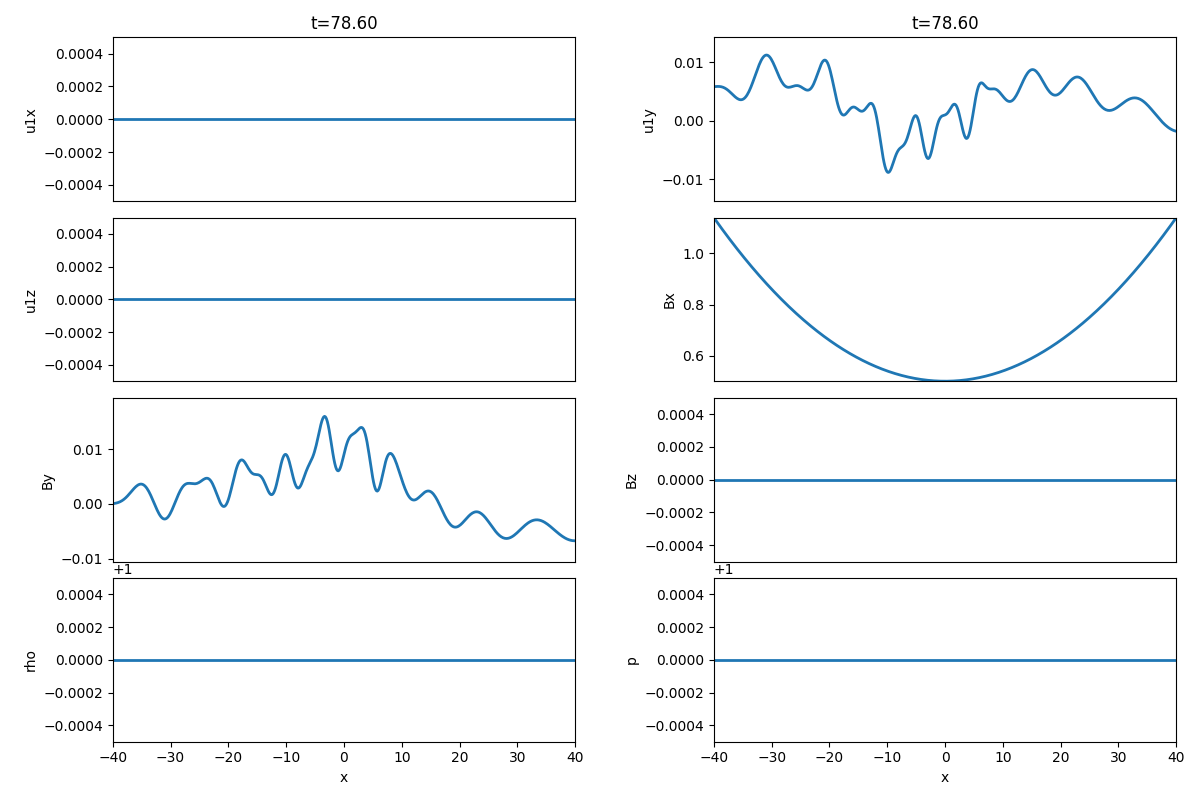
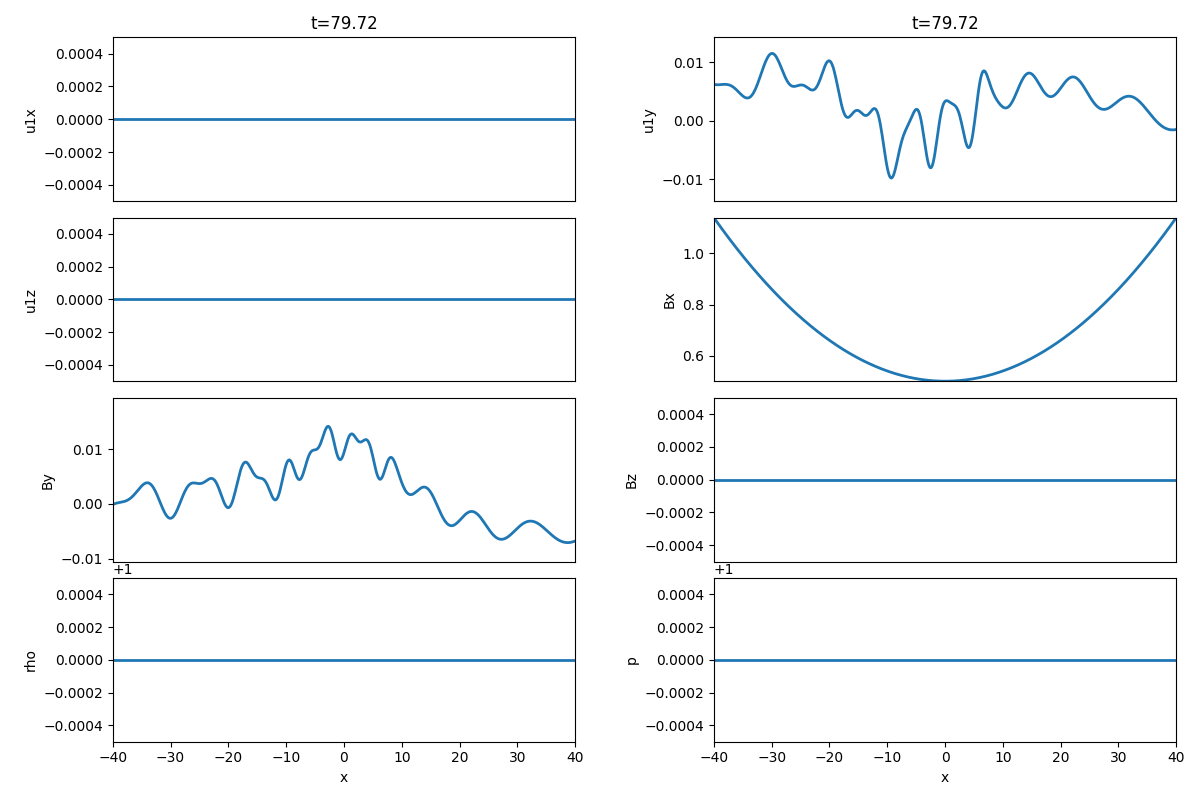
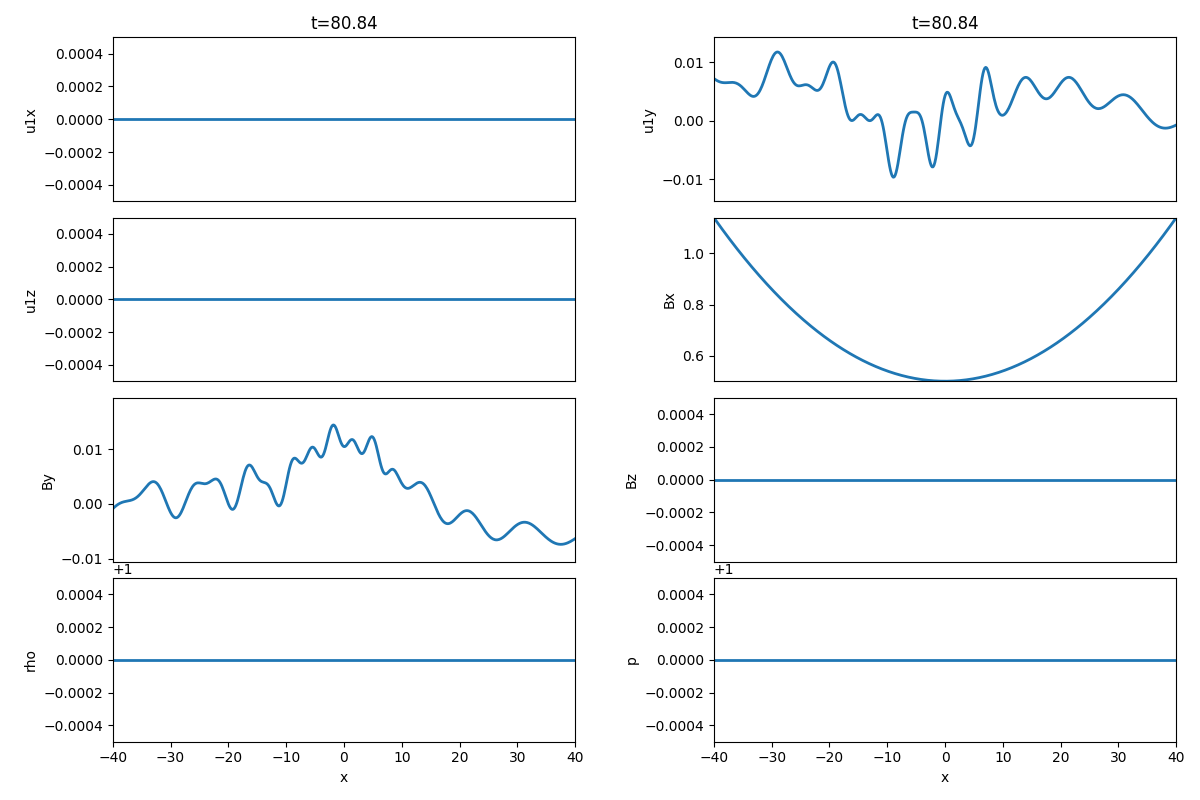
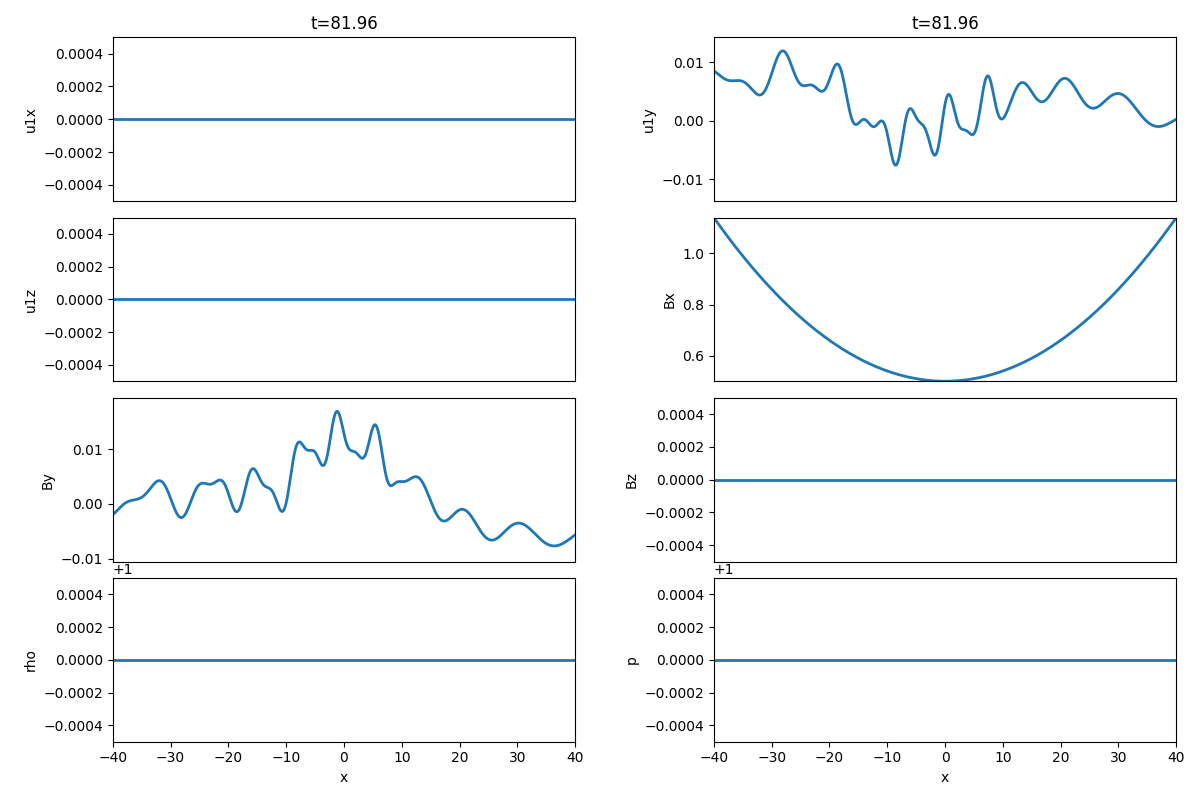
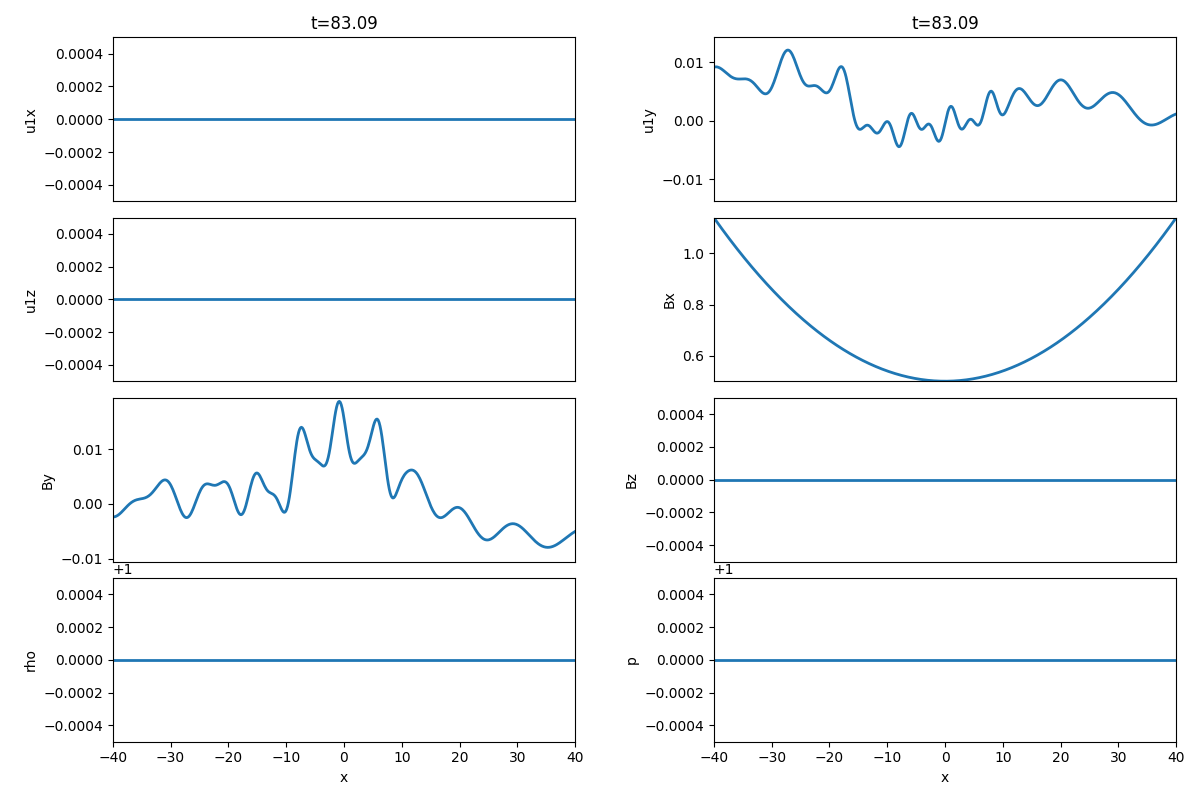
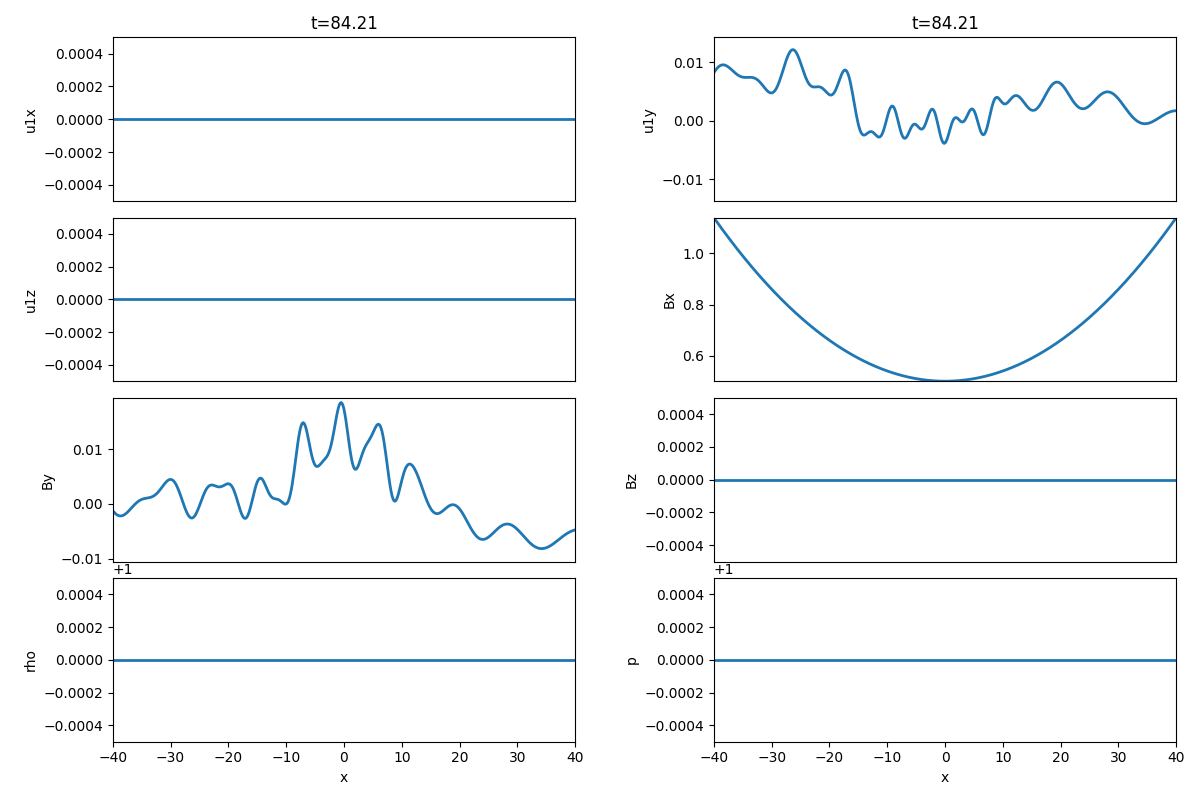
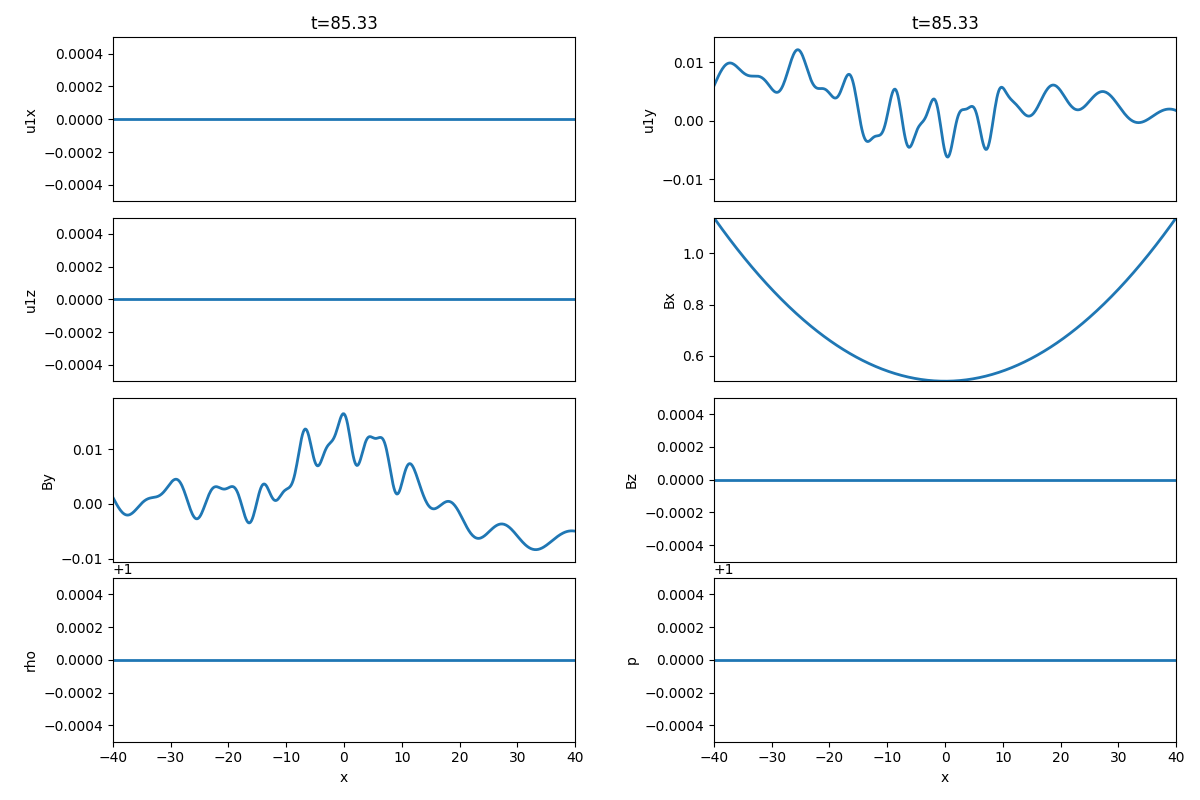
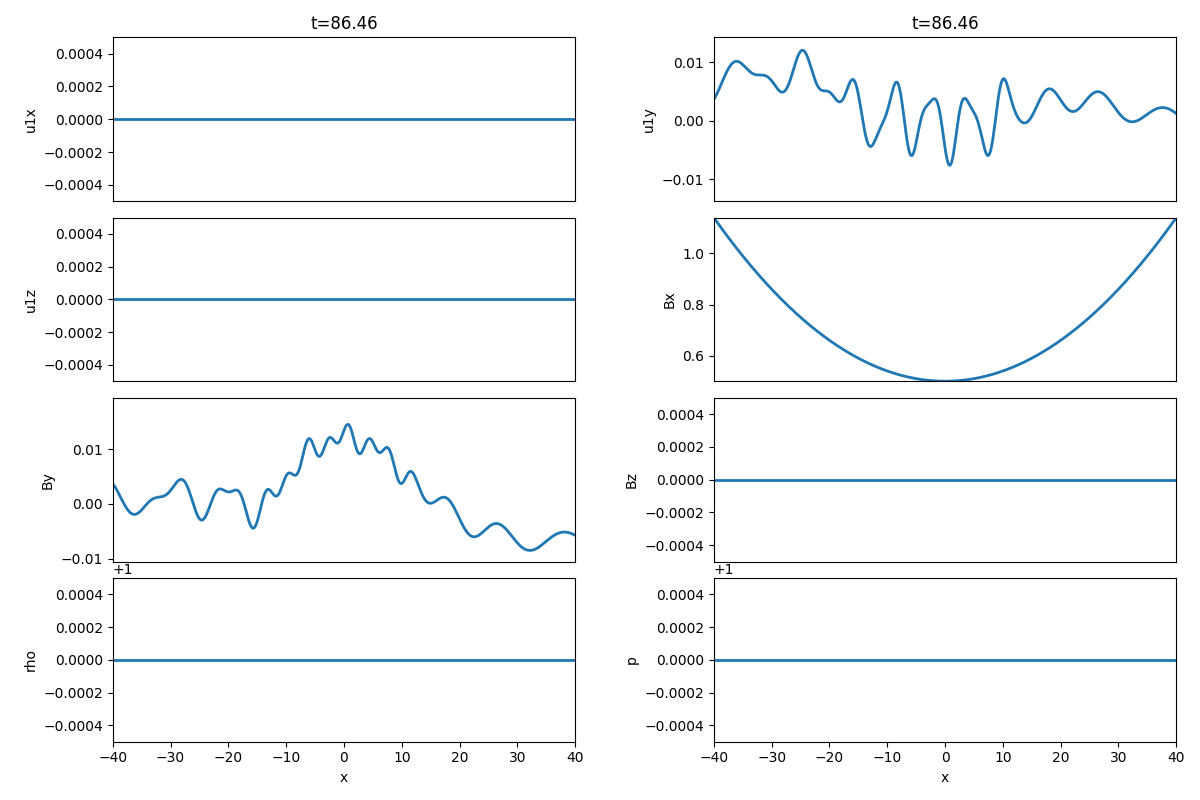
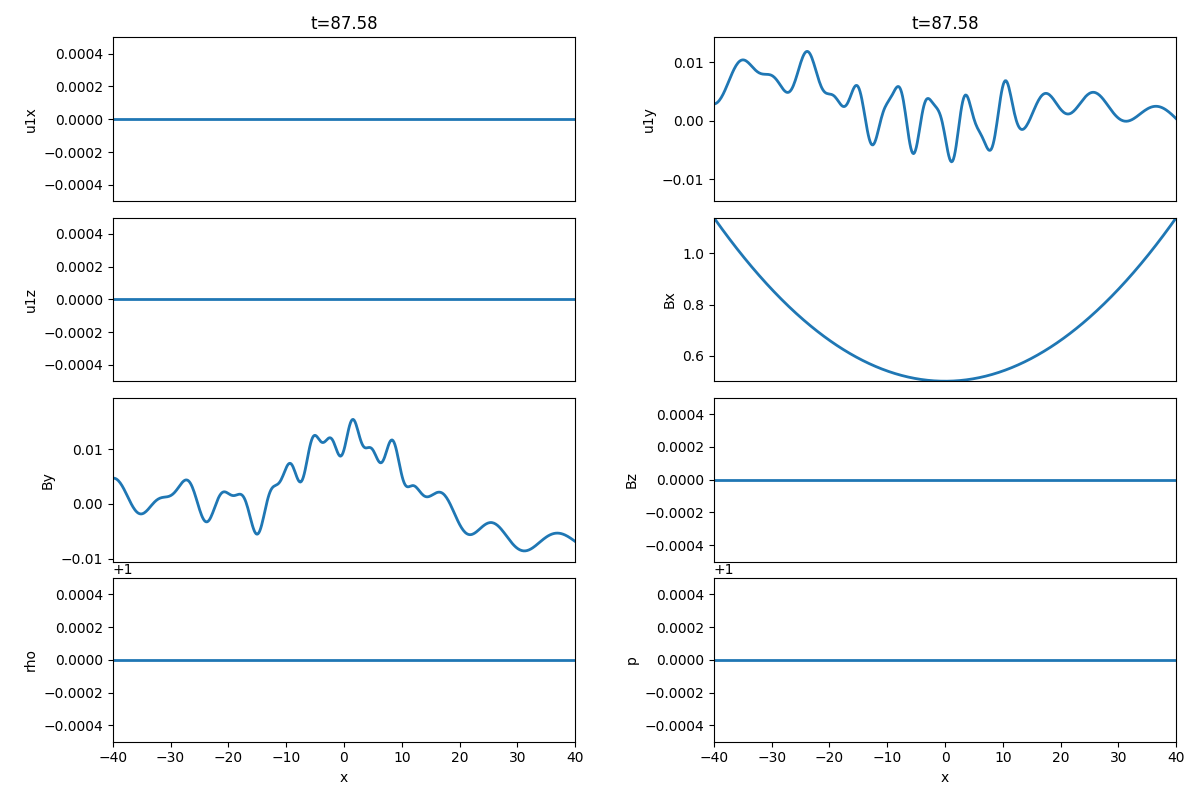
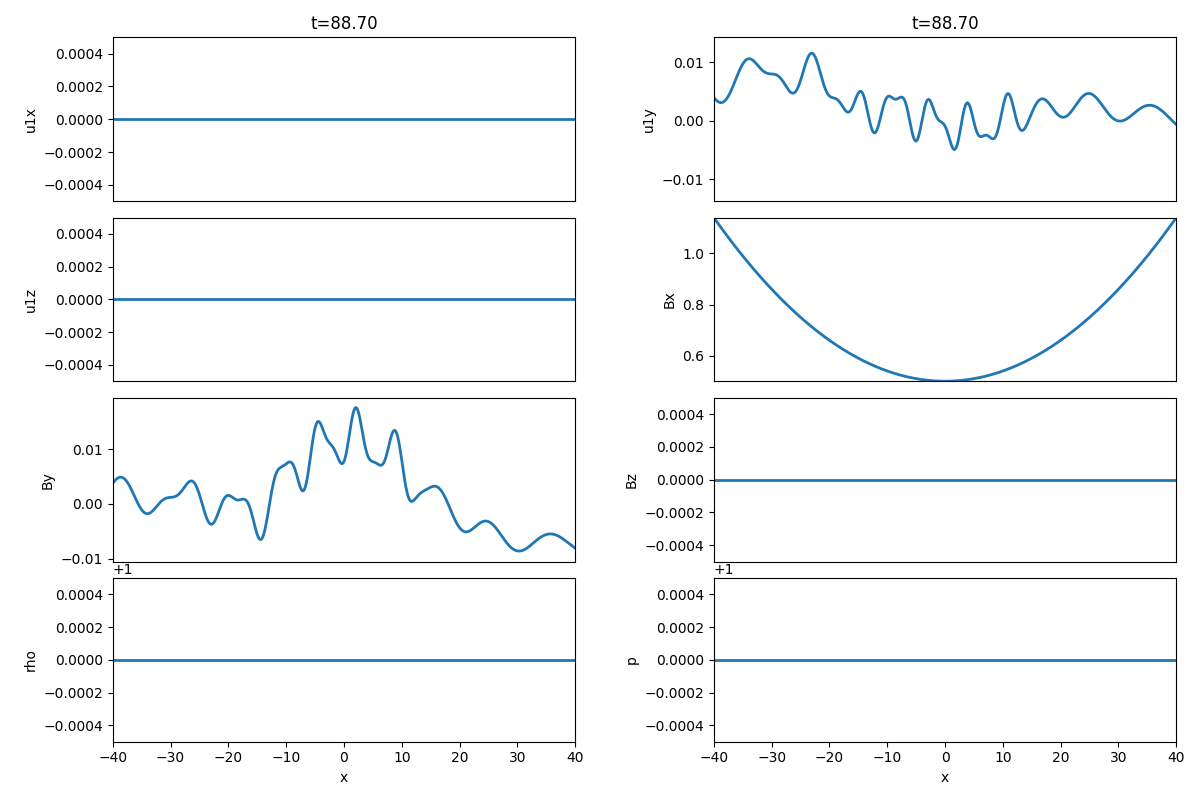
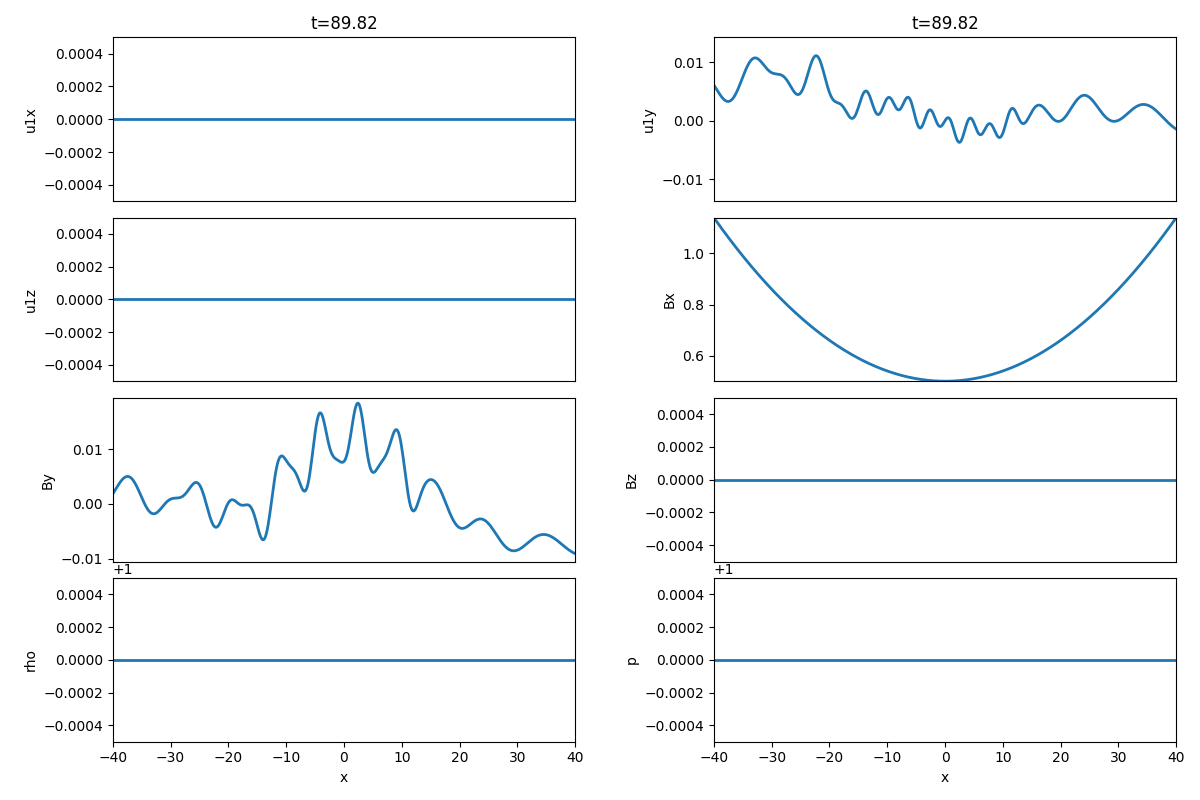
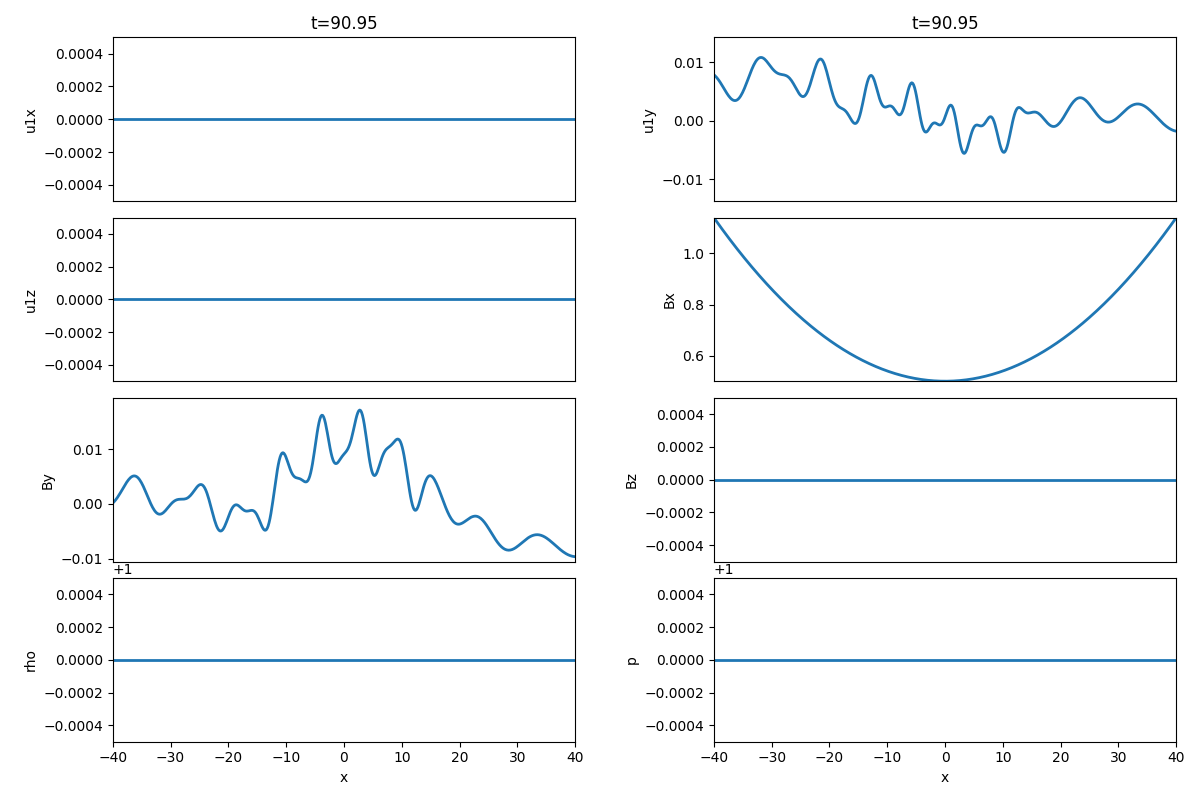
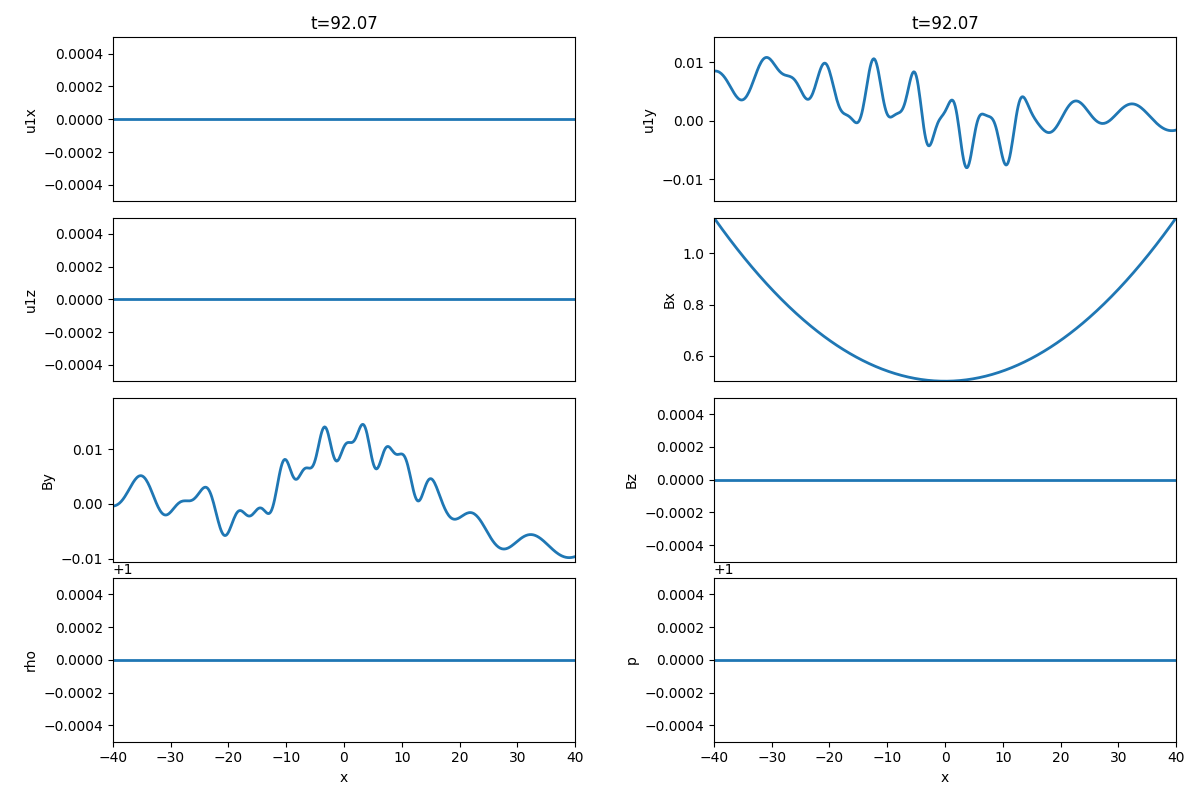
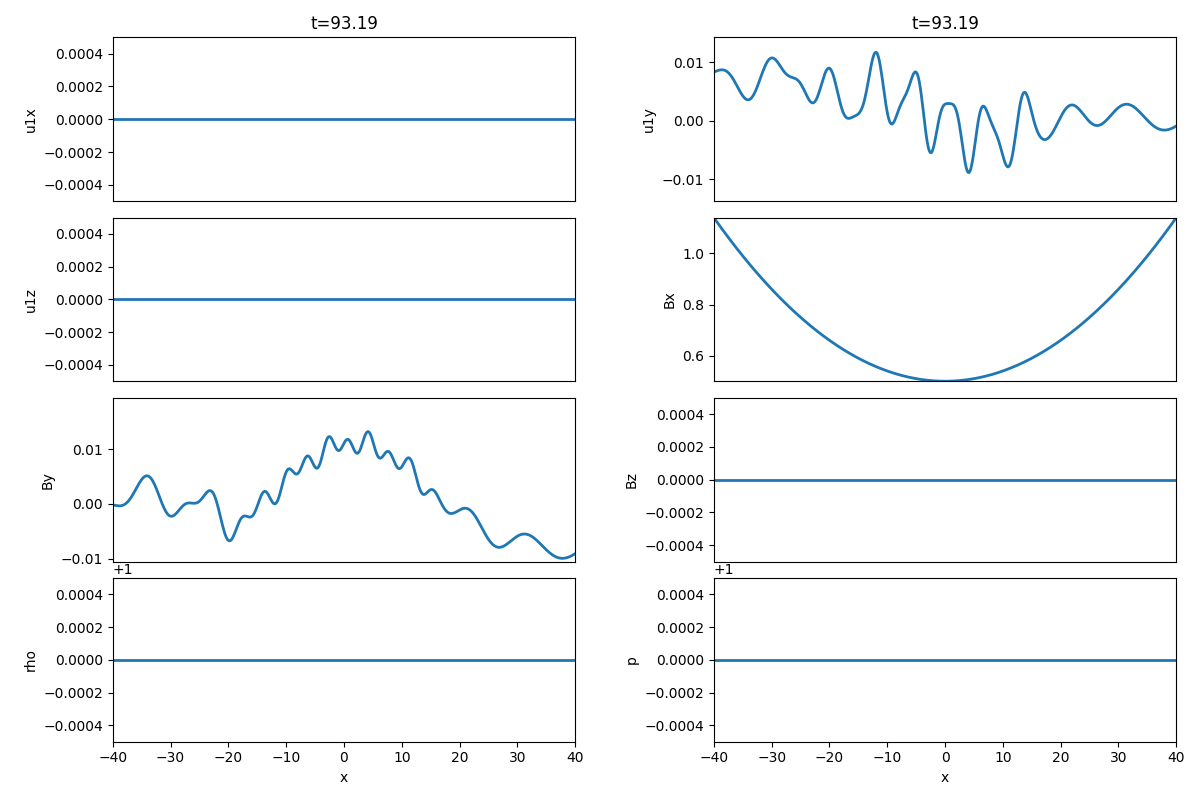
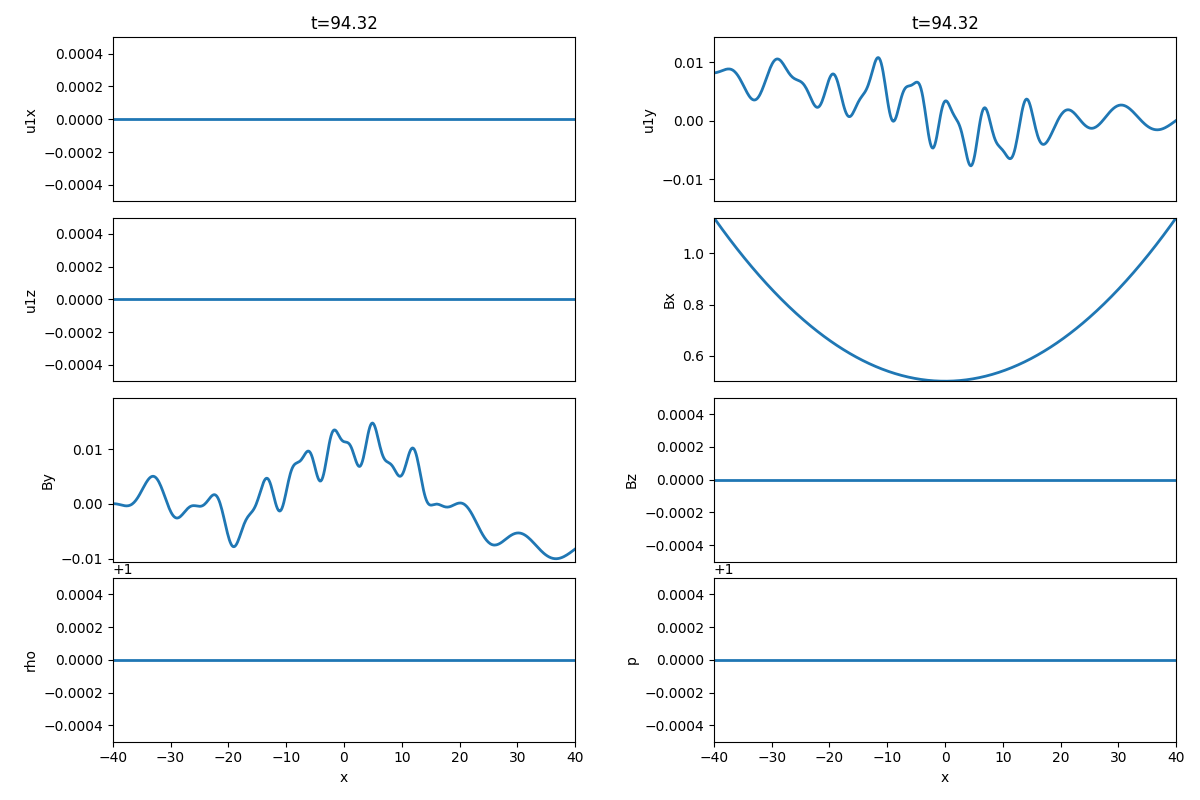
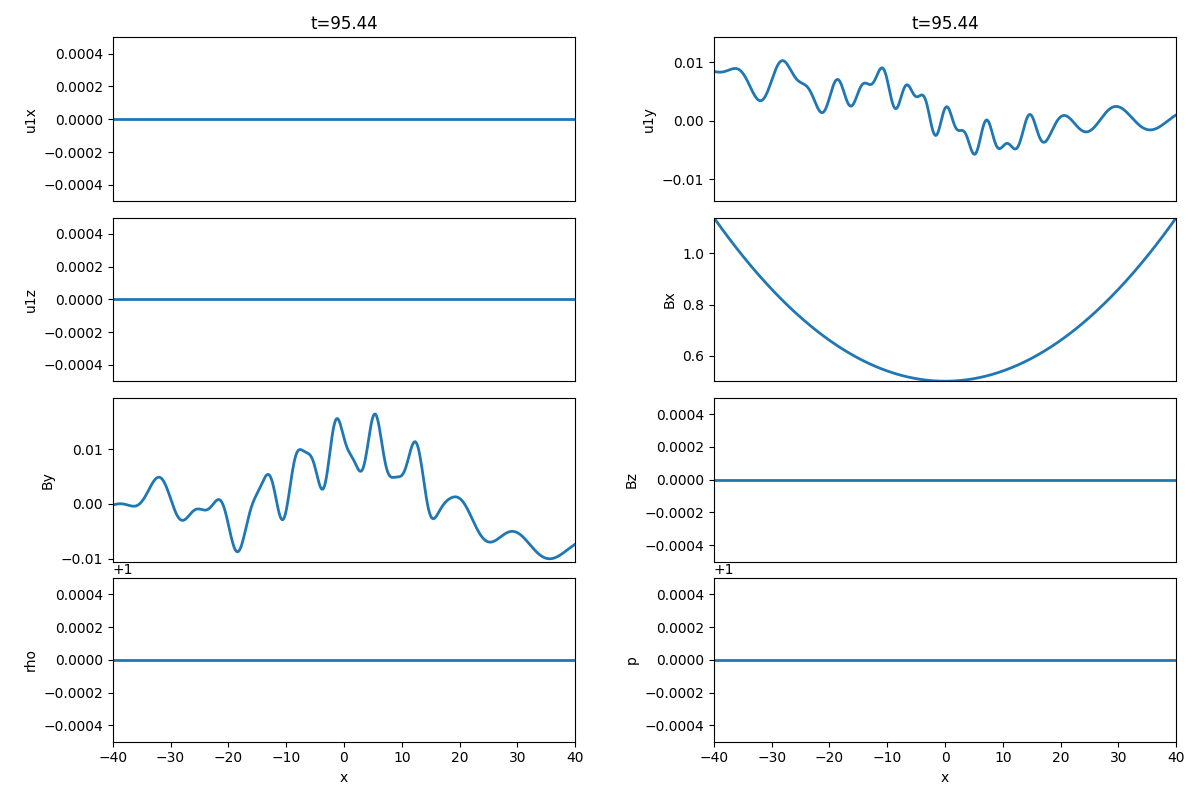
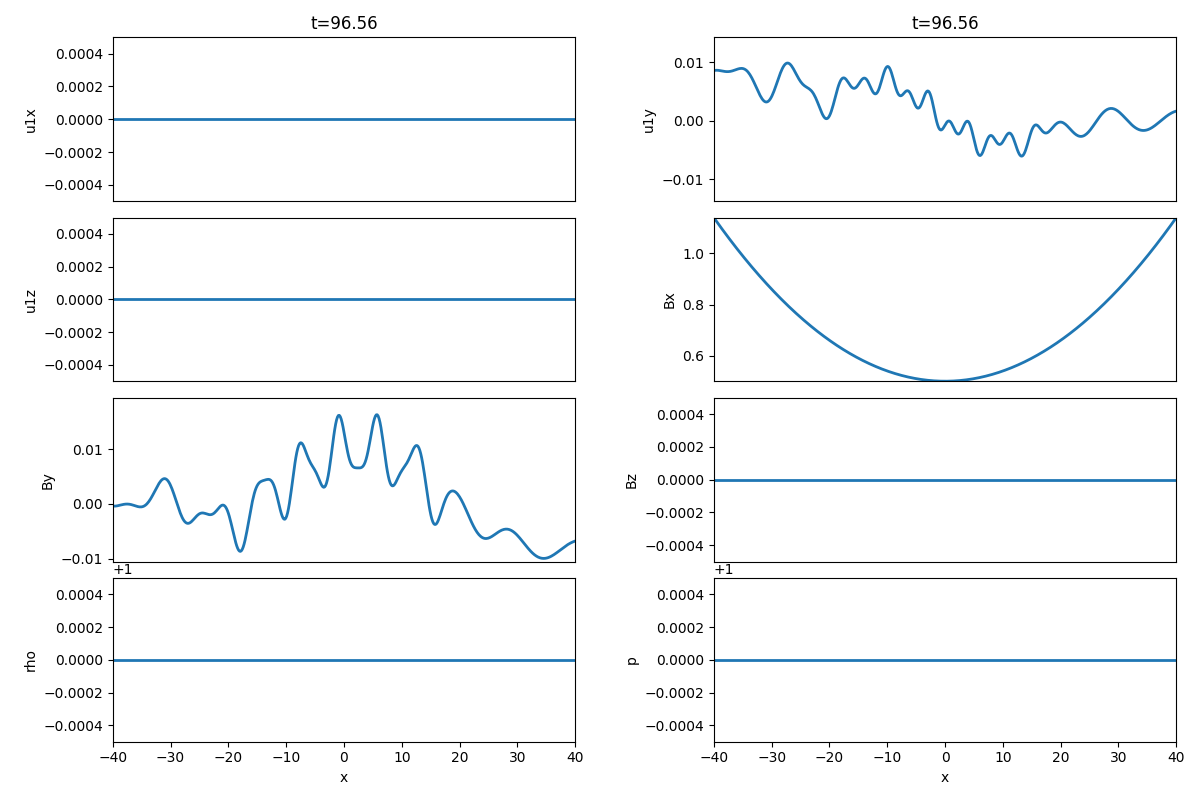
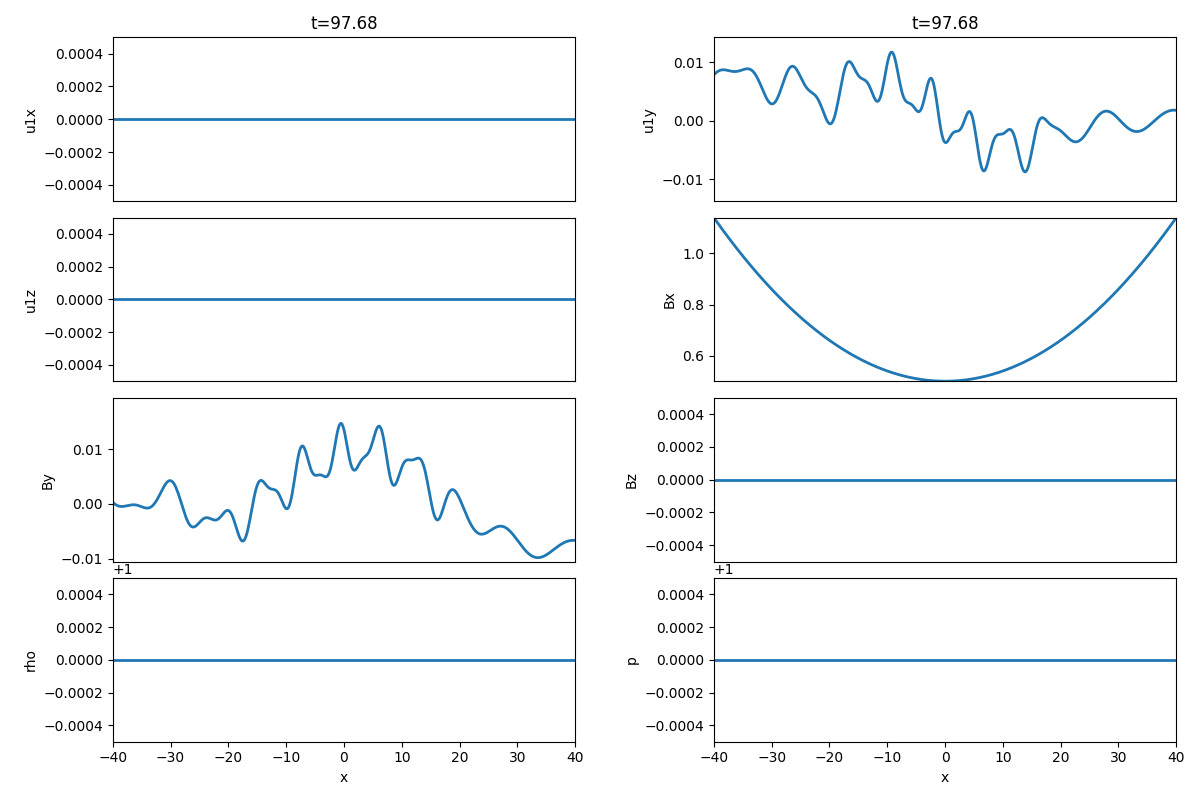
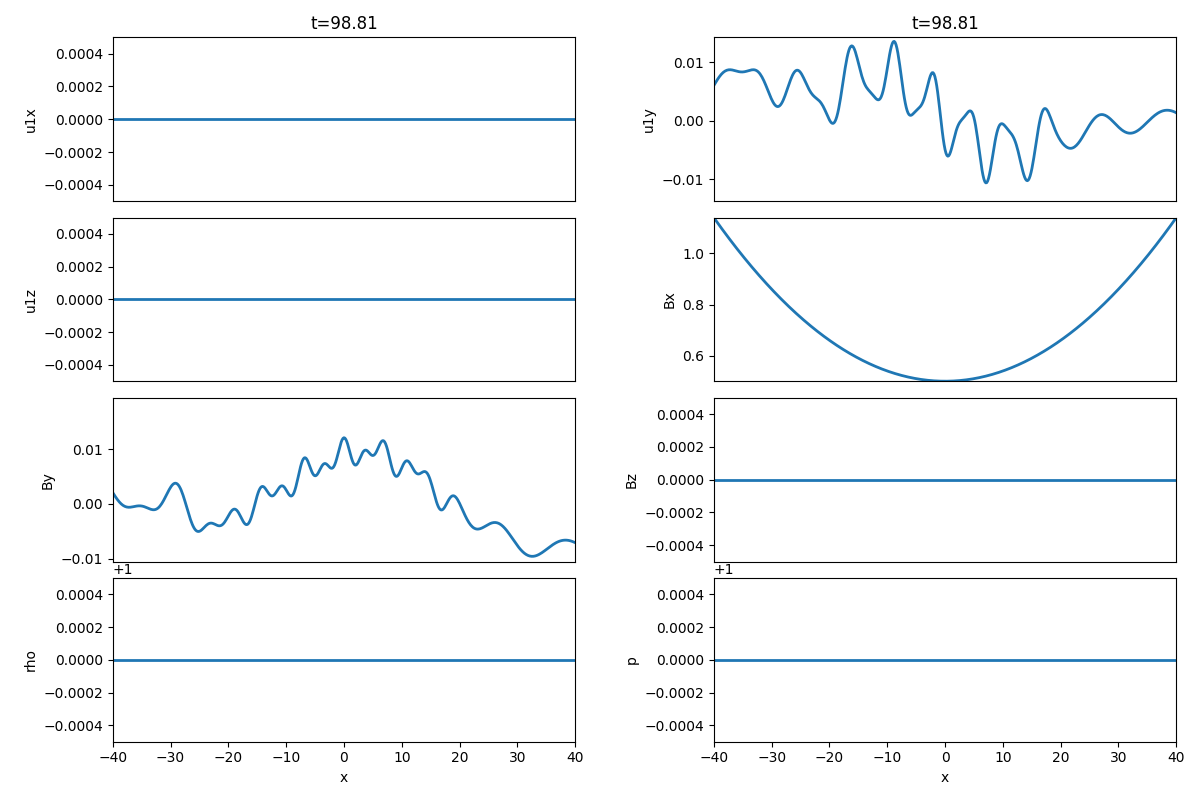

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from JSAnimation import IPython_display
from matplotlib import animation
from scipy.linalg import block_diag
from numpy.linalg import inv
from numpy import linalg as LA
from scipy.linalg import expm, sinm, cosm
import sys
from matplotlib.patches import Circle
from sympy import *


# Author: Florian Holderied (Max-Planck-Institut für Plasmaphysik, Garching, Germany)
# Last update: 10.04.2018




# General input parameters
rho0 = 1                          # Mass density of plasma
p0 = 1                            # Pressure of plasma
gamma = 5/3                       # Adiabatic exponent
a = 0.01                          # Amplitude of largest initial pertubation
L = 40                            # Length of x-domain in + and - direction (L_tot=2L)
T = 100                           # Simulation time
B0x0 = 0.5                        # Magnetic field in x direction at x = 0
xi = 8e-4                         # Magnitude of the background field in x-direction
y = 0                             # Location in y-direction
z = 0                             # Location in z-direction
boundary = 'dirichlet'            # Boundary conditions (periodic, dirichlet, neumann)


# Numerical input parameters
Nx = 500                          # Number of grid cells in x-direction 
CFL = 1                           # CFL-condition (determines time step, must be <= 1 for explicit Finite Difference schemes)


# Input parameters for initial condition
ini = 'off'                       # If you want the same shape for every initial condition, put 'on' here 
shape = 1                         # Shape of initial condition (1: sine-shaped, 2: 1/cosh-shaped, 3: Gauss-shaped)


# Input parameters for animation 
fr = 8                            # Plot only every "fr-th" time step in animation



# Define background fields B0x, B0y, B0z and its derivatives (algebraically and symbolically)
xs, ys, zs = symbols('xs, ys, zs')

def B0x(x):
    return B0x0*(1+xi*x**2) 

B0xs = B0x0*(1+xi*xs**2)

def B0y(x,y):
    return -x*y*xi*B0x0

B0ys = -xs*ys*xi*B0x0

def B0z(x,z):
    return -x*z*xi*B0x0

B0zs = -xs*zs*xi*B0x0

def dx_B0x(x):
    return 2*B0x0*xi*x

dx_B0xs = diff(B0xs,xs) 

def dx_B0y(x,y):
    return -y*xi*B0x0

dx_B0ys = diff(B0ys,xs)

def dx_B0z(x,z):
    return -z*xi*B0x0

dx_B0zs = diff(B0zs,xs)

def dy_B0y(x,y):
    return -x*xi*B0x0

dy_B0ys = diff(B0ys,ys)

def dz_B0z(x,z):
    return -x*xi*B0x0

dz_B0zs = diff(B0zs,zs)




# Define matrices A and C
def A(x,y,z):
    A0 = np.array([0,0,0,0,B0y(x,y)/rho0,B0z(x,z)/rho0,0,1/(2*rho0)])
    A1 = np.array([0,0,0,0,-B0x(x)/rho0,0,0,0])                
    A2 = np.array([0,0,0,0,0,-B0x(x)/rho0,0,0])                
    A3 = np.array([0,0,0,0,0,0,0,0])                
    A4 = np.array([B0y(x,y),-B0x(x),0,0,0,0,0,0])                
    A5 = np.array([B0z(x,z),0,-B0x(x),0,0,0,0,0])                
    A6 = np.array([rho0,0,0,0,0,0,0,0])                
    A7 = np.array([p0*gamma,0,0,0,0,0,0,0])              
    return np.array([A0,A1,A2,A3,A4,A5,A6,A7])


As0 = Matrix([0,0,0,0,B0ys/rho0,B0zs/rho0,0,1/(2*rho0)])
As1 = Matrix([0,0,0,0,-B0xs/rho0,0,0,0])                
As2 = Matrix([0,0,0,0,0,-B0xs/rho0,0,0])                
As3 = Matrix([0,0,0,0,0,0,0,0])                
As4 = Matrix([B0ys,-B0xs,0,0,0,0,0,0])                
As5 = Matrix([B0zs,0,-B0xs,0,0,0,0,0])                
As6 = Matrix([rho0,0,0,0,0,0,0,0])                
As7 = Matrix([p0*gamma,0,0,0,0,0,0,0]) 
As = Matrix([As0,As1,As2,As3,As4,As5,As6,As7])


def C(x,y,z):
    C0 = np.array([0,0,0,0,dx_B0y(x,y)/rho0,dx_B0z(x,z)/rho0,0,0])
    C1 = np.array([0,0,0,-dx_B0y(x,y)/rho0,0,0,0,0])                
    C2 = np.array([0,0,0,-dx_B0z(x,z)/rho0,0,0,0,0])                
    C3 = np.array([-dy_B0y(x,y)-dz_B0z(x,z),0,0,0,0,0,0,0])                
    C4 = np.array([dx_B0y(x,y),-dx_B0x(x)-dz_B0z(x,z),0,0,0,0,0,0])                
    C5 = np.array([dx_B0z(x,z),0,-dx_B0x(x)-dy_B0y(x,y),0,0,0,0,0])                
    C6 = np.array([0,0,0,0,0,0,0,0])                
    C7 = np.array([0,0,0,0,0,0,0,0])              
    return np.array([C0,C1,C2,C3,C4,C5,C6,C7])
 #   return np.zeros((8,8))

Cs0 = Matrix([0,0,0,0,dx_B0ys/rho0,dx_B0zs/rho0,0,0])
Cs1 = Matrix([0,0,0,-dx_B0ys/rho0,0,0,0,0])                
Cs2 = Matrix([0,0,0,-dx_B0zs/rho0,0,0,0,0])                
Cs3 = Matrix([-dy_B0ys-dz_B0zs,0,0,0,0,0,0,0])                
Cs4 = Matrix([dx_B0ys,-dx_B0xs-dz_B0zs,0,0,0,0,0,0])                
Cs5 = Matrix([dx_B0zs,0,-dx_B0xs-dy_B0ys,0,0,0,0,0])                
Cs6 = Matrix([0,0,0,0,0,0,0,0])                
Cs7 = Matrix([0,0,0,0,0,0,0,0]) 
Cs = Matrix([Cs0,Cs1,Cs2,Cs3,Cs4,Cs5,Cs6,Cs7])


# Initial conditions (put here the initial functions u(0,x))
def ICon(x):
    if ini == 'on': 
        if shape == 1:
            return np.outer(U0,np.sin(np.pi*x/L))
        elif shape == 2:
            return np.outer(U0,1/np.cosh(40*x/L))
        elif shape == 3:
            return np.outer(U0,np.exp(-x**2/10))          
    else:
        u1x_0 = 0*x
        u1y_0 = 0*x
        u1z_0 = 0*x
        B1x_0 = 0*x
        B1y_0 = np.sin(x*np.pi/L)
        B1z_0 = 0*x
        rho1_0 = 0*x
        p1_0 = 0*x
        IC = np.array([u1x_0,u1y_0,u1z_0,B1x_0,B1y_0,B1z_0,rho1_0,p1_0])
        return a/IC.max()*IC



# Dirichlet boundary conditions (assign as many boundary conditions on the LHS (RHS) as positive (negative) eigenvalues of A)    
# LHS (put here the boundary conditions u(t,-L))
def d_L(t):
    u1x_L = 0*t
    u1y_L = 0*t
    u1z_L = 0*t
    B1x_L = 0*t
    B1y_L = 0.5*a*np.sin(0.2*t)**2*np.cos(0.5*t)
    B1z_L = 0*t
    rho1_L = 0*t
    p1_L = 0*t
    dL = np.array([u1x_L,u1y_L,u1z_L,B1x_L,B1y_L,B1z_L,rho1_L,p1_L])
    return dL
    
# RHS (put here the boundary conditions u(t,L))
def d_R(t):
    u1x_R = 0*t
    u1y_R = -2*a*np.sin(0.5*t)*B0x(L)/rho0*np.pi/L
    u1z_R = 0*t
    B1x_R = 0*t
    B1y_R = 0*t
    B1z_R = 0*t
    rho1_R = 0*t
    p1_R = 0*t
    dR = np.array([u1x_R,u1y_R,u1z_R,B1x_R,B1y_R,B1z_R,rho1_R,p1_R])
    return dR
    
BL1 = np.diag([0,0,0,0,1,0,0,0])
BL2 = np.diag([1,1,1,1,0,1,1,1])
BR1 = np.diag([0,1,0,0,0,0,0,0])
BR2 = np.diag([1,0,1,1,1,1,1,1])   
    
    

    
    
    

# Neumann boundary conditions (assign as many boundary conditions on the LHS (RHS) as positive (negative) eigenvalues of A)    
# LHS (put here the boundary conditions dx_u(t,-L))
def n_L(t):
    dx_u1x_L = 0*t
    dx_u1y_L = 0*t
    dx_u1z_L = 0*t
    dx_B1x_L = 0*t
    dx_B1y_L = -a*np.pi/L*np.cos(0.5*t)
    dx_B1z_L = 0*t
    dx_rho1_L = 0*t
    dx_p1_L = 0*t
    nL = np.array([dx_u1x_L,dx_u1y_L,dx_u1z_L,dx_B1x_L,dx_B1y_L,dx_B1z_L,dx_rho1_L,dx_p1_L])
    return nL
    
# RHS (put here the boundary conditions dx_u(t,L))
def n_R(t):
    dx_u1x_R = 0*t
    dx_u1y_R = 0.5*a*np.sin(0.2*t)**2*np.cos(0.5*t)
    dx_u1z_R = 0*t
    dx_B1x_R = 0*t
    dx_B1y_R = 0*t
    dx_B1z_R = 0*t
    dx_rho1_R = 0*t
    dx_p1_R = 0*t
    nR = np.array([dx_u1x_R,dx_u1y_R,dx_u1z_R,dx_B1x_R,dx_B1y_R,dx_B1z_R,dx_rho1_R,dx_p1_R])
    return nR
    
BL1_N = np.diag([0,0,0,0,1,0,0,0])
BL2_N = np.diag([1,1,1,1,0,1,1,1])
BR1_N = np.diag([0,1,0,0,0,0,0,0])
BR2_N = np.diag([1,0,1,1,1,1,1,1])    
    
    

    
    
    
# Discretisation of space
deltax = 2*L/Nx
x = np.linspace(-L,L,Nx+1)
    
    
    
    
    
    
# Eigenvalues (characteristic velocities of the system) and eigenvectors
eigenvalues = np.zeros((Nx+1,8))
eigenvectors = np.zeros((Nx+1,8,8))
for j in range(0,Nx+1):
    eigenvalues[j], eigenvectors[j] = LA.eig(A(x[j],y,z))

v,w = LA.eig(A(0,y,z))


# Initial conditions
if ini=='on':
    indicespos = np.array([])
    indicesneg = np.array([])
    for i in range(0,v.size):
        if v[i] > 0:
            indicespos = np.append(indicespos,i)
        elif v[i] < 0:
            indicesneg = np.append(indicesneg,i)  
        
    print('Positive advection speed:' + str(indicespos))
    print('Negative advection speed:' + str(indicesneg))
    initial = int(input("Choose your initial condition: ")) 
    U0 = a*w[:,initial]/np.amax(abs(w[:,initial]))
    temp = np.zeros(v.size)
    temp[initial] = v[initial]
    v = temp



# Discretisation time 
vmax = eigenvalues.max()
deltat = deltax*CFL/np.abs(vmax)
Nt = np.int(T/deltat)
T = Nt*deltat
t = np.linspace(0,T,Nt+1)
print('Number of time steps: ' + str(Nt))



    

    
    
    

# Lax-Wendroff scheme with notation U = (u1x,u1y,u1z,B1x,B1y,B1z,rho1,p1) and Dirichlet boundary conditions
def Lax_Wendroff_Dirichlet():
    
    s = int(np.sqrt(A(0,y,z).size))
    U = np.zeros((Nt+1,Nx+1,s))
    V = np.zeros((Nt+1,Nx+1,s))
    U[0,:,:] = np.transpose(ICon(x))
    
    for j in range(0,Nx+1):
        V[0,j,:] = np.transpose(np.dot(inv(eigenvectors[j]),np.transpose(U[0,j,:])))
    
    lam = deltat/deltax
    
    
    '''
    Dpos = np.zeros((Nx+1,s,s))
    Dneg = np.zeros((Nx+1,s,s))
    Dposnorm = np.zeros((Nx+1,s,s))
    Dnegnorm = np.zeros((Nx+1,s,s))

    for j in range(0,Nx+1):
        Dpos[j,np.where(eigenvalues[j]>0),np.where(eigenvalues[j]>0)] = eigenvalues[j,np.where(eigenvalues[j]>0)]
        Dneg[j,np.where(eigenvalues[j]<0),np.where(eigenvalues[j]<0)] = eigenvalues[j,np.where(eigenvalues[j]<0)]
        Dposnorm[j,np.where(eigenvalues[j]>0),np.where(eigenvalues[j]>0)] = eigenvalues[j,np.where(eigenvalues[j]>0)]/eigenvalues[j,np.where(eigenvalues[j]>0)]
        Dnegnorm[j,np.where(eigenvalues[j]<0),np.where(eigenvalues[j]<0)] = eigenvalues[j,np.where(eigenvalues[j]<0)]/eigenvalues[j,np.where(eigenvalues[j]<0)]
    '''
   

    for n in range(0,Nt):
        if n%100 == 0:
            print('Time steps finished: ' + str(n))
        
        # Interior points
        for j in range(1,Nx):     
            U[n+1,j,:] = U[n,j,:] - 1/2*lam*np.dot(A(x[j],y,z),U[n,j+1,:]-U[n,j-1,:]) - deltat*np.dot(C(x[j],y,z),U[n,j,:]) + 1/2*lam**2*(np.dot(np.dot(A(x[j],y,z),A(x[j],y,z)),U[n,j+1,:]-2*U[n,j,:]+U[n,j-1,:])) + 1/4*lam*deltat*np.dot(np.dot(A(x[j],y,z),C(x[j],y,z))+np.dot(C(x[j],y,z),A(x[j],y,z)),U[n,j+1,:]-U[n,j-1,:]) + 1/2*deltat**2*np.dot(np.dot(C(x[j],y,z),C(x[j],y,z)),U[n,j,:]) 
        
        
        # Boundary points (Dirichlet and numerical boundary conditions)                    
        U[n+1,0,:] = np.dot(BL1,d_L(t[n+1])) + np.dot(BL2,2*U[n+1,1,:]-U[n+1,2,:])
        U[n+1,-1,:] = np.dot(BR1,d_R(t[n+1])) + np.dot(BR2,2*U[n+1,-2,:]-U[n+1,-3,:])
        
        
        '''
        # Boundary points (transform to diagonal set of equations to identify in- and outflow)         
        for j in range(0,Nx+1):
            F[n+1,j,:] = np.transpose(np.dot(inv(eigenvectors[j]),np.transpose(U[n+1,j,:])))
            
        # Outflow points with upwind scheme or linear extrapolation
        if outflow == 'upwind':
            CtildeL = np.dot(inv(eigenvectors[0]).)
            F[n+1,0,:] = F[n,0,:] - deltat/deltax*np.dot(Dneg[0],F[n,1,:]-F[n,0,:]) + deltat*np.dot(np.dot(inv(eigenvectors[0],C(x[0],y,z))
            F[n+1,-1,:] = F[n,-1,:] - deltat/deltax*np.dot(Dpos[-1],F[n,-1,:]-F[n,-2,:])
        elif outflow == 'extrapolate':            
            F[n+1,0,:] = np.dot(Dnegnorm,2*F[n+1,1,:]-F[n+1,2,:])
            F[n+1,-1,:] = np.dot(Dposnorm,2*F[n+1,-2,:]-F[n+1,-3,:])
            
        # Inflow points with Dirichlet boundary conditions
        F[n+1,0,1] = F[n+1,0,2] - np.sqrt(2)*B1y_L(t[n+1]) 
        F[n+1,-1,2] = np.sqrt(2*rho0)*u1y_R(t[n+1]) - F[n+1,-1,1]
         
        # Back transformation    
        U[n+1,:,:] = np.transpose(np.dot(w,np.transpose(F[n+1,:,:])))    
        '''
        
                                                                                                           
    P = np.zeros((Nt+1,Nx+1,8))
    P[:,:,0] = U[:,:,0]
    P[:,:,1] = U[:,:,1]
    P[:,:,2] = U[:,:,2]
    P[:,:,3] = U[:,:,3] + B0x(x)
    P[:,:,4] = U[:,:,4] + B0y(x,y)
    P[:,:,5] = U[:,:,5] + B0z(x,z)
    P[:,:,6] = U[:,:,6] + rho0
    P[:,:,7] = U[:,:,7] + p0
    print('Time integration finished!')
    
    return P

                

    
    
# Lax-Wendroff scheme with notation U = (u1x,u1y,u1z,B1x,B1y,B1z,rho1,p1) and Neumann boundary conditions
def Lax_Wendroff_Neumann():
    
    s = int(np.sqrt(A(0,y,z).size))
    U = np.zeros((Nt+1,Nx+1,s))
    V = np.zeros((Nt+1,Nx+1,s))
    U[0,:,:] = np.transpose(ICon(x))
   
    for j in range(0,Nx+1):
        V[0,j,:] = np.transpose(np.dot(inv(eigenvectors[j]),np.transpose(U[0,j,:])))
    
    lam = deltat/deltax
    
    
    '''
    Dpos = np.zeros((Nx+1,s,s))
    Dneg = np.zeros((Nx+1,s,s))
    Dposnorm = np.zeros((Nx+1,s,s))
    Dnegnorm = np.zeros((Nx+1,s,s))

    for j in range(0,Nx+1):
        Dpos[j,np.where(eigenvalues[j]>0),np.where(eigenvalues[j]>0)] = eigenvalues[j,np.where(eigenvalues[j]>0)]
        Dneg[j,np.where(eigenvalues[j]<0),np.where(eigenvalues[j]<0)] = eigenvalues[j,np.where(eigenvalues[j]<0)]
        Dposnorm[j,np.where(eigenvalues[j]>0),np.where(eigenvalues[j]>0)] = eigenvalues[j,np.where(eigenvalues[j]>0)]/eigenvalues[j,np.where(eigenvalues[j]>0)]
        Dnegnorm[j,np.where(eigenvalues[j]<0),np.where(eigenvalues[j]<0)] = eigenvalues[j,np.where(eigenvalues[j]<0)]/eigenvalues[j,np.where(eigenvalues[j]<0)]
    '''
    
    for n in range(0,Nt):
        if n%100 == 0:
            print('Time steps finished: ' + str(n))
        
        # Interior points
        for j in range(1,Nx):
            U[n+1,j,:] = U[n,j,:] - 1/2*lam*np.dot(A(x[j],y,z),U[n,j+1,:]-U[n,j-1,:]) - deltat*np.dot(C(x[j],y,z),U[n,j,:]) + 1/2*lam**2*(np.dot(np.dot(A(x[j],y,z),A(x[j],y,z)),U[n,j+1,:]-2*U[n,j,:]+U[n,j-1,:])) + 1/4*lam*deltat*np.dot(np.dot(A(x[j],y,z),C(x[j],y,z))+np.dot(C(x[j],y,z),A(x[j],y,z)),U[n,j+1,:]-U[n,j-1,:]) + 1/2*deltat**2*np.dot(np.dot(C(x[j],y,z),C(x[j],y,z)),U[n,j,:]) 
        
        # Boundary points (Neumann and numerical boundary conditions)               
        U[n+1,0,:] = np.dot(BL1_N,U[n+1,1,:]-deltax*n_L(t[n+1])) + np.dot(BL2_N,2*U[n+1,1,:]-U[n+1,2,:])
        U[n+1,-1,:] = np.dot(BR1_N,U[n+1,-2,:]+deltax*n_R(t[n+1])) + np.dot(BR2_N,2*U[n+1,-2,:]-U[n+1,-3,:])
    
 
                                                                            
                                                              
                                                                            
                                                                                                                                          
    P = np.zeros((Nt+1,Nx+1,8))
    P[:,:,0] = U[:,:,0]
    P[:,:,1] = U[:,:,1]
    P[:,:,2] = U[:,:,2]
    P[:,:,3] = U[:,:,3] + B0x(x)
    P[:,:,4] = U[:,:,4] + B0y(x,y)
    P[:,:,5] = U[:,:,5] + B0z(x,z)
    P[:,:,6] = U[:,:,6] + rho0
    P[:,:,7] = U[:,:,7] + p0
    print('Time integration finished!')
    
    return P
    
    
    
    
    
    
    
    
                                                                            
# Lax-Wendroff scheme with notation U = (u1x,u1y,u1z,B1x,B1y,B1z,rho1,p1) and periodic boundary conditions
def Lax_Wendroff_Periodic():
    
    s = int(np.sqrt(A(0,y,z).size))
    U = np.zeros((Nt+1,Nx,s))
    U[0,:,:] = np.transpose(ICon(x[0:Nx]))
    lam = deltat/deltax
    
    for n in range(0,Nt):
        if n%100 == 0:
            print('Time steps finished: ' + str(n))
        for j in range(0,Nx):              
            U[n+1,j,:] = U[n,j,:] - 1/2*lam*np.dot(A(x[j],y,z),U[n,(j+1)%Nx,:]-U[n,j-1,:]) - deltat*np.dot(C(x[j],y,z),U[n,j,:]) + 1/2*lam**2*(np.dot(np.dot(A(x[j],y,z),A(x[j],y,z)),U[n,(j+1)%Nx,:]-2*U[n,j,:]+U[n,j-1,:])) + 1/4*lam*deltat*np.dot(np.dot(A(x[j],y,z),C(x[j],y,z))+np.dot(C(x[j],y,z),A(x[j],y,z)),U[n,(j+1)%Nx,:]-U[n,j-1,:]) + 1/2*deltat**2*np.dot(np.dot(C(x[j],y,z),C(x[j],y,z)),U[n,j,:]) 
       
    Temp = np.zeros((Nt+1,Nx+1,s))
    Temp[:,0:Nx,:] = U
    Temp[:,-1,:] = Temp[:,0,:]
        
    P = np.zeros((Nt+1,Nx+1,s))
    P[:,:,0] = Temp[:,:,0]
    P[:,:,1] = Temp[:,:,1]
    P[:,:,2] = Temp[:,:,2]
    P[:,:,3] = Temp[:,:,3] + B0x(x)
    P[:,:,4] = Temp[:,:,4] + B0y(x,y)
    P[:,:,5] = Temp[:,:,5] + B0z(x,z)
    P[:,:,6] = Temp[:,:,6] + rho0
    P[:,:,7] = Temp[:,:,7] + p0
    print('Time integration finished!')
    
    return P





if boundary == 'periodic':
    Test = Lax_Wendroff_Periodic()
elif boundary == 'dirichlet':
    Test = Lax_Wendroff_Dirichlet()
elif boundary == 'neumann':
    Test = Lax_Wendroff_Neumann()







# Animation
print('Start to prepare animation')
print('Number of frames: ' + str(int(Nt/fr)))
plt.rc('text', usetex = False)
plt.rc('font', family='sans-serif')
plt.rcParams.update({'font.size': 10})   
f1, ((a1,a2),(a3,a4),(a5,a6),(a7,a8)) = plt.subplots(4,2,sharex='col')
f1.set_figheight(8)
f1.set_figwidth(12)
a1.set_title('t = 0.00')
a2.set_title('t = 0.00')
a1.set_xlim((-L,L))
a2.set_xlim((-L,L))
a3.set_xlim((-L,L))
a4.set_xlim((-L,L))
a5.set_xlim((-L,L))
a6.set_xlim((-L,L))
a7.set_xlim((-L,L))
a8.set_xlim((-L,L))
a1.set_ylim((np.min(Test[:,:,0])-0.0005,np.max(Test[:,:,0])+0.0005))
a2.set_ylim((np.min(Test[:,:,1])-0.0005,np.max(Test[:,:,1])+0.0005))
a3.set_ylim((np.min(Test[:,:,2])-0.0005,np.max(Test[:,:,2])+0.0005))
a4.set_ylim((np.min(Test[:,:,3])-0.0005,np.max(Test[:,:,3])+0.0005))
a5.set_ylim((np.min(Test[:,:,4])-0.0005,np.max(Test[:,:,4])+0.0005))
a6.set_ylim((np.min(Test[:,:,5])-0.0005,np.max(Test[:,:,5])+0.0005))
a7.set_ylim((np.min(Test[:,:,6])-0.0005,np.max(Test[:,:,6])+0.0005))
a8.set_ylim((np.min(Test[:,:,7])-0.0005,np.max(Test[:,:,7])+0.0005))
a1.set_ylabel('u1x')
a2.set_ylabel('u1y')
a3.set_ylabel('u1z')
a4.set_ylabel('Bx')
a5.set_ylabel('By')
a6.set_ylabel('Bz')
a7.set_ylabel('rho')
a8.set_ylabel('p')
a1.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off') 
a2.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off') 
a3.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off') 
a4.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off') 
a5.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off') 
a6.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off') 
line1, = a1.plot([],[], lw=2)
line2, = a2.plot([],[], lw=2)
line3, = a3.plot([],[], lw=2)
line4, = a4.plot([],[], lw=2)
line5, = a5.plot([],[], lw=2)
line6, = a6.plot([],[], lw=2)
line7, = a7.plot([],[], lw=2)
line8, = a8.plot([],[], lw=2)
a7.set_xlabel('x')
a8.set_xlabel('x')
plt.tight_layout()
plt.subplots_adjust(wspace = 0.3, hspace = 0.1)

def init():  
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    line4.set_data([], [])
    line5.set_data([], [])
    line6.set_data([], [])
    line7.set_data([], [])
    line8.set_data([], [])
    return line1,

def animate(i):
    ti = int(fr*i)
    if i%50 == 0:
        print('Frames finished: ' + str(i))
    line1.set_data(x,Test[ti,:,0])
    line2.set_data(x,Test[ti,:,1])
    line3.set_data(x,Test[ti,:,2])
    line4.set_data(x,Test[ti,:,3])
    line5.set_data(x,Test[ti,:,4])
    line6.set_data(x,Test[ti,:,5])
    line7.set_data(x,Test[ti,:,6])
    line8.set_data(x,Test[ti,:,7])
    a1.set_title('t='+'%.2f' % t[ti])
    a2.set_title('t='+'%.2f' % t[ti])
    return line1,

animation.FuncAnimation(f1, animate, init_func = init, frames = int(Nt/fr), interval = 50, blit = True)

# Visualisation of background field in the x-y-plane
The following plot shows the background field in the x-y-plane. The red dot marks the position for the simulation since the background field is dependent on y and z in order to ensure $\nabla\cdot\textbf{B}_0=0$.

Text(0.5,1,'Background field at z = 0')

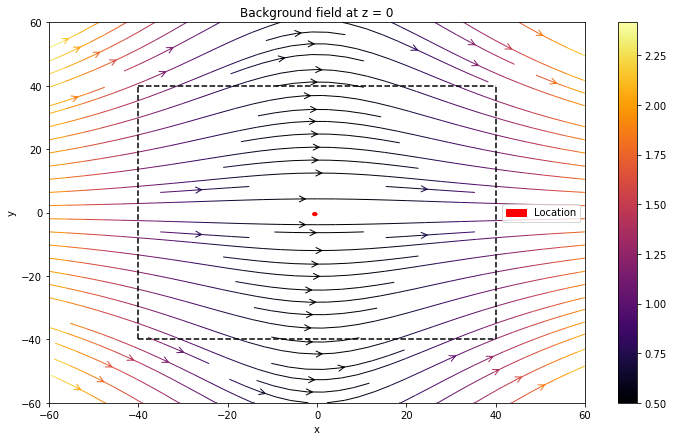

In [11]:
# Create meshgrid and and compute fields at grid points
xgrid = np.linspace(-1.5*L,1.5*L,Nx+1)
ygrid = np.linspace(-1.5*L,1.5*L,Nx+1)
X, Y = np.meshgrid(xgrid,ygrid)
Bx = B0x(X)
By = B0y(X,Y)

# Plot field lines and mark position in y-direction
f2 = plt.figure()
f2.set_figheight(7)
f2.set_figwidth(12)
ax = f2.add_subplot(111)
color = np.hypot(Bx,By)
strm = ax.streamplot(X, Y, Bx, By, color=color, linewidth=1, cmap=plt.cm.inferno, density=1, arrowstyle='->', arrowsize=1.5)
circle = plt.Circle((0-0.5,y-0.5), 0.5, color='r')
ax.add_patch(circle)
circle.set(label='Location')
f2.colorbar(strm.lines)
plt.xlabel('x')
plt.ylabel('y')
plt.plot(-L*np.ones(100),np.linspace(-L,L,100),'k--')
plt.plot(L*np.ones(100),np.linspace(-L,L,100),'k--')
plt.plot(np.linspace(-L,L,100),-L*np.ones(100),'k--')
plt.plot(np.linspace(-L,L,100),L*np.ones(100),'k--')
ax.legend()
plt.title('Background field at z = 0')

# Check conservation law (only valid for periodic boundary conditions)
For instance a integration of $B_{1y}$ over all space yields
\begin{align}
\frac{d}{dt}\int_{-L}^LB_{1y}\text{d}x+\int_{-L}^L(B_{0y}\partial_x u_{1x}-B_{0x}\partial_x u_{1y})\text{d}x=\int_{-L}^L(-u_{1x}\partial_x B_{oy}+u_{1y}\partial_x B_{0x}+u_{1y}\partial_z B_{0z})\text{d}x \\
P.I.:\quad\frac{d}{dt}\int_{-L}^LB_{1y}\text{d}x+[B_{oy}u_{1x}-B_{0x}u_{1y}]_{-L}^L=\int_{-L}^Lu_{1y}\partial_z B_{0z}\text{d}x \\
\frac{d}{dt}\int_{-L}^LB_{1y}\text{d}x+B_{0y}(t,L)u_{1x}(t,L)-B_{0x}(t,L)u_{1y}(t,L)-B_{0y}(t,-L)u_{1x}(t,-L)+B_{0x}(t,-L)u_{1y}(t,-L)=-\xi B_{0x}(0)\int_{-L}^Lu_{1y}x\text{d}x \\
\frac{d}{dt}\int_{-L}^LB_{1y}\text{d}x=u_{1x}(t,L)2Ly\xi B_{0x}(0)-\xi B_{0x}(0)\int_{-L}^Lu_{1y}x\text{d}x
\end{align}

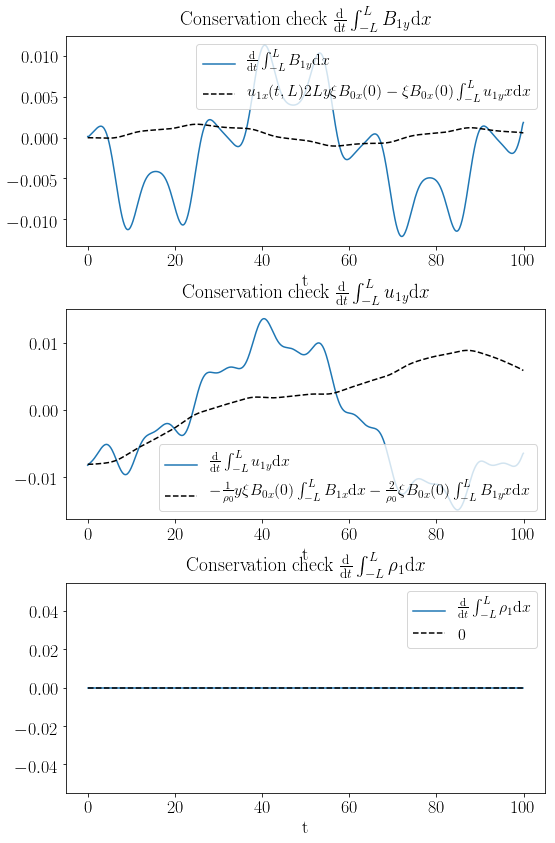

In [34]:
f3, (a1,a2,a3) = plt.subplots(3,1)
f3.set_figheight(12)
f3.set_figwidth(8)



# Conservation of B1y
b1y = np.zeros(Nt+1)
b = np.zeros(Nt+1)

for i in range(0,Nt+1):
    b1y[i] = deltax*sum(Test[i,:,4])
    b[i] = Test[i,0,0]*2*L*y*xi*B0x0-deltax*xi*B0x0*sum(Test[i,:,1]*x)
    
plt.rc('text', usetex = True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 16})   
a1.plot(t,np.gradient(b1y,deltat),label=r"$\frac{\mathrm{d}}{\mathrm{d}t}\int_{-L}^L B_{1y}\mathrm{d}x$")
a1.plot(t,b,'k--',label=r"$u_{1x}(t,L)2Ly\xi B_{0x}(0)-\xi B_{0x}(0)\int_{-L}^Lu_{1y}x\mathrm{d}x$")
a1.set_xlabel('t')
a1.legend()
a1.set_title(r"Conservation check $\frac{\mathrm{d}}{\mathrm{d}t}\int_{-L}^L B_{1y}\mathrm{d}x$")



# Conservation of u1y
u1y = np.zeros(Nt+1)
u = np.zeros(Nt+1)

for i in range(0,Nt+1):
    u1y[i] = deltax*sum(Test[i,:,1])
    u[i] = -1/rho0*y*xi*B0x0*deltax*sum(Test[i,:,3]-B0x(x))-2/rho0*deltax*xi*B0x0*sum((Test[i,:,4]-B0y(x,y))*x)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 16})  
a2.plot(t,np.gradient(u1y,deltat),label=r"$\frac{\mathrm{d}}{\mathrm{d}t}\int_{-L}^L u_{1y}\mathrm{d}x$")
a2.plot(t,u,'k--',label=r"$-\frac{1}{\rho_0}y\xi B_{0x}(0)\int_{-L}^LB_{1x}\mathrm{d}x-\frac{2}{\rho_0}\xi B_{0x}(0)\int_{-L}^LB_{1y}x\mathrm{d}x$")
a2.set_xlabel('t')
a2.legend()
a2.set_title(r"Conservation check $\frac{\mathrm{d}}{\mathrm{d}t}\int_{-L}^L u_{1y}\mathrm{d}x$")



# Conservation of rho1
rho1 = np.zeros(Nt+1)
rho = np.zeros(Nt+1)

for i in range(0,Nt+1):
    rho1[i] = deltax*sum(Test[i,:,6])
    rho[i] = 0

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 16})  
a3.plot(t,np.gradient(rho1,deltat),label=r"$\frac{\mathrm{d}}{\mathrm{d}t}\int_{-L}^L \rho_{1}\mathrm{d}x$")
a3.plot(t,rho,'k--',label=r"$0$")
a3.set_xlabel('t')
a3.legend()
a3.set_title(r"Conservation check $\frac{\mathrm{d}}{\mathrm{d}t}\int_{-L}^L \rho_{1}\mathrm{d}x$")

plt.tight_layout()
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

# Check boundary conditions

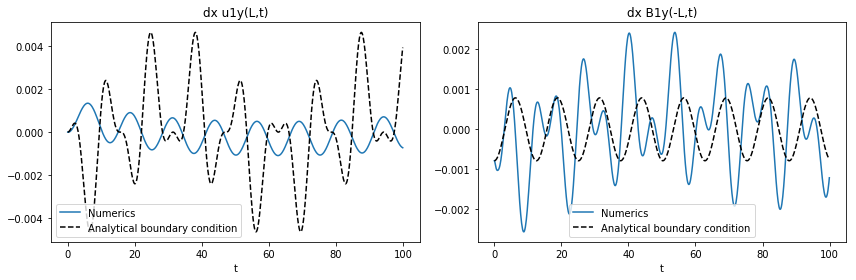

In [2]:
plt.rc('text', usetex = False)
plt.rc('font', family='sans-serif')
plt.rcParams.update({'font.size': 10})   



f4, (a1,a2) = plt.subplots(1,2)
f4.set_figheight(4)
f4.set_figwidth(12)

a1.plot(t,(Test[:,-1,1]-Test[:,-2,1])/deltax,label = 'Numerics')
a1.plot(t,n_R(t)[1],'k--',label = 'Analytical boundary condition')
a1.set_title('dx u1y(L,t)')
a1.set_xlabel('t')
a1.legend()
     
a2.plot(t,(Test[:,1,4]-Test[:,0,4])/deltax,label = 'Numerics')
a2.plot(t,n_L(t)[4],'k--',label = 'Analytical boundary condition')
a2.set_title('dx B1y(-L,t)')
a2.set_xlabel('t')
a2.legend()

plt.tight_layout()